In [1]:
from tools_harassment import * 
from models import *
from transformer_class import *
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Input
from keras.models import Model
from keras.layers import LSTM,GRU,Dense
from keras.utils import Sequence,to_categorical
from keras.preprocessing.sequence import pad_sequences
import os 
import torch 
import gc
import pandas as pd

keras.losses.focal_loss=keras.losses.MSE
keras.losses.focal_loss_fixed=keras.losses.MSE

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


dict_cl=dict()
dict_cl[0]="NonH"
dict_cl[1]="IndirectH"
dict_cl[2]="PhysicalH"
dict_cl[3]="SexualH"

#sdqc
d_lab=dict()
d_lab["NonH"]=0
d_lab["IndirectH"]=1
d_lab["PhysicalH"]=2
d_lab["SexualH"]=3

path="../../../Datasets/CSV_Harassment/"
train =pd.read_csv(path + "train_format.csv")
val=pd.read_csv(path + "val_format.csv")
test=pd.read_csv(path + "test_format.csv")

keys=["NonH", "IndirectH", "PhysicalH", "SexualH"]

stoplist = stopwords.words("english")
puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

def cleaner(post): 
    s= re.sub(r"http\S+", " html ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) ########3
    s= re.sub(r'@\w+ ?', " user ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " number ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " number ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=token_2_idx[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in token_2_idx.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in token_2_idx.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl


embeddings_index = {}
token_2_idx={}
idx_2_token={}
f = open(os.path.join("../../../Datasets/glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
i=0
for line in f:
    values = line.split()
    if len(values)>200:
        word = values[0]
    else:
        continue
    token_2_idx[word]=i
    idx_2_token[i]=word
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    i+=1
f.close()

MAX_LEN = 34
emb=200
EMB_matrix=np.zeros((len(token_2_idx.keys()), emb))
for i in range(len(token_2_idx.keys())):
    EMB_matrix[i]=embeddings_index[idx_2_token[i]]
    
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
EMB_matrix.shape

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


(1193513, 200)

In [2]:
def cm_norma(matrix):
    return matrix/matrix.sum(axis=-1, keepdims=True)

def plot_cm(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmax=1.0, vmin=0.0)
    plt.title(title)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
    thresh = cm.max() / 2.# if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    
def match(objetos,ejemplo):
    i=0
    for obj in objetos:
        if obj==ejemplo:
            return i
        i+=1
        
def data_gen(batch_size,mode,n_machines,new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings):  
    
    x_data=[] 
    y_data=[]
    if mode=='Train':
        max_objs=matrix.shape[1]
        x_list=np.arange(max_objs)
        np.random.shuffle(x_list)        #indices desordenados de seccion train
        labels=etiq     #np.load("matrices/y_train_num_4.npy")
        labels=np.asarray(labels) #+ np.ones(labels.shape),dtype='uint8')
    if mode=='Val':
        max_objs=matrix_val.shape[1] 
        x_list=np.arange(max_objs)
        x_list=[x+matrix.shape[1] for x in x_list]   
        labels=np.asarray(etiq_v)     #np.load("matrices/y_val_num_4.npy")
        labels=np.asarray(labels) #+ np.ones(labels.shape),dtype='uint8') 
    if mode=='Test':
        max_objs=matrix_test.shape[1] 
        x_list=np.arange(max_objs)
        x_list=[x+matrix.shape[1]+matrix_val.shape[1] for x in x_list]
        total=matrix.shape[1]+matrix_val.shape[1]
        
    #----------------------------------- COMPLETA MINI BATCHES ----------------------    
    if len(x_list)%batch_size==0:
        n_batches=len(x_list)/batch_size
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
    else:
        n_batches=int(len(x_list)/batch_size)
        resto=int(len(x_list)-n_batches*batch_size)
        to_repeat=batch_size-resto        
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
        cola=list(x_list[(nb+1)*batch_size:])
        for i in range(to_repeat):
            indice= np.random.randint(len(x_list))
            cola.append(x_list[indice])
        x_data.append(np.asarray(cola))
        if mode=='Test':
            print ("SE TUVIERON QUE REPETIR", to_repeat, "EJEMPLOS")
            
    #-------------------------------- CONSTRUCCION MINI BATCHES (X,Y)----------------------   
    new_x_data=[] 
    for batch in x_data:
        temp=[]
        for pos in batch:
            temp2=[index_embeddings[pos+5]] 
            for m in range(n_machines): 
                temp2= temp2 + [np.argmax(new_matrix[m][pos])+1] 
            temp.append(temp2)
        new_x_data.append(temp)   

    if mode=='Train' or mode=='Val':    
        y_data=[]
        for conjunto in range(len(new_x_data)):
            batch=new_x_data[conjunto]
            temp_y=[]
            for linea in range(len(batch)):
                indice=x_data[conjunto][linea]  #pos
                lab=d_lab[lab_str_embeddings[indice+5]]+1 #labels_train
                temp_y.append([lab])       
            y_data.append(temp_y)
            
        y_data=np.asarray(y_data)
        
    new_x_data=np.asarray(new_x_data)
    if mode=='Test':
        for x in new_x_data:
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            yield Batch(src, None, 0)        
    else:          
        for x,y in zip(new_x_data, y_data):
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            har = Variable(torch.from_numpy(np.asarray(y)), requires_grad=False)
            yield Batch(src, har, 0)
            

def make_model_concat(target, K_list_new, N=2, d_model=768, d_ff=1024, h=4, dropout=0.3, soft=True):  #recibir src_vocab si lo utiliza dummy_Emb
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalText_concat(d_model, dropout)
    if soft:
        print ("Creando modelo con salida Softmax")
        model = EncoderDecoderSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(d_model, K_list_new), c(position)),
            nn.Linear(d_model, 4))
    else:
        print ("")
        print ("Creando modelo con salida Log_softmax")
        model = EncoderDecoderLogSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(d_model, K_list_new), c(position)),
            nn.Linear(d_model, 4))

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

def run_epoch(data_iter, model, loss_compute, mode):
    if mode=='Test':
        with torch.no_grad():
            start = time.time()
            pred_classes=[]
            for i, batch in enumerate(data_iter):
                out = model.forward(batch.src, batch.src_mask)
                pred_classes.append(out.argmax(dim=-1).numpy())
            return pred_classes
    
    else:
        start = time.time()
        total_learners = 0
        total_datos = 0
        total_loss = 0
        total_acc=0
        total_fm1=0
        total_fs=0
        n_batches = 0
        cm_last=np.zeros((4,4))
        for i, batch in enumerate(data_iter):
            out = model.forward(batch.src, batch.src_mask)
            loss,acc,f1,cm = loss_compute(out, batch.trg_y, batch.ntokens, mode)
            cm_last+=cm
            f_ma=np.mean(f1)
            total_loss += loss
            total_acc += np.array(acc)
            total_fm1 += np.sum(f1)/4.0    #4 clases (macro)
            total_fs += f1                 #none  
            total_datos += batch.ntokens
            n_batches += 1
        return total_loss/n_batches, torch.from_numpy(np.array(total_acc))/n_batches, torch.from_numpy(np.array(total_fm1))/n_batches, torch.from_numpy(np.array(total_fs))/n_batches, cm_last

def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=cm_norma(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("------ Testing ------")
    print ("Accuracy", name_model, ": %.3f" % acc_t)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma_t)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

In [3]:
MAX_LEN = 34
emb=200
EMB_matrix=np.zeros((len(token_2_idx.keys()), emb))
for i in range(len(token_2_idx.keys())):
    EMB_matrix[i]=embeddings_index[idx_2_token[i]]
    
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
    
ids_train=train['tweet_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
#class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights= np.asarray([1.0, 1.0, 1.0, 1.0])
print ("Pesos de clases:", class_weights)

ids_val=val['tweet_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

ids_test=test['tweet_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

sentences = tws_train
n_labels = np.asarray(labels_train)
y_train=to_categorical(n_labels,num_classes=4)

sentences_val = tws_val
n_labels_val = np.array(labels_val)
y_val=to_categorical(n_labels_val,num_classes=4)

sentences_test = tws_test
n_labels_test = np.array(labels_test)
y_test=to_categorical(n_labels_test,num_classes=4)

input_ids=[]
for sent in sentences:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent) 
    
input_ids_val=[]
for sent in sentences_val:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_val.append(encoded_sent) 

input_ids_test=[]
for sent in sentences_test:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_test.append(encoded_sent) 
    

Pesos de clases: [1. 1. 1. 1.]


In [4]:
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")

shape=np.asarray(input_ids).shape
shape_val=np.asarray(input_ids_val).shape
shape_test=np.asarray(input_ids_test).shape

x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1
    
x_val=np.zeros((shape_val[0], shape_val[1], emb))
i=0
for in_id in input_ids_val:
    x_val[i]=EMB_matrix[in_id]
    i+=1
    
x_test=np.zeros((shape_test[0], shape_test[1], emb))
i=0
for in_id in input_ids_test:
    x_test[i]=EMB_matrix[in_id]
    i+=1

In [5]:
path_m='../../../Datasets/Models_Harassment/'

etiq=np.asarray(labels_train)
etiq_v=np.asarray(labels_val)
etiq_t=np.asarray(labels_test)

In [6]:
from bert_serving.client import BertClient
import seaborn 

def draw(data, ax, label, color="Blues"):
    seaborn.heatmap(data, 
                    xticklabels=label[0], square=True, yticklabels=label[0], vmin=0.0, vmax=1.0, 
                    cbar=False,  cmap=color, ax=ax)

    
bc = BertClient()  

In [7]:
n_machines=5

In [40]:
def train_transformer(prob, num_epochs, path_a, path_m, c_gama, class_weights=np.ones(4), xfrom=1, xto=20, x_train=x_train, sentences=sentences, labels_train=labels_train, augmented=False):    
    global_accs=[]
    global_fnones=[]
    global_fmacros=[]
    global_cms=[]
    global_attn=[]
    best_macro={'F_ma':0.1 , 'Run':0}

    bs=32
    if augmented:
        tope=14645
    else:
        tope=8500
    for x in range(xfrom, xto + 1):
        if augmented:
            macro_augmented= np.load(path_a + 'balance_GloVe_' + str(int(prob*100)) + '_'+ str(x)+'_run.npy', allow_pickle=True)
            ids_train=macro_augmented[:,0]
            tws_train=macro_augmented[:,1]
            labels_train=macro_augmented[:,2]
            class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
            print ("Pesos de clases:", class_weights)

            etiq=np.asarray(labels_train)
            sentences = tws_train
            n_labels = etiq.copy()
            y_train=to_categorical(n_labels,num_classes=4)

            input_ids=[]
            for sent in sentences:
                encoded_sent=[]
                for wd in sent:
                    try:
                        encoded_sent.append(token_2_idx[wd])
                    except:
                        continue
                input_ids.append(encoded_sent)

            input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
            shape=np.asarray(input_ids).shape

            x_train=np.zeros((shape[0], shape[1], emb))
            j=0
            for in_id in input_ids:
                x_train[j]=EMB_matrix[in_id]
                j+=1

        ################################################    
        print ("Entrenando Run #", x)
        if np.sum(class_weights)!=4.:
            c='cw'
        else:
            c=''
            
        cnn1 = load_model(path_m+str(prob)+c+'/cnn1_'+str(x)+'-exec.h5')
        cnn2 = load_model(path_m+str(prob)+c+'/cnn2_'+str(x)+'-exec.h5')
        rnn1 = load_model(path_m+str(prob)+c+'/rnn1_'+str(x)+'-exec.h5')
        rnn2 = load_model(path_m+str(prob)+c+'/rnn2_'+str(x)+'-exec.h5')
        rnn3 = load_model(path_m+str(prob)+c+'/rnn3_'+str(x)+'-exec.h5')

        list_models=['cnn1', 'cnn2', 'rnn1', 'rnn2', 'rnn3']
        index_models=np.arange(5)
        dict_models=dict((key, value) for (key, value) in zip(index_models,list_models))
        modelos=[cnn1, cnn2, rnn1, rnn2, rnn3]
        ind=np.arange(5)
        dict_trainedModel=dict((key, value) for (key, value) in zip(ind,modelos))

        predicciones_all=[]
        predicciones_all_val=[]
        predicciones_all_test=[]

        print ("agregando predicciones Train")
        for i in dict_trainedModel.keys(): 
            a_evaluar=dict_models[i]
            predicciones_all.append(dict_trainedModel[i].predict(x_train, batch_size=bs))
        print ("agregando predicciones Val")
        for i in dict_trainedModel.keys(): 
            a_evaluar=dict_models[i]
            predicciones_all_val.append(dict_trainedModel[i].predict(x_val, batch_size=bs))
        print ("agregando predicciones Test")
        for i in dict_trainedModel.keys(): 
            a_evaluar=dict_models[i]
            predicciones_all_test.append(dict_trainedModel[i].predict(x_test, batch_size=bs))

        matrix=np.asarray(predicciones_all)
        matrix_val=np.asarray(predicciones_all_val)
        matrix_test=np.asarray(predicciones_all_test)
        new_matrix=np.concatenate([matrix,matrix_val,matrix_test], axis=1)

        b_dim=768
        espacio=[np.ones(b_dim)]
        Ks= ortho_group.rvs(dim=b_dim)
        random=np.random.randint(Ks.shape[0], size=4)
        K_list=Ks[random]
        K_list_ext=espacio+list(K_list)
        index_embeddings=[0,1,2,3,4]
        lab_str_embeddings=['','','','','']
        
        if augmented:
            for i in range(len(sentences)):
                tw_tr=sentences[i]
                clase=dict_cl[labels_train[i]]            
                tw=' '.join([word for word in tw_tr])
                vector= bc.encode([tw])[0]
                final_bert= vector

                index_embeddings.append(i+5)
                lab_str_embeddings.append(clase)
                K_list_ext.append(final_bert) 
        
        else:
            for i in range(len(sentences)):
                tw_tr=sentences[i]
                clase=dict_cl[labels_train[i]]            
                encoded_tok = cleaner(tw_tr)[0]  #cleaner: raw, no cleaner:augmented version
                vector=bc.encode([encoded_tok])[0]
                final_bert= vector

                index_embeddings.append(i+5)
                lab_str_embeddings.append(clase)
                K_list_ext.append(final_bert)

        objs_val=val['tweet_id']      #df_val['Unnamed: 0'].values
        objs_test=test['tweet_id']    #np.arange(df_test.shape[0])
        lab_val=val['Label']
        lab_test=test['Label']
        tw_val=val['Tweet']
        tw_test=test['Tweet']
        llaves=np.concatenate([objs_val,objs_test])
        clases=np.concatenate([lab_val,lab_test])
        sent_all=np.concatenate([tw_val,tw_test])   
        
        for num in range(len(llaves)):
            i=llaves[num]
            clase=clases[num]
            tw_tr=sent_all[num]
            encoded_tok = cleaner(tw_tr)[0]  #cleaner: raw, no cleaner:augmented version
            vector=bc.encode([encoded_tok])[0]
            final_bert= vector

            index_embeddings.append(num+5+train.shape[0])
            lab_str_embeddings.append(clase)
            K_list_ext.append(final_bert)


        K_list_new= np.asarray(K_list_ext, dtype='float32')

        ###################################### TRANSFORMER ###############################
        hist_train_loss=[]
        hist_train_acc=[]
        hist_train_fma=[]
        hist_val_loss=[]
        hist_val_acc=[]
        hist_val_fma=[]

        V = 4
        pesos = torch.from_numpy(class_weights).float()
        criterion = FocalLoss(weights=pesos)
        model = make_model_concat(4, K_list_new, N=2,d_model=b_dim, d_ff=128, h=4, dropout=0.35)
        model_opt = NoamOpt(model.src_embed[0].d_model,  1, 6000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))


        for epoch in range(num_epochs):
            model.train()
            DATA=data_gen(bs, 'Train', 5, new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings)  
            loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')

            model.eval()
            DATA_VAL=data_gen(bs, 'Val', 5, new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings)
            loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(DATA_VAL, model, SimpleLossComputeFL(criterion, None),'Val')
            if epoch%10==0:
                print ("Epoch",epoch, "\tacc_val: %.3f" % acc_val.numpy(), "\tF-macro_val: %.3f" % fma_val.numpy())

        model.eval()
        print ("Testing run #",x)
        DATA_TEST=data_gen(bs, 'Test', 5, new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings)
        predicciones = run_epoch(DATA_TEST, model, SimpleLossComputeFL(criterion, None),'Test')
        predicciones=np.concatenate(predicciones, axis=-1)

        glo_acc=accuracy_score(etiq_t, predicciones[:-21])
        glo_fno=f1_score(etiq_t,predicciones[:-21], average=None)
        glo_fma=f1_score(etiq_t,predicciones[:-21], average='macro')

        glo_cm=confusion_matrix(etiq_t, predicciones[:-21])

        plot_cm(cm_norma(glo_cm),["NonH", "IndirectH", "PhysicalH", "SexualH"],"BERT Transformer ", cmap=c_gama)
        global_accs.append(glo_acc)
        global_fnones.append(glo_fno)
        global_fmacros.append(glo_fma)
        global_cms.append(glo_cm)
        print("Test_ acc:",glo_acc) 
        print("Test_ f1 none:",glo_fno) 
        print("Test_ f1 macro:",glo_fma) 

        if glo_fma>best_macro['F_ma']:
            best_macro['F_ma']=glo_fma
            best_macro['Run']=x                
            #tope=8500

            for key in keys: 
                mask_s=test["Label"]==key
                q_tid=np.random.choice(test["tweet_id"][mask_s])
                q_ide=list(test["tweet_id"].values).index(q_tid)

                model.eval()

                temp2= [tope + q_ide]

                for m in range(n_machines): 
                    temp2= temp2 + [np.argmax(matrix_test[m][q_ide])+1] 

                sent = [temp2]
                src = torch.LongTensor([w for w in sent])
                src = Variable(src)
                src_mask = src_mask=  (src != 0).unsqueeze(-2)
                out = model.forward(src, src_mask)
                print ("\n\nEjemplo de tweet con label ", key, " y tweet_id ", q_tid)
                for layer in range(2):
                    fig, axs = plt.subplots(1,4, figsize=(22,11))
                    print("Encoder Layer", layer+1)
                    for h in range(4):
                        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
                            axs[h], sent, color=c_gama)
                    plt.show()
                    
    return best_macro, global_accs, global_fnones, global_fmacros, global_cms

## 0.0 No cw

In [24]:
class_weights= np.asarray([1.0, 1.0, 1.0, 1.0])
path_a='../../../Datasets/CSV_Harassment/Aumento_ofi/' 

Entrenando Run # 1
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.264 	F-macro_val: 0.136
Epoch 10 	acc_val: 0.889 	F-macro_val: 0.431
Epoch 20 	acc_val: 0.893 	F-macro_val: 0.436
Epoch 30 	acc_val: 0.889 	F-macro_val: 0.427
Epoch 40 	acc_val: 0.888 	F-macro_val: 0.428
Epoch 50 	acc_val: 0.886 	F-macro_val: 0.425
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


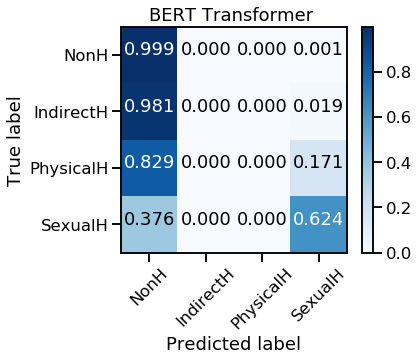

Test_ acc: 0.8530381535562883
Test_ f1 none: [0.91502146 0.         0.         0.74516696]
Test_ f1 macro: 0.4150471047014188


Ejemplo de tweet con label  NonH  y tweet_id  362
Encoder Layer 1


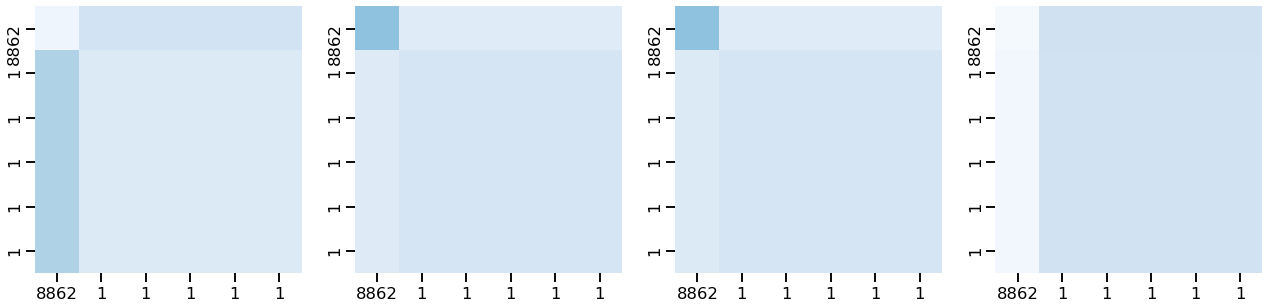

Encoder Layer 2


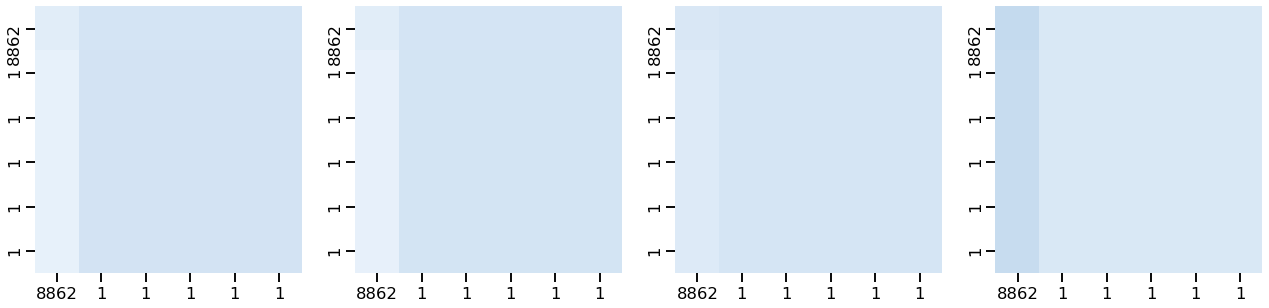



Ejemplo de tweet con label  IndirectH  y tweet_id  257
Encoder Layer 1


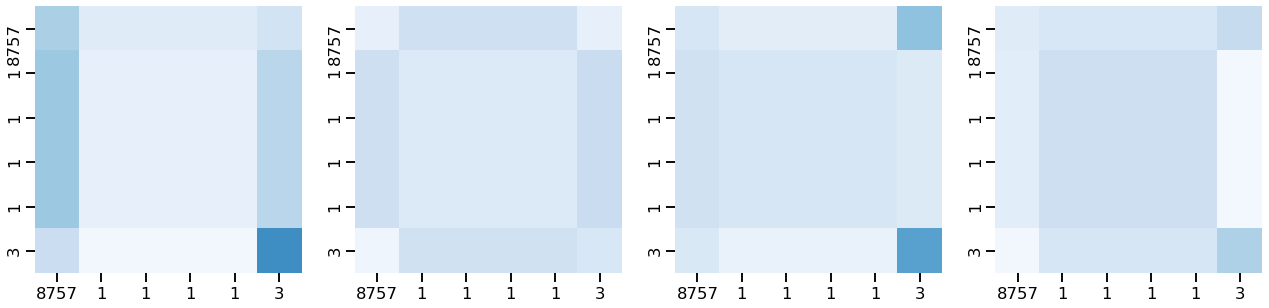

Encoder Layer 2


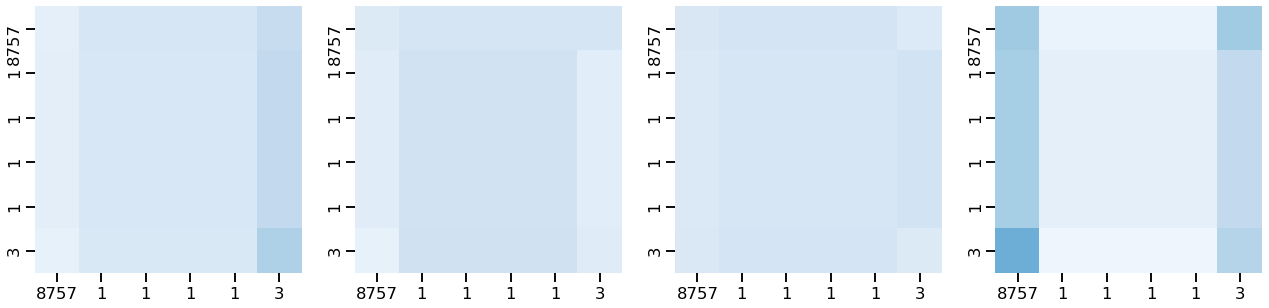



Ejemplo de tweet con label  PhysicalH  y tweet_id  1420
Encoder Layer 1


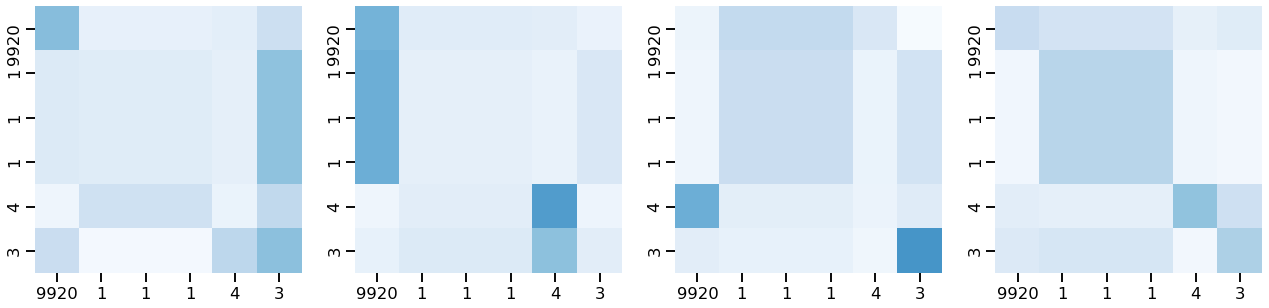

Encoder Layer 2


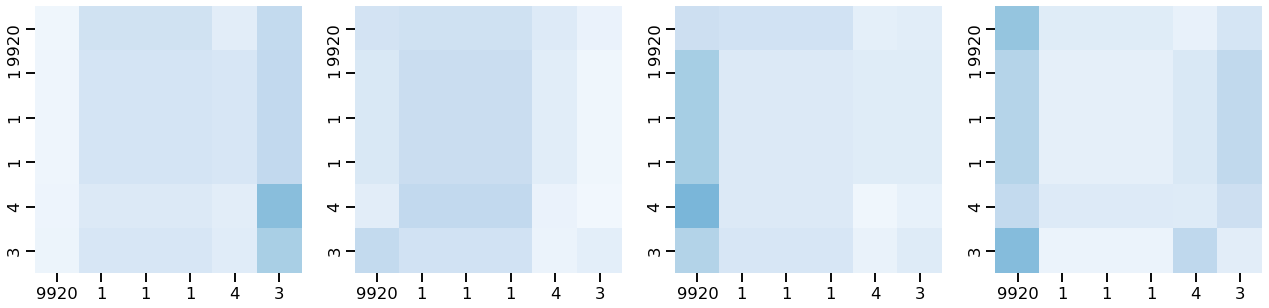



Ejemplo de tweet con label  SexualH  y tweet_id  1758
Encoder Layer 1


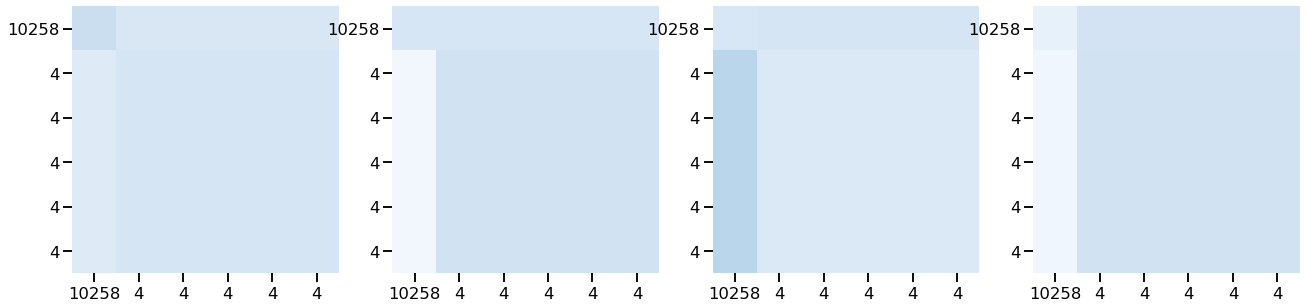

Encoder Layer 2


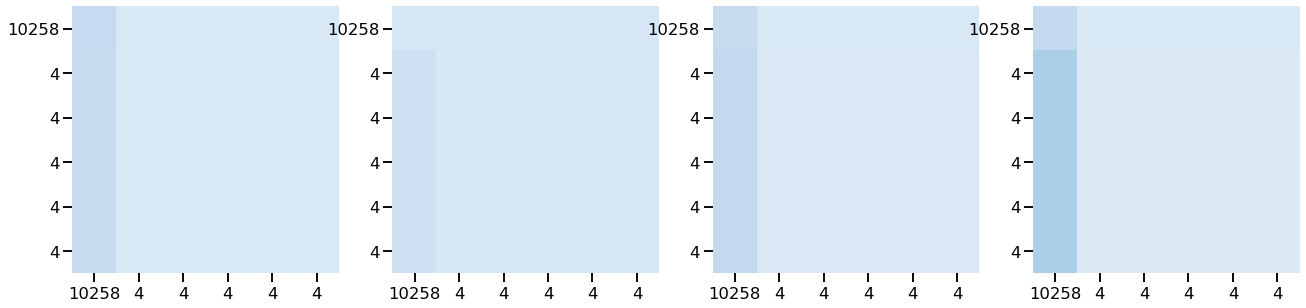

Entrenando Run # 2
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.556 	F-macro_val: 0.229
Epoch 10 	acc_val: 0.895 	F-macro_val: 0.433
Epoch 20 	acc_val: 0.895 	F-macro_val: 0.434
Epoch 30 	acc_val: 0.894 	F-macro_val: 0.434
Epoch 40 	acc_val: 0.895 	F-macro_val: 0.434
Epoch 50 	acc_val: 0.895 	F-macro_val: 0.434
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


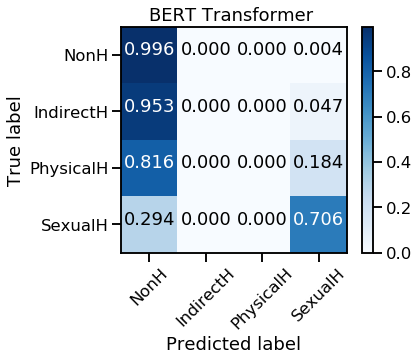

Test_ acc: 0.8643429109750354
Test_ f1 none: [0.92223186 0.         0.         0.79338843]
Test_ f1 macro: 0.42890507216770724


Ejemplo de tweet con label  NonH  y tweet_id  2108
Encoder Layer 1


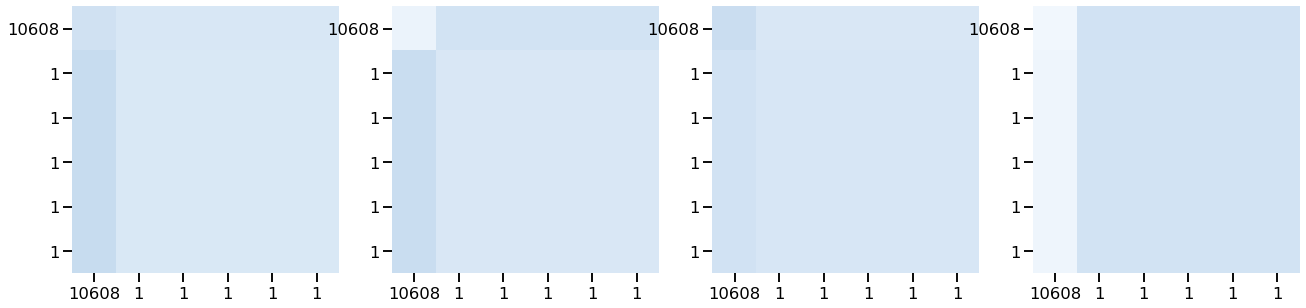

Encoder Layer 2


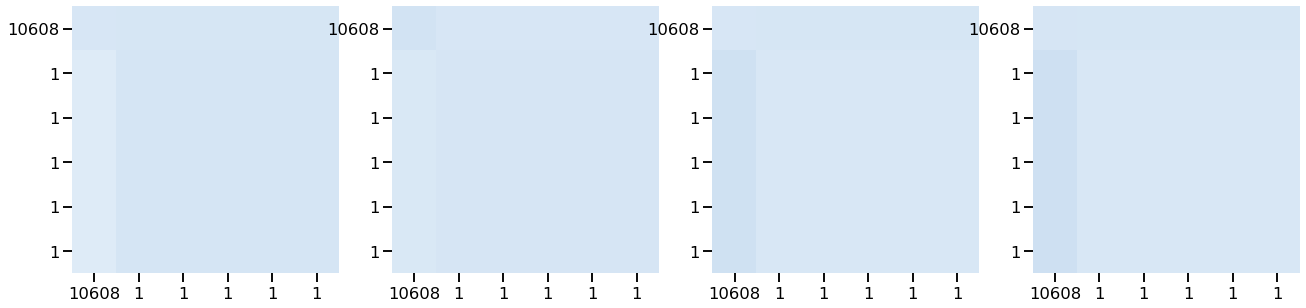



Ejemplo de tweet con label  IndirectH  y tweet_id  1787
Encoder Layer 1


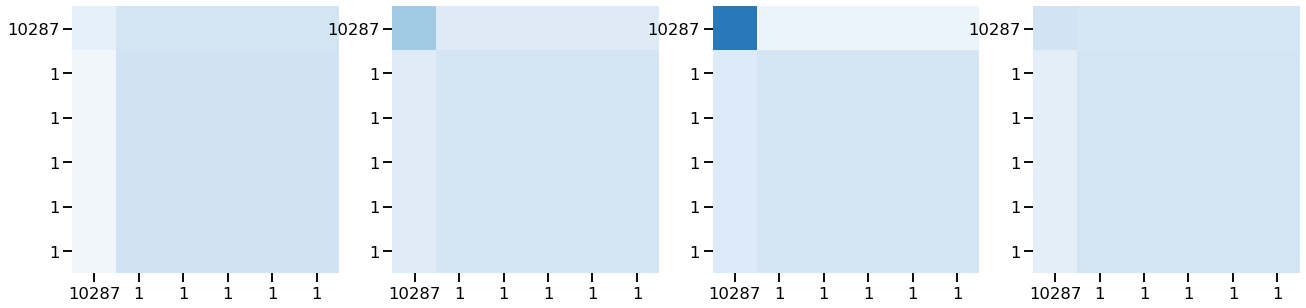

Encoder Layer 2


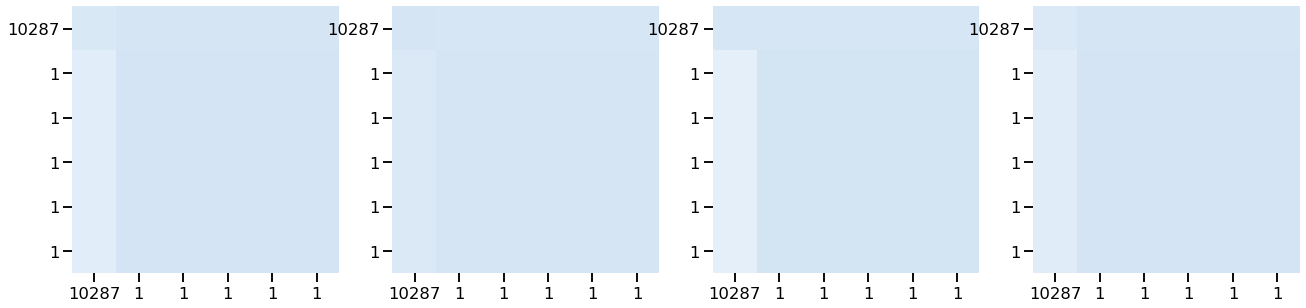



Ejemplo de tweet con label  PhysicalH  y tweet_id  1374
Encoder Layer 1


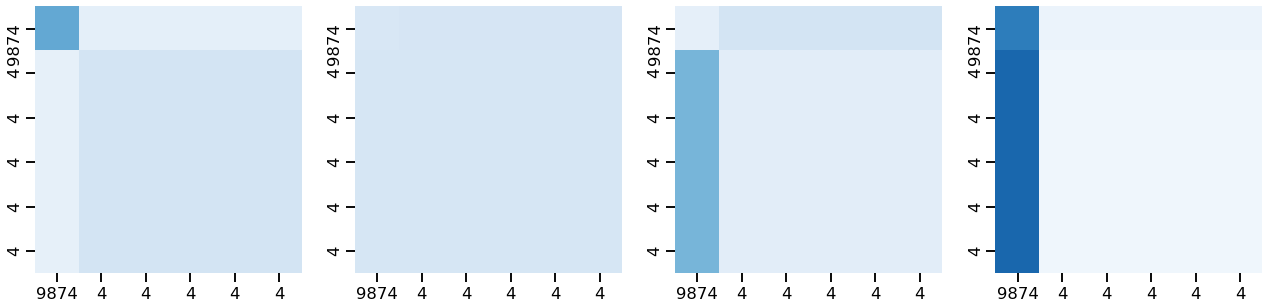

Encoder Layer 2


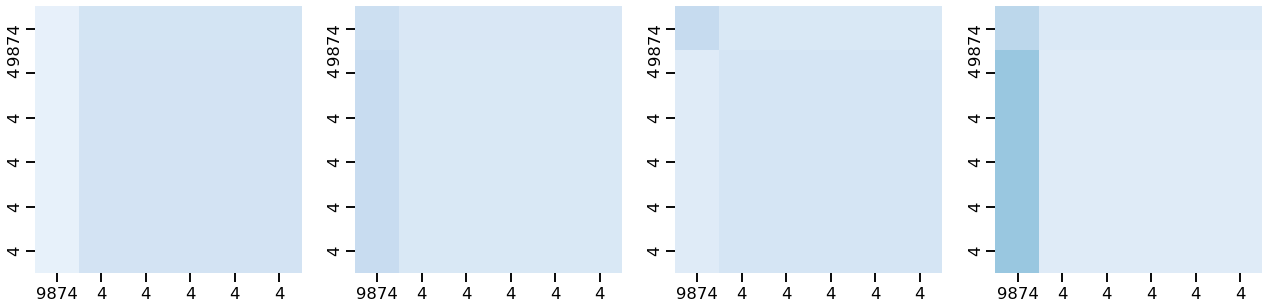



Ejemplo de tweet con label  SexualH  y tweet_id  1822
Encoder Layer 1


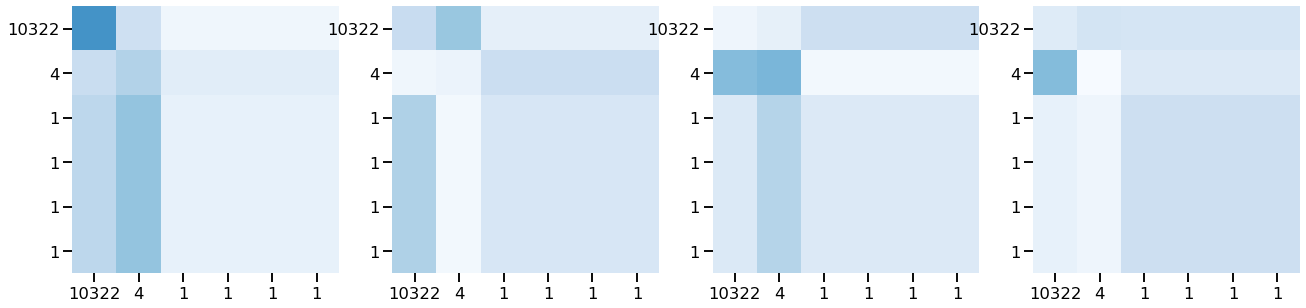

Encoder Layer 2


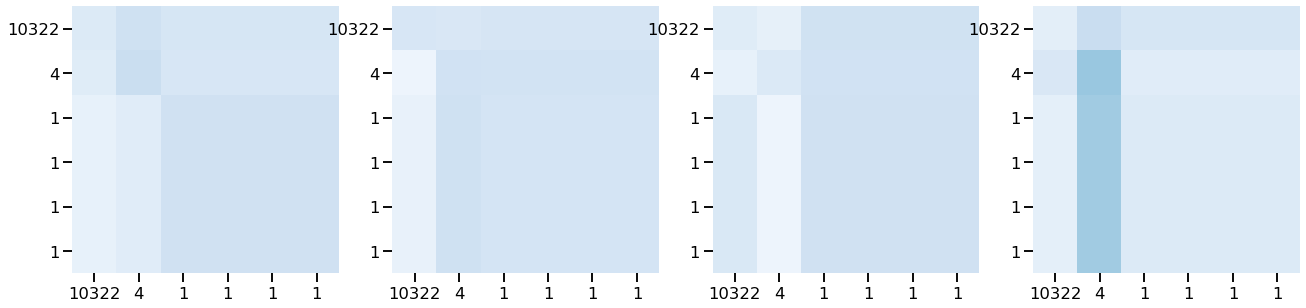

Entrenando Run # 3
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.153 	F-macro_val: 0.089
Epoch 10 	acc_val: 0.888 	F-macro_val: 0.426
Epoch 20 	acc_val: 0.897 	F-macro_val: 0.440
Epoch 30 	acc_val: 0.897 	F-macro_val: 0.440
Epoch 40 	acc_val: 0.897 	F-macro_val: 0.440
Epoch 50 	acc_val: 0.898 	F-macro_val: 0.441
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


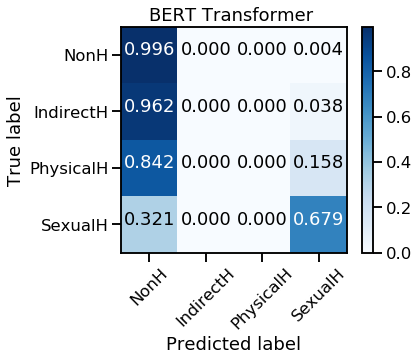

Test_ acc: 0.8601036269430051
Test_ f1 none: [0.9190435  0.         0.         0.77908938]
Test_ f1 macro: 0.42453321984178227
Entrenando Run # 4
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.075 	F-macro_val: 0.060
Epoch 10 	acc_val: 0.892 	F-macro_val: 0.438
Epoch 20 	acc_val: 0.889 	F-macro_val: 0.434
Epoch 30 	acc_val: 0.894 	F-macro_val: 0.439
Epoch 40 	acc_val: 0.895 	F-macro_val: 0.440
Epoch 50 	acc_val: 0.894 	F-macro_val: 0.442
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


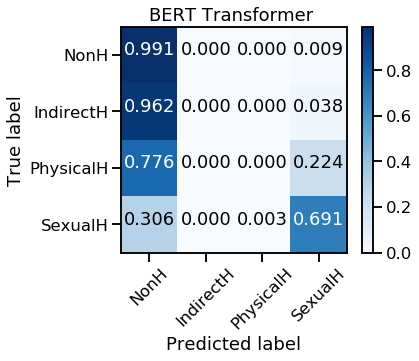

Test_ acc: 0.8582195007065473
Test_ f1 none: [0.9192007 0.        0.        0.7704918]
Test_ f1 macro: 0.42242312458161824
Entrenando Run # 5
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.099 	F-macro_val: 0.071
Epoch 10 	acc_val: 0.868 	F-macro_val: 0.416
Epoch 20 	acc_val: 0.889 	F-macro_val: 0.429
Epoch 30 	acc_val: 0.893 	F-macro_val: 0.436
Epoch 40 	acc_val: 0.894 	F-macro_val: 0.440
Epoch 50 	acc_val: 0.894 	F-macro_val: 0.439
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


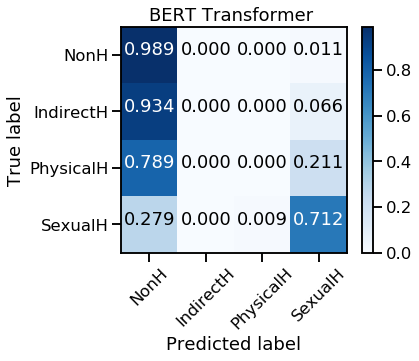

Test_ acc: 0.8601036269430051
Test_ f1 none: [0.92119802 0.         0.         0.77813505]
Test_ f1 macro: 0.4248332677281308
Entrenando Run # 6
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.073 	F-macro_val: 0.057
Epoch 10 	acc_val: 0.877 	F-macro_val: 0.423
Epoch 20 	acc_val: 0.894 	F-macro_val: 0.439
Epoch 30 	acc_val: 0.895 	F-macro_val: 0.438
Epoch 40 	acc_val: 0.897 	F-macro_val: 0.440
Epoch 50 	acc_val: 0.896 	F-macro_val: 0.440
Testing run # 6
SE TUVIERON QUE REPETIR 21 EJEMPLOS


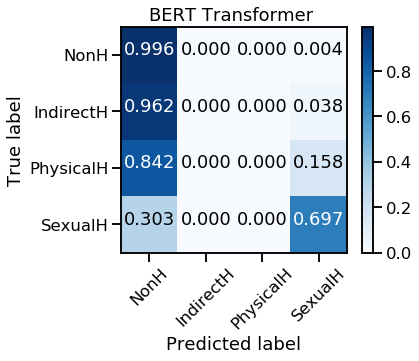

Test_ acc: 0.8624587847385775
Test_ f1 none: [0.92032333 0.         0.         0.79      ]
Test_ f1 macro: 0.427580831408776
Entrenando Run # 7
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.514 	F-macro_val: 0.222
Epoch 10 	acc_val: 0.880 	F-macro_val: 0.419
Epoch 20 	acc_val: 0.890 	F-macro_val: 0.429
Epoch 30 	acc_val: 0.890 	F-macro_val: 0.428
Epoch 40 	acc_val: 0.893 	F-macro_val: 0.434
Epoch 50 	acc_val: 0.892 	F-macro_val: 0.434
Testing run # 7
SE TUVIERON QUE REPETIR 21 EJEMPLOS


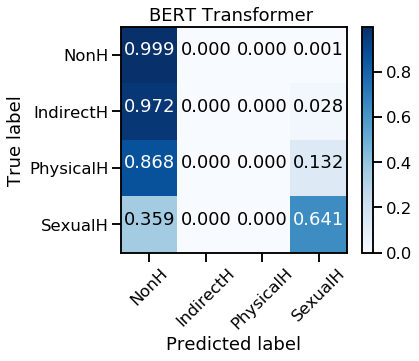

Test_ acc: 0.8563353744700894
Test_ f1 none: [0.9163803  0.         0.         0.76223776]
Test_ f1 macro: 0.4196545150153398
Entrenando Run # 8
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.257 	F-macro_val: 0.223
Epoch 10 	acc_val: 0.891 	F-macro_val: 0.439
Epoch 20 	acc_val: 0.892 	F-macro_val: 0.440
Epoch 30 	acc_val: 0.895 	F-macro_val: 0.442
Epoch 40 	acc_val: 0.896 	F-macro_val: 0.443
Epoch 50 	acc_val: 0.896 	F-macro_val: 0.443
Testing run # 8
SE TUVIERON QUE REPETIR 21 EJEMPLOS


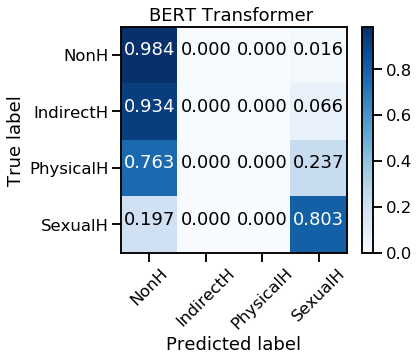

Test_ acc: 0.8709373528026377
Test_ f1 none: [0.92678624 0.         0.         0.82352941]
Test_ f1 macro: 0.437578912776519


Ejemplo de tweet con label  NonH  y tweet_id  953
Encoder Layer 1


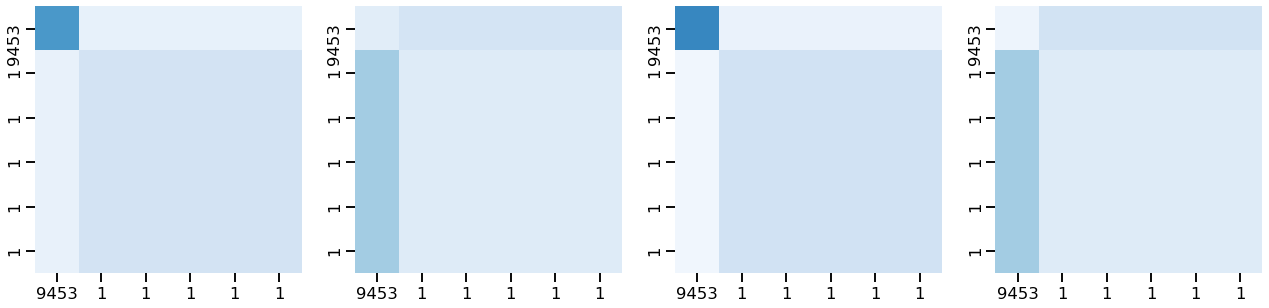

Encoder Layer 2


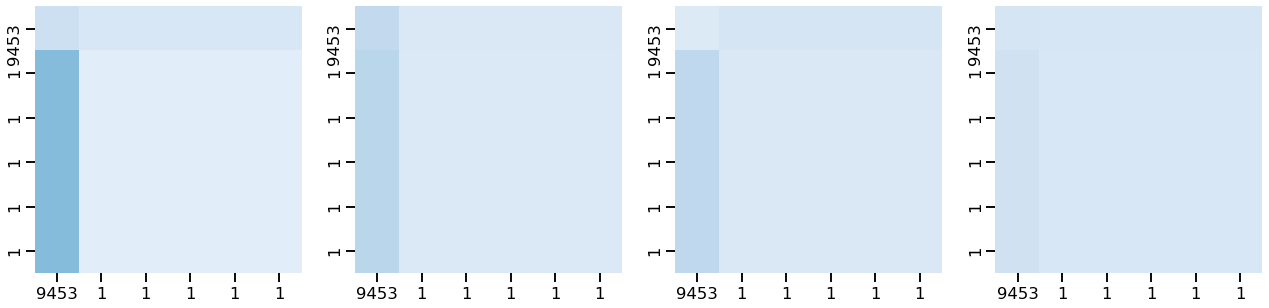



Ejemplo de tweet con label  IndirectH  y tweet_id  2071
Encoder Layer 1


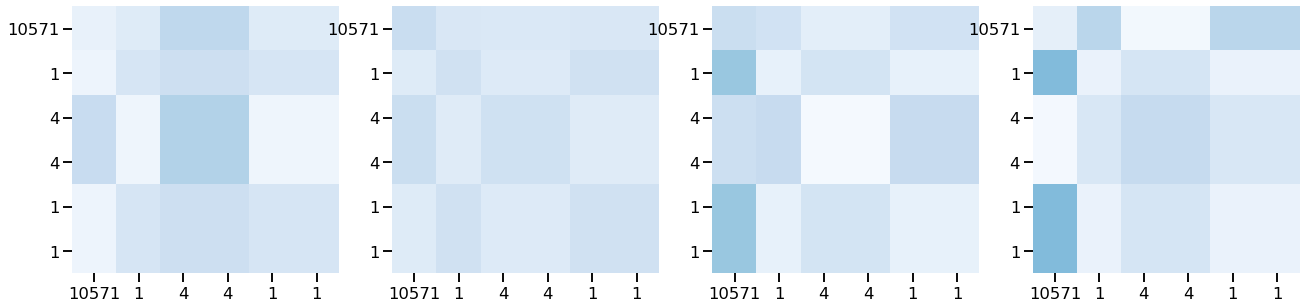

Encoder Layer 2


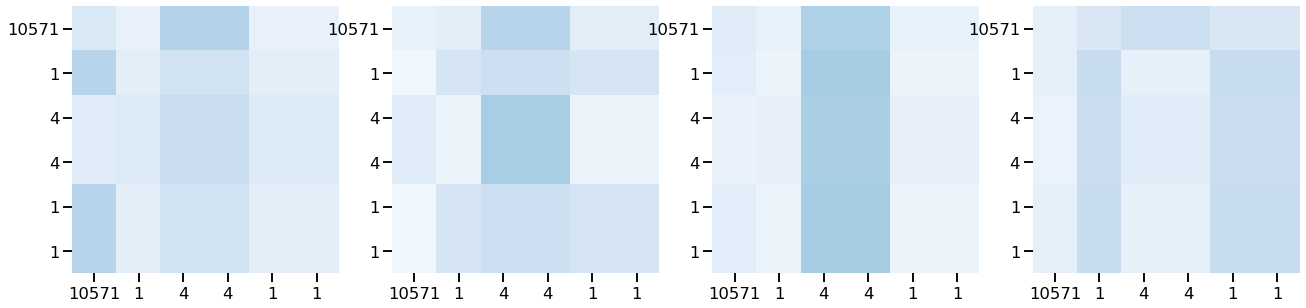



Ejemplo de tweet con label  PhysicalH  y tweet_id  315
Encoder Layer 1


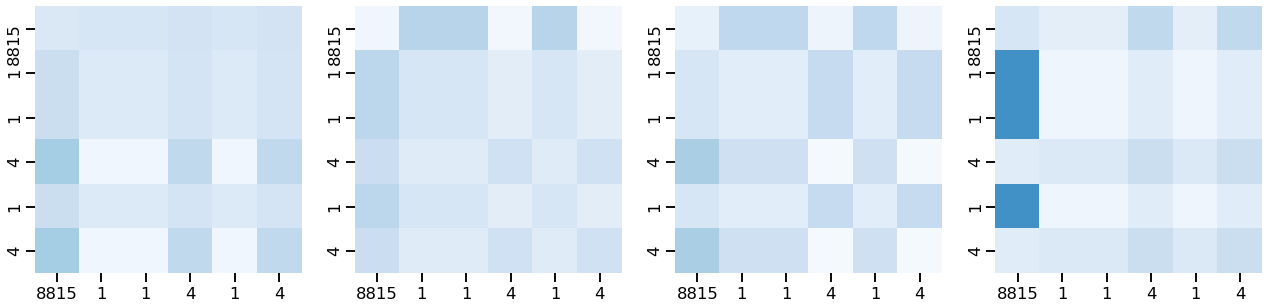

Encoder Layer 2


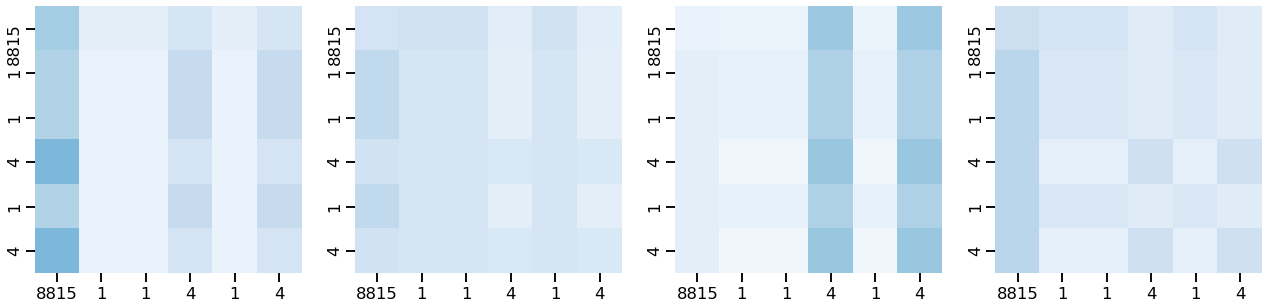



Ejemplo de tweet con label  SexualH  y tweet_id  1054
Encoder Layer 1


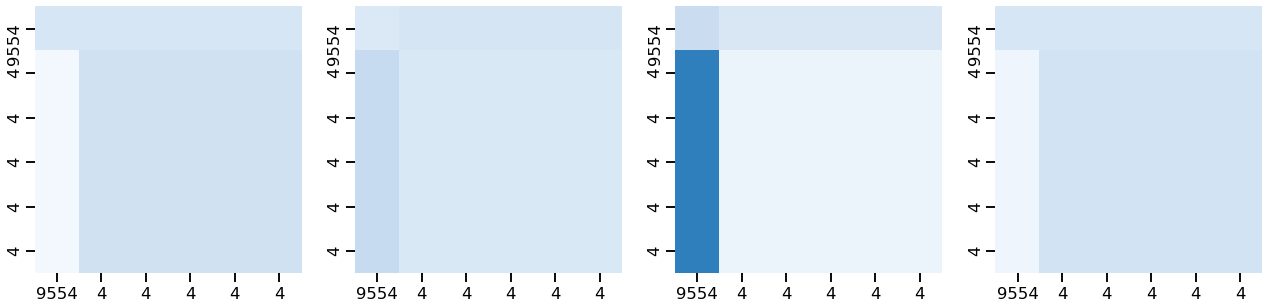

Encoder Layer 2


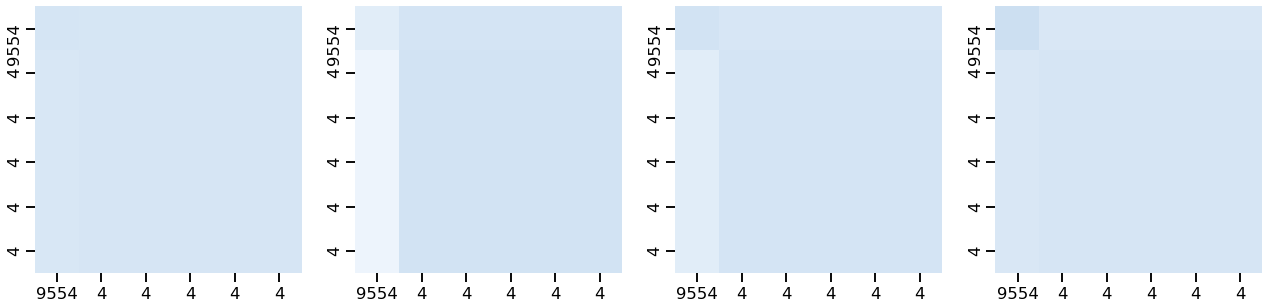

Entrenando Run # 9
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.046 	F-macro_val: 0.037
Epoch 10 	acc_val: 0.894 	F-macro_val: 0.438
Epoch 20 	acc_val: 0.892 	F-macro_val: 0.437
Epoch 30 	acc_val: 0.895 	F-macro_val: 0.440
Epoch 40 	acc_val: 0.894 	F-macro_val: 0.440
Epoch 50 	acc_val: 0.896 	F-macro_val: 0.444
Testing run # 9
SE TUVIERON QUE REPETIR 21 EJEMPLOS


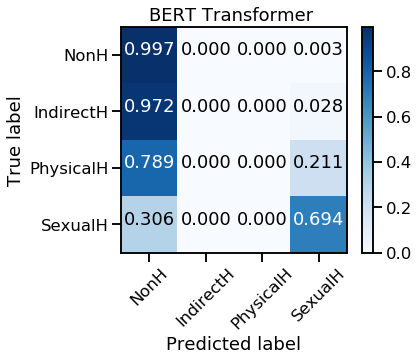

Test_ acc: 0.8629298162976919
Test_ f1 none: [0.92147806 0.         0.         0.78666667]
Test_ f1 macro: 0.427036181678214
Entrenando Run # 10
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.797 	F-macro_val: 0.371
Epoch 10 	acc_val: 0.894 	F-macro_val: 0.441
Epoch 20 	acc_val: 0.896 	F-macro_val: 0.442
Epoch 30 	acc_val: 0.895 	F-macro_val: 0.446
Epoch 40 	acc_val: 0.895 	F-macro_val: 0.445
Epoch 50 	acc_val: 0.895 	F-macro_val: 0.446
Testing run # 10
SE TUVIERON QUE REPETIR 21 EJEMPLOS


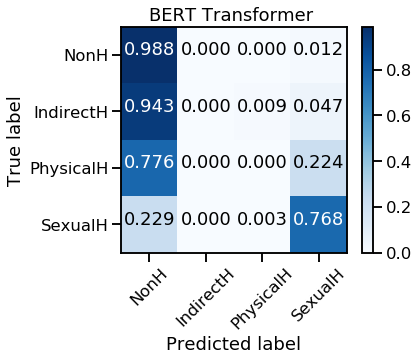

Test_ acc: 0.8676401318888366
Test_ f1 none: [0.92483182 0.         0.         0.8118196 ]
Test_ f1 macro: 0.43416285445390934
Entrenando Run # 11
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.230 	F-macro_val: 0.122
Epoch 10 	acc_val: 0.892 	F-macro_val: 0.430
Epoch 20 	acc_val: 0.897 	F-macro_val: 0.439
Epoch 30 	acc_val: 0.896 	F-macro_val: 0.440
Epoch 40 	acc_val: 0.896 	F-macro_val: 0.440
Epoch 50 	acc_val: 0.895 	F-macro_val: 0.440
Testing run # 11
SE TUVIERON QUE REPETIR 21 EJEMPLOS


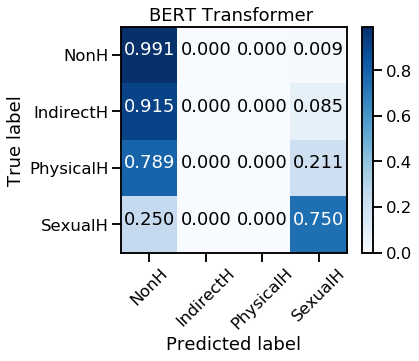

Test_ acc: 0.867169100329722
Test_ f1 none: [0.92505104 0.         0.         0.80314961]
Test_ f1 macro: 0.43205016039661714
Entrenando Run # 12
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.132 	F-macro_val: 0.125
Epoch 10 	acc_val: 0.884 	F-macro_val: 0.427
Epoch 20 	acc_val: 0.893 	F-macro_val: 0.431
Epoch 30 	acc_val: 0.894 	F-macro_val: 0.433
Epoch 40 	acc_val: 0.893 	F-macro_val: 0.431
Epoch 50 	acc_val: 0.895 	F-macro_val: 0.434
Testing run # 12
SE TUVIERON QUE REPETIR 21 EJEMPLOS


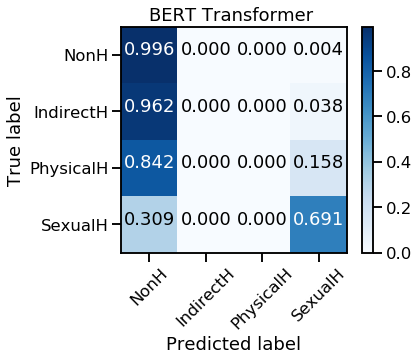

Test_ acc: 0.8615167216203485
Test_ f1 none: [0.91979227 0.         0.         0.78595318]
Test_ f1 macro: 0.42643636125033046
Entrenando Run # 13
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.353 	F-macro_val: 0.178
Epoch 10 	acc_val: 0.893 	F-macro_val: 0.438
Epoch 20 	acc_val: 0.891 	F-macro_val: 0.430
Epoch 30 	acc_val: 0.890 	F-macro_val: 0.429
Epoch 40 	acc_val: 0.889 	F-macro_val: 0.428
Epoch 50 	acc_val: 0.889 	F-macro_val: 0.428
Testing run # 13
SE TUVIERON QUE REPETIR 21 EJEMPLOS


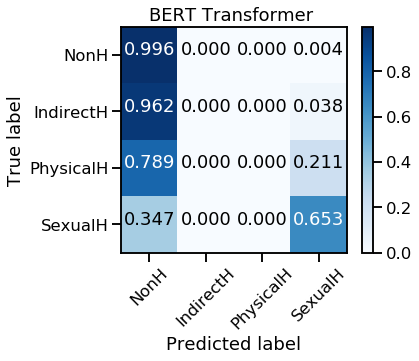

Test_ acc: 0.855864342910975
Test_ f1 none: [0.91772152 0.         0.         0.75510204]
Test_ f1 macro: 0.41820588995091706
Entrenando Run # 14
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.086 	F-macro_val: 0.070
Epoch 10 	acc_val: 0.883 	F-macro_val: 0.424
Epoch 20 	acc_val: 0.890 	F-macro_val: 0.430
Epoch 30 	acc_val: 0.889 	F-macro_val: 0.430
Epoch 40 	acc_val: 0.892 	F-macro_val: 0.431
Epoch 50 	acc_val: 0.891 	F-macro_val: 0.431
Testing run # 14
SE TUVIERON QUE REPETIR 21 EJEMPLOS


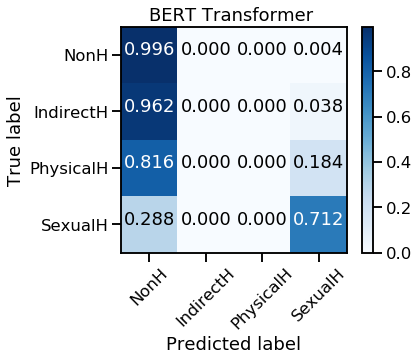

Test_ acc: 0.8652849740932642
Test_ f1 none: [0.92249855 0.         0.         0.79867987]
Test_ f1 macro: 0.4302946055160751
Entrenando Run # 15
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.299 	F-macro_val: 0.176
Epoch 10 	acc_val: 0.890 	F-macro_val: 0.432
Epoch 20 	acc_val: 0.895 	F-macro_val: 0.435
Epoch 30 	acc_val: 0.893 	F-macro_val: 0.434
Epoch 40 	acc_val: 0.893 	F-macro_val: 0.434
Epoch 50 	acc_val: 0.893 	F-macro_val: 0.434
Testing run # 15
SE TUVIERON QUE REPETIR 21 EJEMPLOS


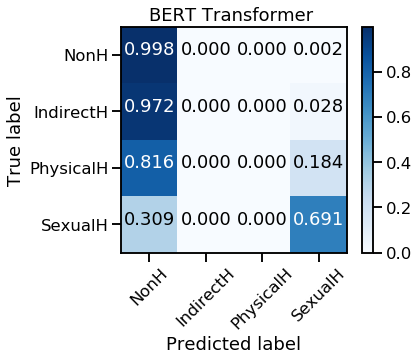

Test_ acc: 0.8634008478568064
Test_ f1 none: [0.92130297 0.         0.         0.78991597]
Test_ f1 macro: 0.4278047338854827
Entrenando Run # 16
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.407 	F-macro_val: 0.286
Epoch 10 	acc_val: 0.889 	F-macro_val: 0.436
Epoch 20 	acc_val: 0.891 	F-macro_val: 0.437
Epoch 30 	acc_val: 0.891 	F-macro_val: 0.436
Epoch 40 	acc_val: 0.892 	F-macro_val: 0.440
Epoch 50 	acc_val: 0.892 	F-macro_val: 0.440
Testing run # 16
SE TUVIERON QUE REPETIR 21 EJEMPLOS


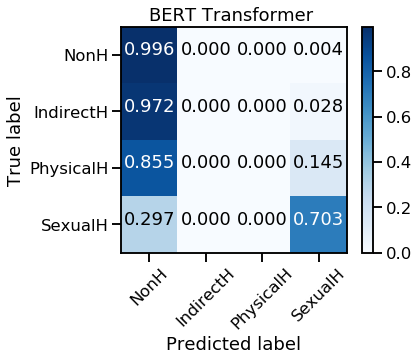

Test_ acc: 0.8638718794159209
Test_ f1 none: [0.92063492 0.         0.         0.79799666]
Test_ f1 macro: 0.4296578954341893
Entrenando Run # 17
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.065 	F-macro_val: 0.057
Epoch 10 	acc_val: 0.888 	F-macro_val: 0.432
Epoch 20 	acc_val: 0.891 	F-macro_val: 0.437
Epoch 30 	acc_val: 0.892 	F-macro_val: 0.441
Epoch 40 	acc_val: 0.893 	F-macro_val: 0.441
Epoch 50 	acc_val: 0.892 	F-macro_val: 0.440
Testing run # 17
SE TUVIERON QUE REPETIR 21 EJEMPLOS


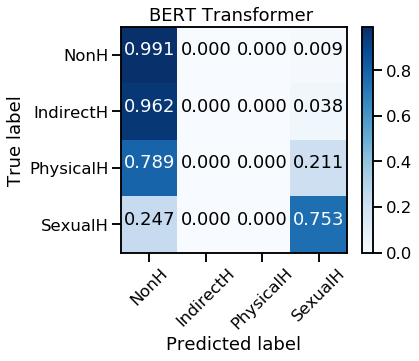

Test_ acc: 0.8676401318888366
Test_ f1 none: [0.9239732  0.         0.         0.81141046]
Test_ f1 macro: 0.43384591521740834
Entrenando Run # 18
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.070 	F-macro_val: 0.062
Epoch 10 	acc_val: 0.889 	F-macro_val: 0.432
Epoch 20 	acc_val: 0.889 	F-macro_val: 0.431
Epoch 30 	acc_val: 0.889 	F-macro_val: 0.432
Epoch 40 	acc_val: 0.890 	F-macro_val: 0.432
Epoch 50 	acc_val: 0.891 	F-macro_val: 0.436
Testing run # 18
SE TUVIERON QUE REPETIR 21 EJEMPLOS


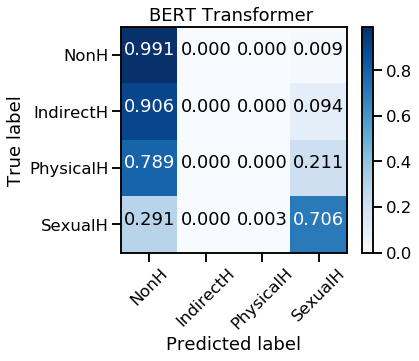

Test_ acc: 0.8601036269430051
Test_ f1 none: [0.92155723 0.         0.         0.77294686]
Test_ f1 macro: 0.423626023517391
Entrenando Run # 19
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.515 	F-macro_val: 0.312
Epoch 10 	acc_val: 0.886 	F-macro_val: 0.428
Epoch 20 	acc_val: 0.887 	F-macro_val: 0.429
Epoch 30 	acc_val: 0.886 	F-macro_val: 0.429
Epoch 40 	acc_val: 0.883 	F-macro_val: 0.426
Epoch 50 	acc_val: 0.886 	F-macro_val: 0.428
Testing run # 19
SE TUVIERON QUE REPETIR 21 EJEMPLOS


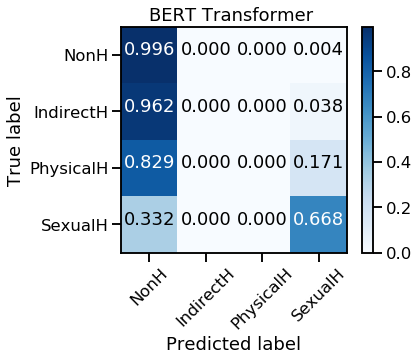

Test_ acc: 0.8582195007065473
Test_ f1 none: [0.91824986 0.         0.         0.76949153]
Test_ f1 macro: 0.4219353453743548
Entrenando Run # 20
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.341 	F-macro_val: 0.139
Epoch 10 	acc_val: 0.891 	F-macro_val: 0.430
Epoch 20 	acc_val: 0.890 	F-macro_val: 0.430
Epoch 30 	acc_val: 0.891 	F-macro_val: 0.430
Epoch 40 	acc_val: 0.892 	F-macro_val: 0.430
Epoch 50 	acc_val: 0.892 	F-macro_val: 0.430
Testing run # 20
SE TUVIERON QUE REPETIR 21 EJEMPLOS


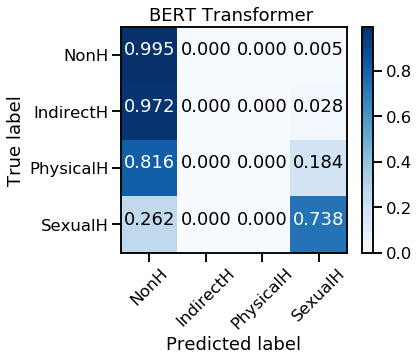

Test_ acc: 0.8685821950070655
Test_ f1 none: [0.92401392 0.         0.         0.81493506]
Test_ f1 macro: 0.43473724651218854


In [25]:
best_0, all_accs_0, all_fno_0, all_ma_0, all_cm_0 =train_transformer(0.0, 60, path_a, path_m, "Blues")

In [26]:
print ("best_0", best_0)
print ("all_accs_0", all_accs_0)
print ("all_fno_0", all_fno_0)
print ("all_ma_0", all_ma_0)

best_0 {'F_ma': 0.437578912776519, 'Run': 8}
all_accs_0 [0.8530381535562883, 0.8643429109750354, 0.8601036269430051, 0.8582195007065473, 0.8601036269430051, 0.8624587847385775, 0.8563353744700894, 0.8709373528026377, 0.8629298162976919, 0.8676401318888366, 0.867169100329722, 0.8615167216203485, 0.855864342910975, 0.8652849740932642, 0.8634008478568064, 0.8638718794159209, 0.8676401318888366, 0.8601036269430051, 0.8582195007065473, 0.8685821950070655]
all_fno_0 [array([0.91502146, 0.        , 0.        , 0.74516696]), array([0.92223186, 0.        , 0.        , 0.79338843]), array([0.9190435 , 0.        , 0.        , 0.77908938]), array([0.9192007, 0.       , 0.       , 0.7704918]), array([0.92119802, 0.        , 0.        , 0.77813505]), array([0.92032333, 0.        , 0.        , 0.79      ]), array([0.9163803 , 0.        , 0.        , 0.76223776]), array([0.92678624, 0.        , 0.        , 0.82352941]), array([0.92147806, 0.        , 0.        , 0.78666667]), array([0.92483182, 0.    

Acc: 0.862 -- deviation: 0.005
F-score: 0.427 -- deviation: 0.006
(0.0) NIPS: 0.9210645381363056 0.0 0.0 0.7870053141453685


Confusion counts
[[3.183e+04 0.000e+00 0.000e+00 1.900e+02]
 [2.027e+03 0.000e+00 1.000e+00 9.200e+01]
 [1.233e+03 0.000e+00 0.000e+00 2.870e+02]
 [2.007e+03 0.000e+00 6.000e+00 4.787e+03]]


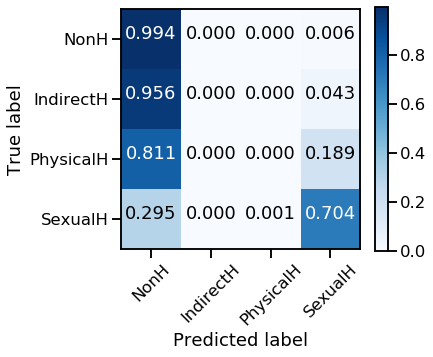

In [27]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs_0)), "-- deviation: %.3f" % np.std(np.asarray(all_accs_0)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma_0)), "-- deviation: %.3f" % np.std(np.asarray(all_ma_0)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno_0)[:,0])
den=np.mean(np.asarray(all_fno_0)[:,1])
que=np.mean(np.asarray(all_fno_0)[:,2])
com=np.mean(np.asarray(all_fno_0)[:,3])

print ("(0.0) NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm_0:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["NonH", "IndirectH", "PhysicalH", "SexualH"], "", cmap='Blues')

In [3]:
a=np.asarray([[3.183e+04 ,0.000e+00, 0.000e+00 ,1.900e+02],
 [2.027e+03, 0.000e+00, 1.000e+00, 9.200e+01],
 [1.233e+03, 0.000e+00, 0.000e+00, 2.870e+02],
 [2.007e+03, 0.000e+00, 6.000e+00, 4.787e+03]])

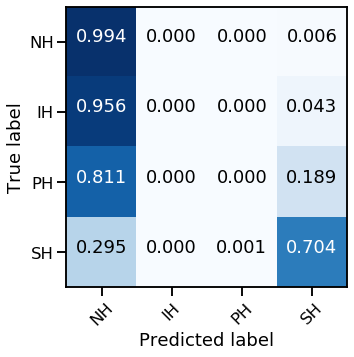

In [6]:
plot_cm(cm_norma(a),["NH", "IH", "PH", "SH"], "", cmap='Blues')

## 0.0 CW

In [29]:
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights

array([ 0.435, 28.973, 20.967,  0.617])

In [30]:
bc = BertClient() 

Entrenando Run # 1
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.047 	F-macro_val: 0.042
Epoch 10 	acc_val: 0.401 	F-macro_val: 0.298
Epoch 20 	acc_val: 0.735 	F-macro_val: 0.444
Epoch 30 	acc_val: 0.730 	F-macro_val: 0.447
Epoch 40 	acc_val: 0.793 	F-macro_val: 0.463
Epoch 50 	acc_val: 0.847 	F-macro_val: 0.464
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


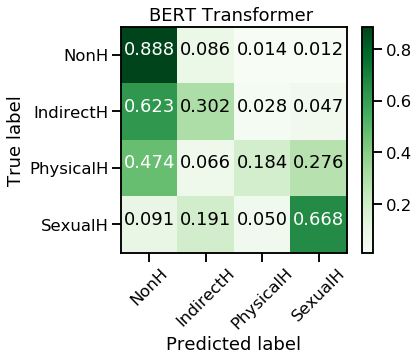

Test_ acc: 0.7979274611398963
Test_ f1 none: [0.901 0.185 0.211 0.742]
Test_ f1 macro: 0.509529968110447


Ejemplo de tweet con label  NonH  y tweet_id  3
Encoder Layer 1


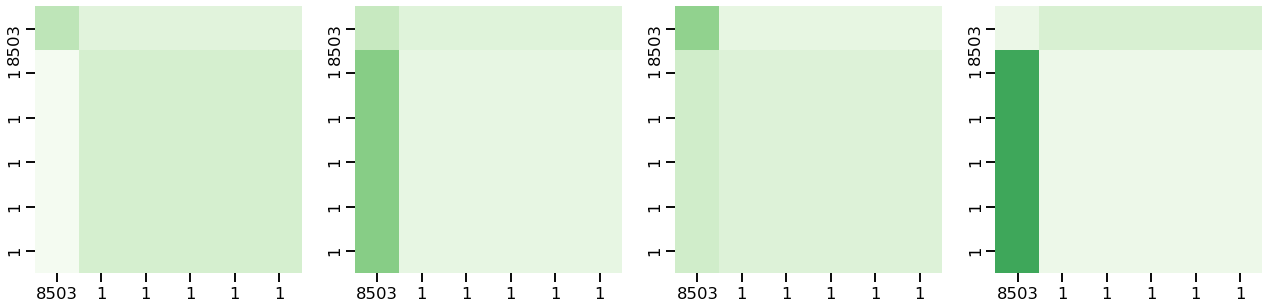

Encoder Layer 2


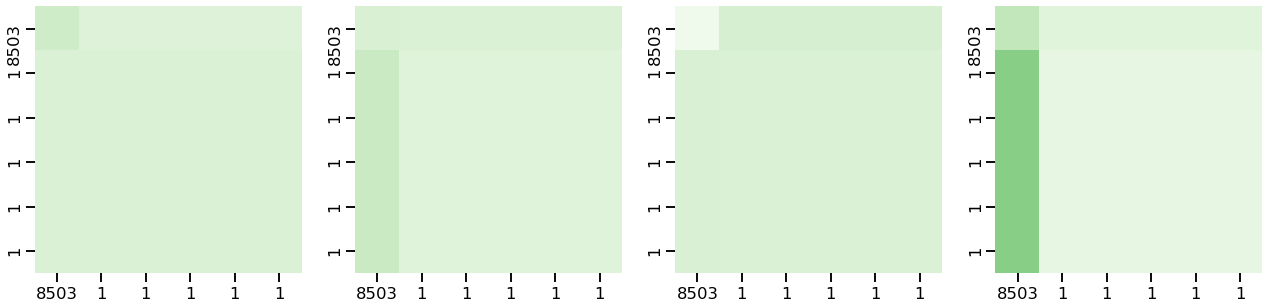



Ejemplo de tweet con label  IndirectH  y tweet_id  1787
Encoder Layer 1


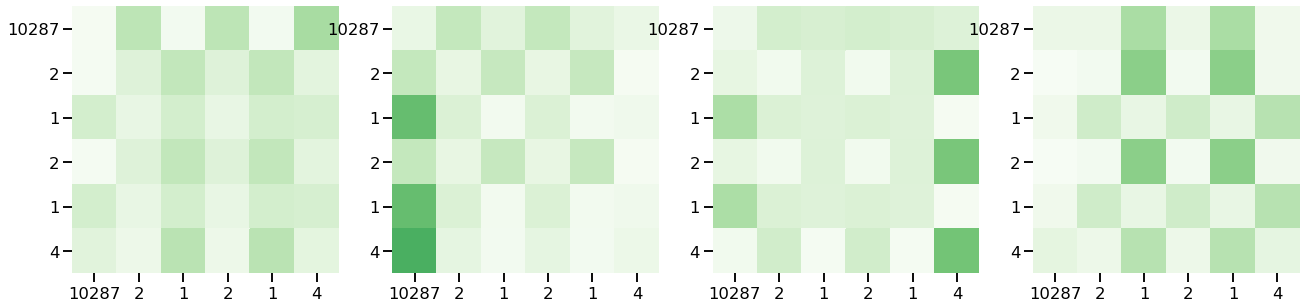

Encoder Layer 2


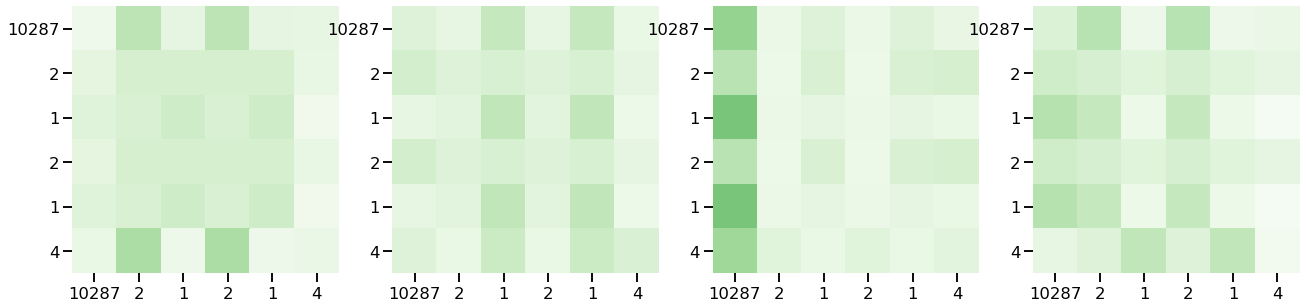



Ejemplo de tweet con label  PhysicalH  y tweet_id  1658
Encoder Layer 1


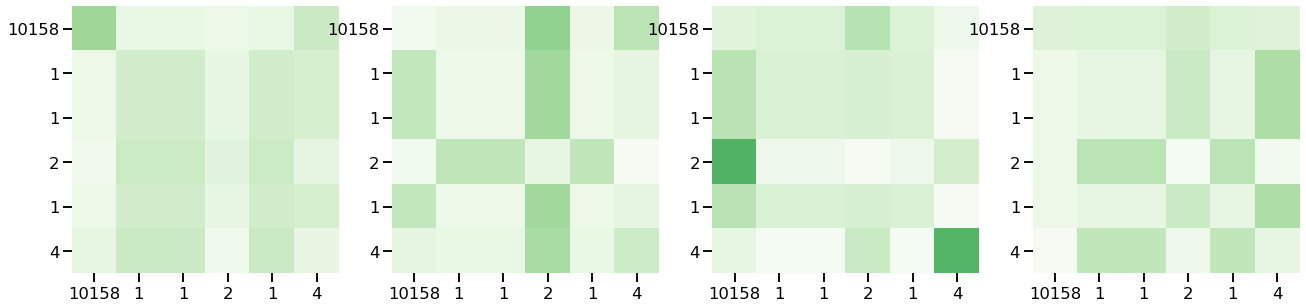

Encoder Layer 2


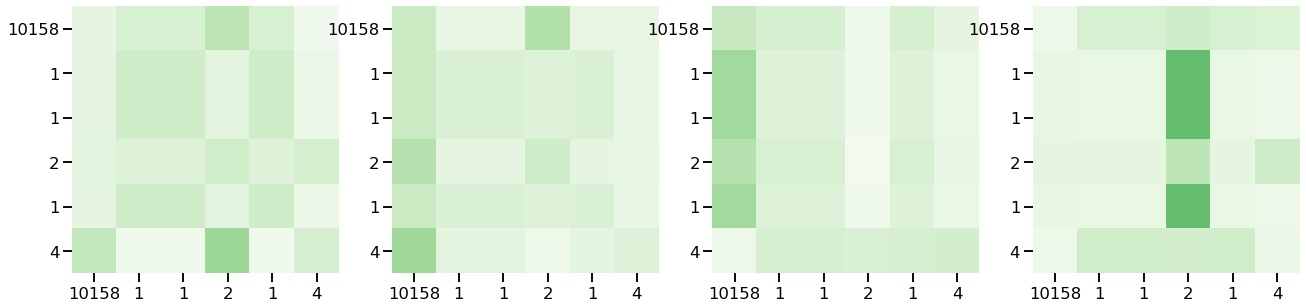



Ejemplo de tweet con label  SexualH  y tweet_id  1869
Encoder Layer 1


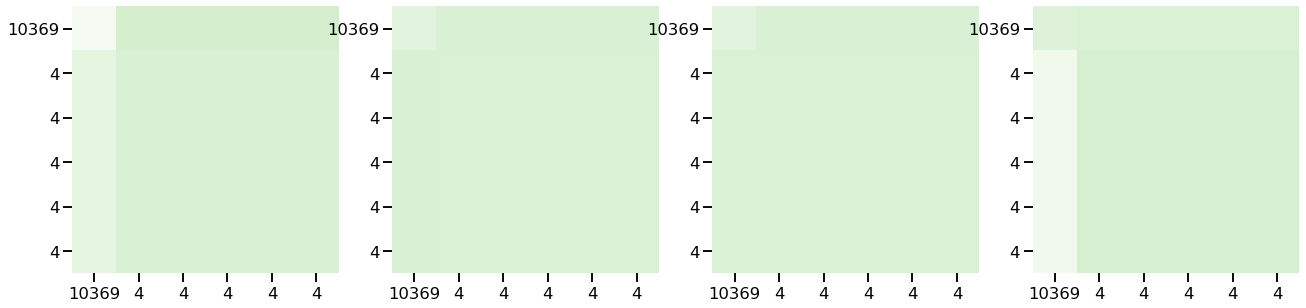

Encoder Layer 2


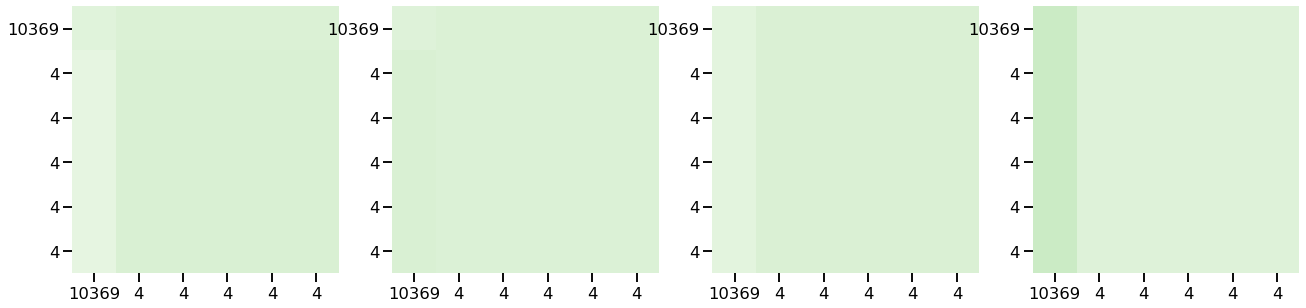

Entrenando Run # 2
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.504 	F-macro_val: 0.222
Epoch 10 	acc_val: 0.807 	F-macro_val: 0.411
Epoch 20 	acc_val: 0.871 	F-macro_val: 0.441
Epoch 30 	acc_val: 0.873 	F-macro_val: 0.451
Epoch 40 	acc_val: 0.870 	F-macro_val: 0.446
Epoch 50 	acc_val: 0.871 	F-macro_val: 0.451
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


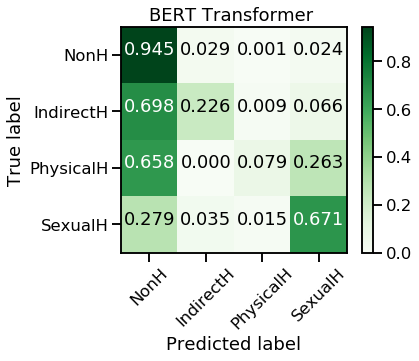

Test_ acc: 0.8341968911917098
Test_ f1 none: [0.908 0.254 0.133 0.719]
Test_ f1 macro: 0.5036088196471743
Entrenando Run # 3
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.194 	F-macro_val: 0.138
Epoch 10 	acc_val: 0.568 	F-macro_val: 0.342
Epoch 20 	acc_val: 0.819 	F-macro_val: 0.451
Epoch 30 	acc_val: 0.817 	F-macro_val: 0.460
Epoch 40 	acc_val: 0.805 	F-macro_val: 0.470
Epoch 50 	acc_val: 0.810 	F-macro_val: 0.472
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


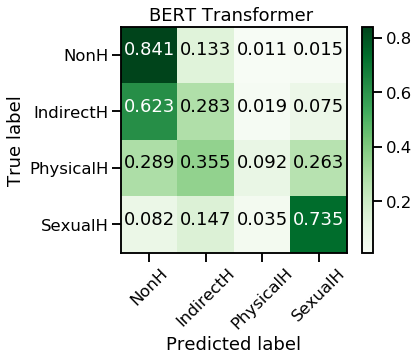

Test_ acc: 0.7691945360339143
Test_ f1 none: [0.879 0.141 0.122 0.779]
Test_ f1 macro: 0.480069329572115
Entrenando Run # 4
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.496 	F-macro_val: 0.239
Epoch 10 	acc_val: 0.873 	F-macro_val: 0.429
Epoch 20 	acc_val: 0.874 	F-macro_val: 0.440
Epoch 30 	acc_val: 0.876 	F-macro_val: 0.447
Epoch 40 	acc_val: 0.876 	F-macro_val: 0.455
Epoch 50 	acc_val: 0.883 	F-macro_val: 0.458
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


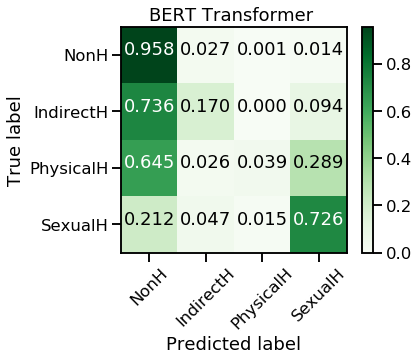

Test_ acc: 0.8487988695242581
Test_ f1 none: [0.92  0.194 0.071 0.771]
Test_ f1 macro: 0.4887558515081508
Entrenando Run # 5
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.140 	F-macro_val: 0.067
Epoch 10 	acc_val: 0.522 	F-macro_val: 0.260
Epoch 20 	acc_val: 0.850 	F-macro_val: 0.433
Epoch 30 	acc_val: 0.706 	F-macro_val: 0.415
Epoch 40 	acc_val: 0.710 	F-macro_val: 0.420
Epoch 50 	acc_val: 0.706 	F-macro_val: 0.418
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


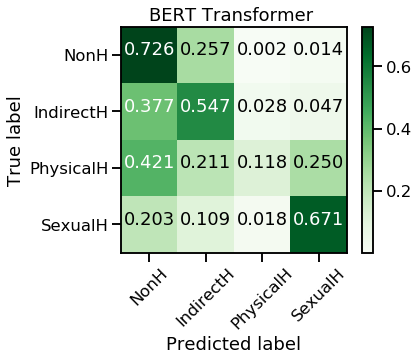

Test_ acc: 0.6867640131888837
Test_ f1 none: [0.801 0.185 0.184 0.741]
Test_ f1 macro: 0.47763468199410686
Entrenando Run # 6
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.613 	F-macro_val: 0.245
Epoch 10 	acc_val: 0.825 	F-macro_val: 0.414
Epoch 20 	acc_val: 0.849 	F-macro_val: 0.458
Epoch 30 	acc_val: 0.854 	F-macro_val: 0.457
Epoch 40 	acc_val: 0.854 	F-macro_val: 0.458
Epoch 50 	acc_val: 0.861 	F-macro_val: 0.460
Testing run # 6
SE TUVIERON QUE REPETIR 21 EJEMPLOS


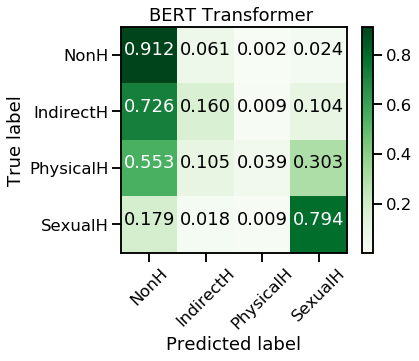

Test_ acc: 0.8243052284503062
Test_ f1 none: [0.901 0.145 0.069 0.791]
Test_ f1 macro: 0.4763081096542058
Entrenando Run # 7
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.196 	F-macro_val: 0.155
Epoch 10 	acc_val: 0.507 	F-macro_val: 0.328
Epoch 20 	acc_val: 0.834 	F-macro_val: 0.442
Epoch 30 	acc_val: 0.844 	F-macro_val: 0.439
Epoch 40 	acc_val: 0.817 	F-macro_val: 0.433
Epoch 50 	acc_val: 0.832 	F-macro_val: 0.433
Testing run # 7
SE TUVIERON QUE REPETIR 21 EJEMPLOS


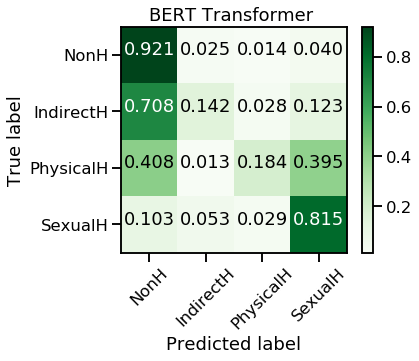

Test_ acc: 0.8389072067828545
Test_ f1 none: [0.917 0.167 0.224 0.765]
Test_ f1 macro: 0.5182158640417991


Ejemplo de tweet con label  NonH  y tweet_id  532
Encoder Layer 1


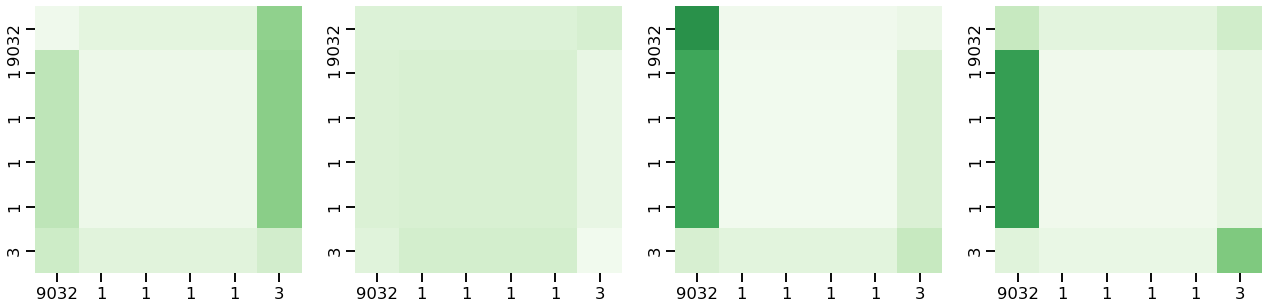

Encoder Layer 2


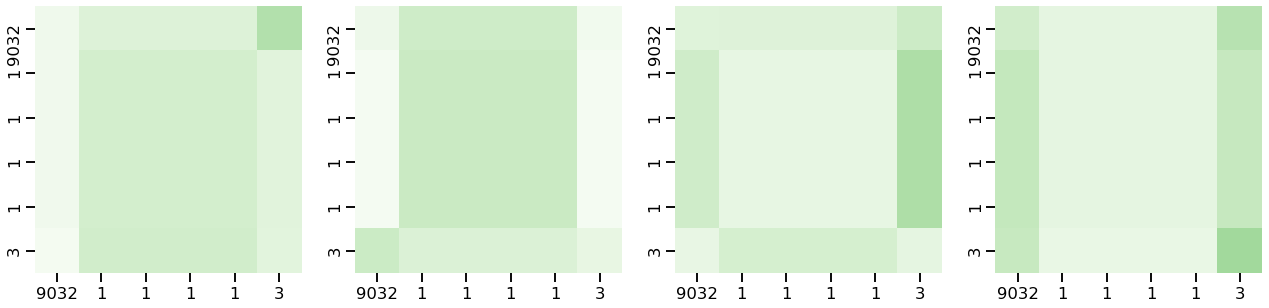



Ejemplo de tweet con label  IndirectH  y tweet_id  1756
Encoder Layer 1


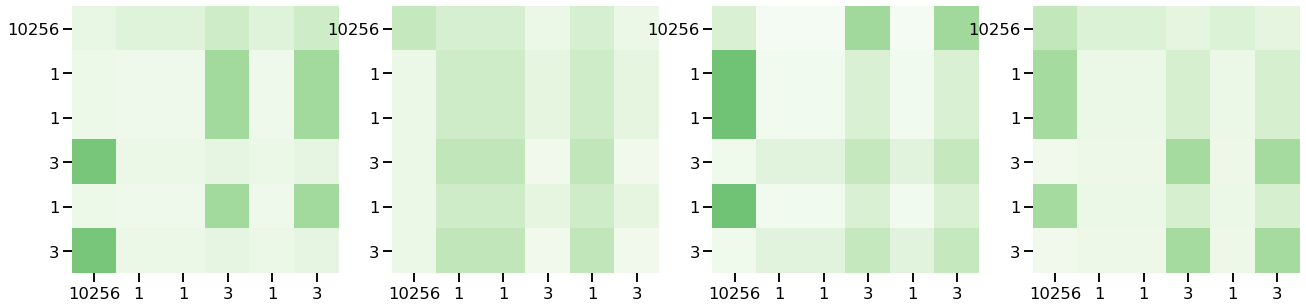

Encoder Layer 2


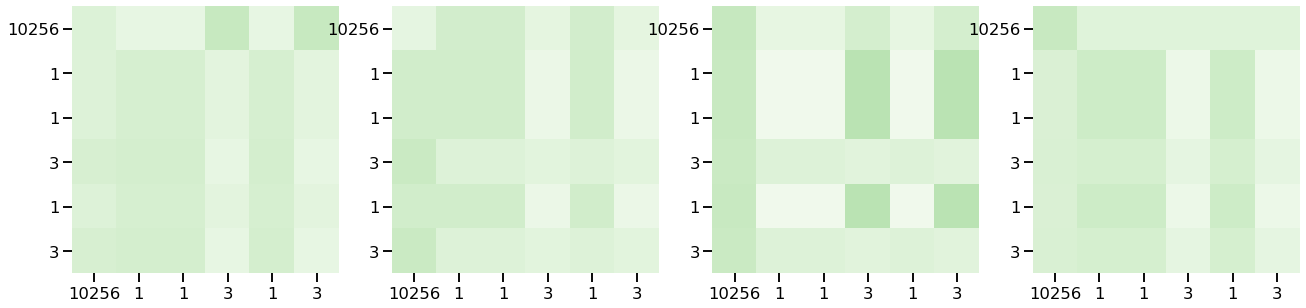



Ejemplo de tweet con label  PhysicalH  y tweet_id  1613
Encoder Layer 1


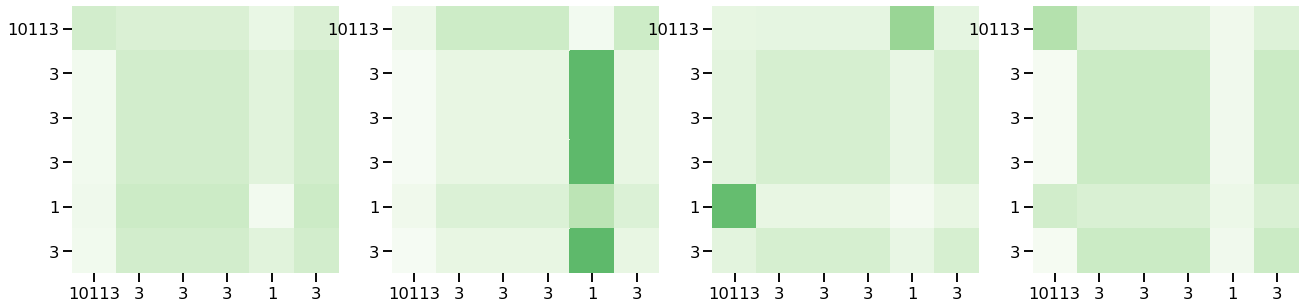

Encoder Layer 2


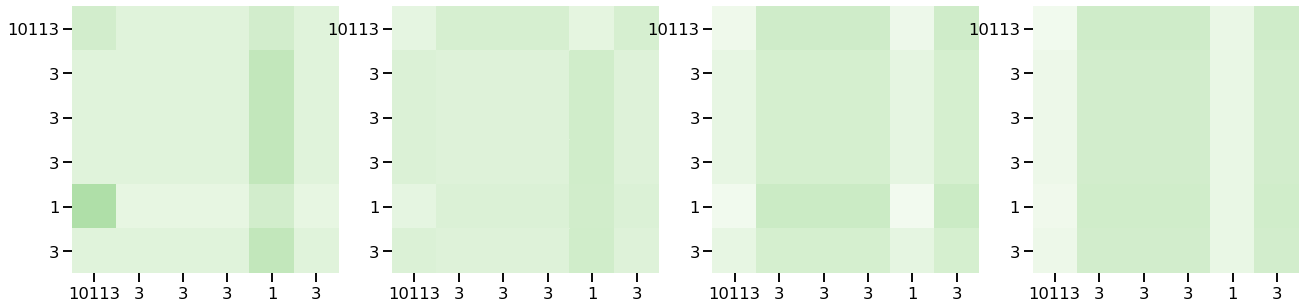



Ejemplo de tweet con label  SexualH  y tweet_id  1789
Encoder Layer 1


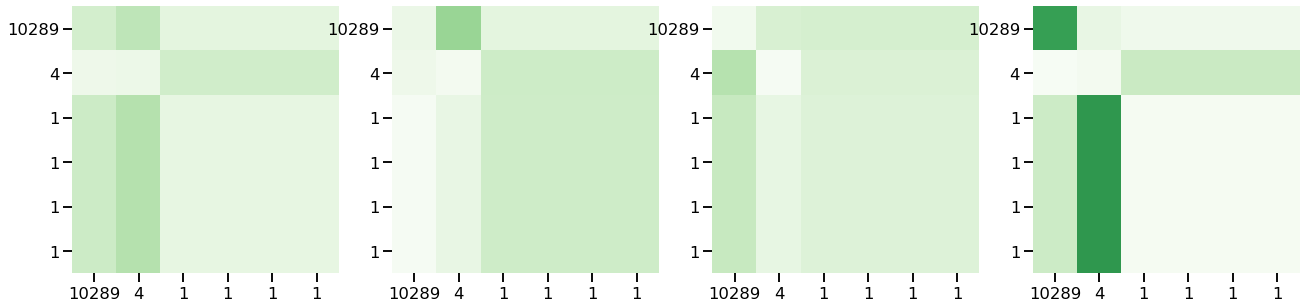

Encoder Layer 2


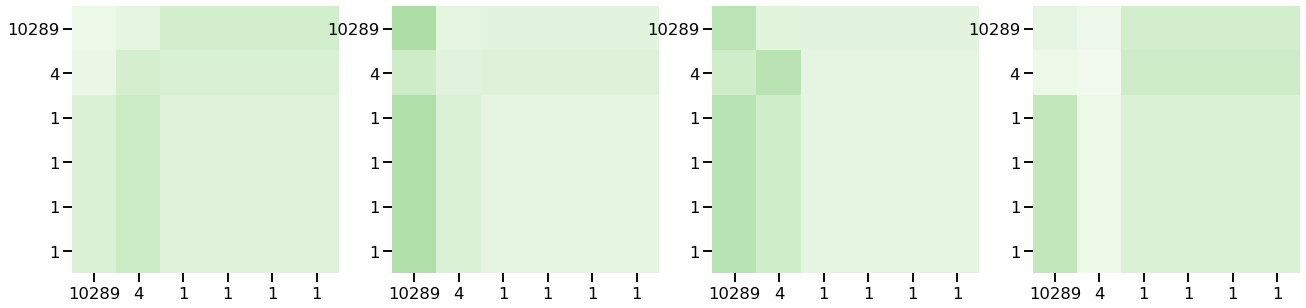

Entrenando Run # 8
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.096 	F-macro_val: 0.074
Epoch 10 	acc_val: 0.401 	F-macro_val: 0.274
Epoch 20 	acc_val: 0.743 	F-macro_val: 0.430
Epoch 30 	acc_val: 0.783 	F-macro_val: 0.443
Epoch 40 	acc_val: 0.814 	F-macro_val: 0.453
Epoch 50 	acc_val: 0.807 	F-macro_val: 0.450
Testing run # 8
SE TUVIERON QUE REPETIR 21 EJEMPLOS


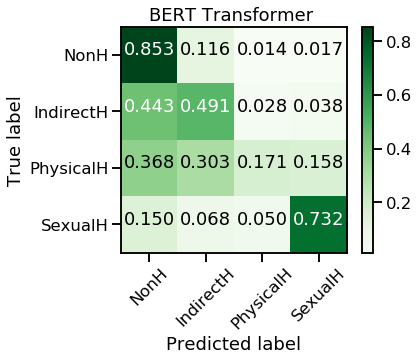

Test_ acc: 0.7913330193122939
Test_ f1 none: [0.883 0.267 0.198 0.788]
Test_ f1 macro: 0.5340998673454536


Ejemplo de tweet con label  NonH  y tweet_id  368
Encoder Layer 1


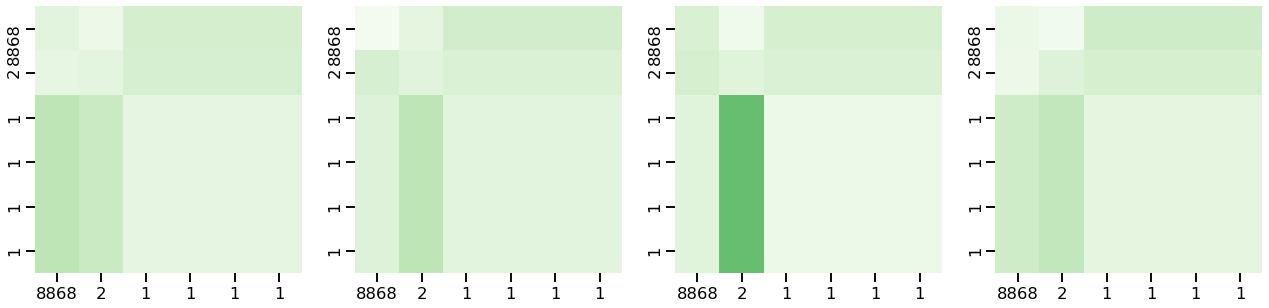

Encoder Layer 2


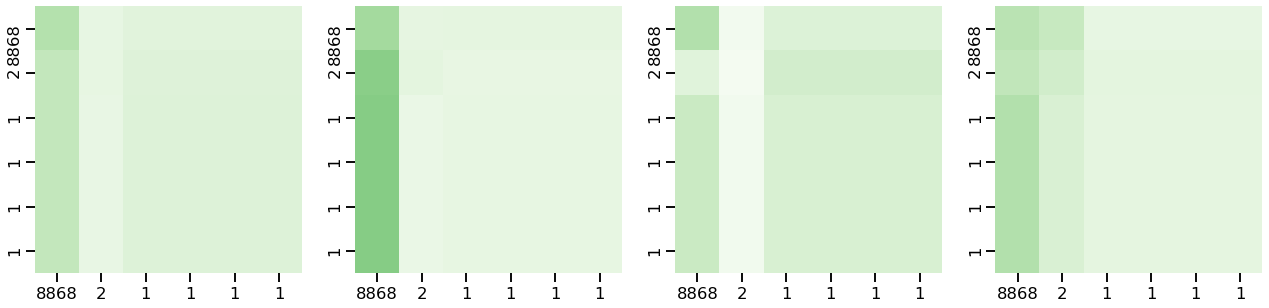



Ejemplo de tweet con label  IndirectH  y tweet_id  1750
Encoder Layer 1


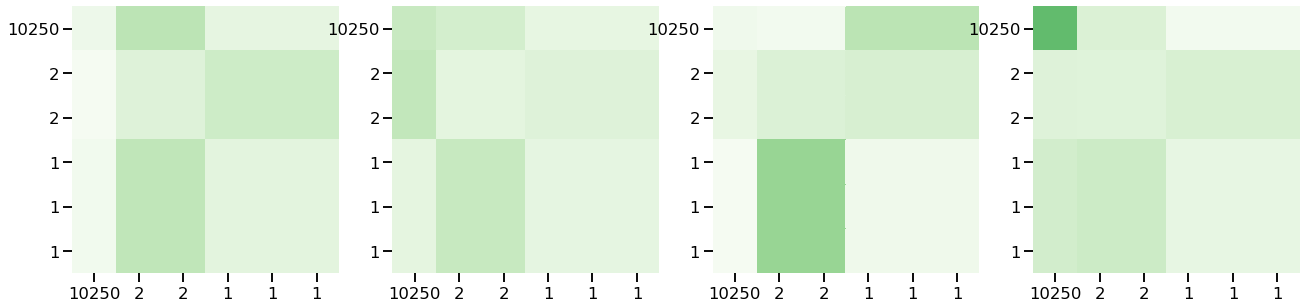

Encoder Layer 2


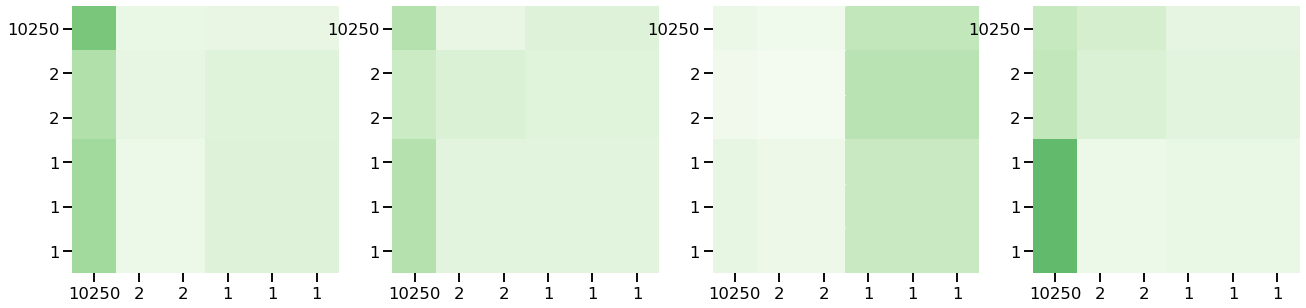



Ejemplo de tweet con label  PhysicalH  y tweet_id  2011
Encoder Layer 1


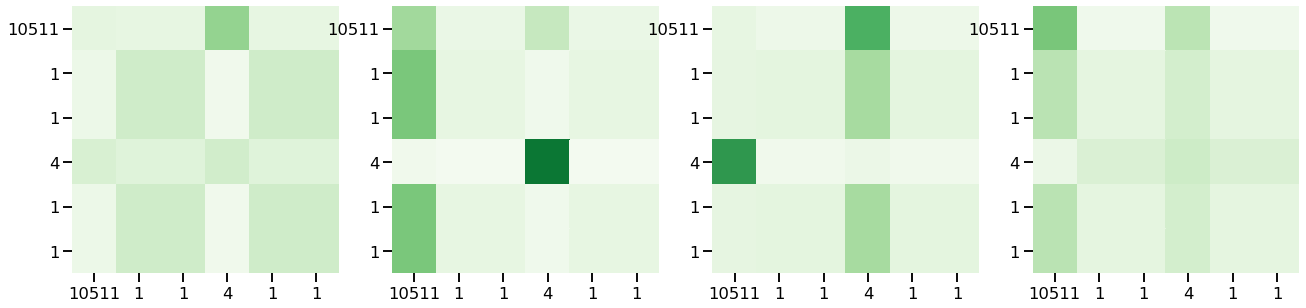

Encoder Layer 2


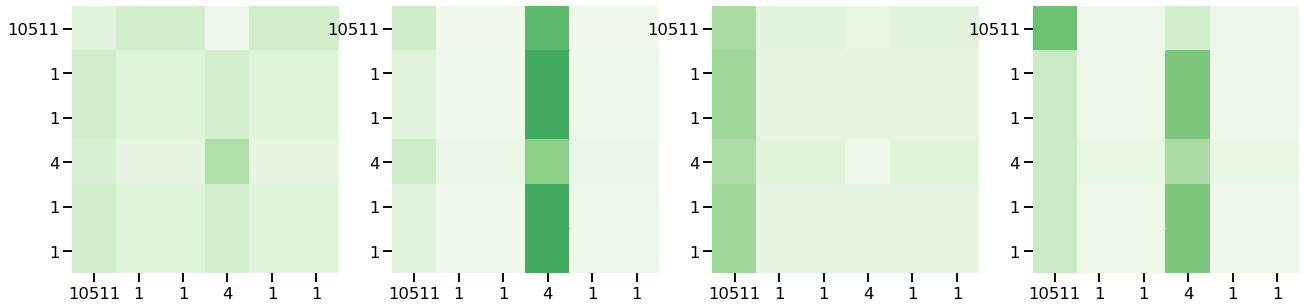



Ejemplo de tweet con label  SexualH  y tweet_id  1885
Encoder Layer 1


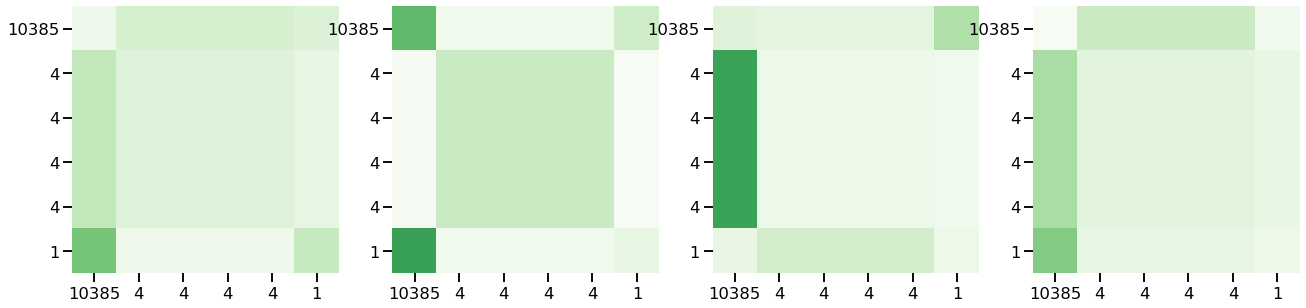

Encoder Layer 2


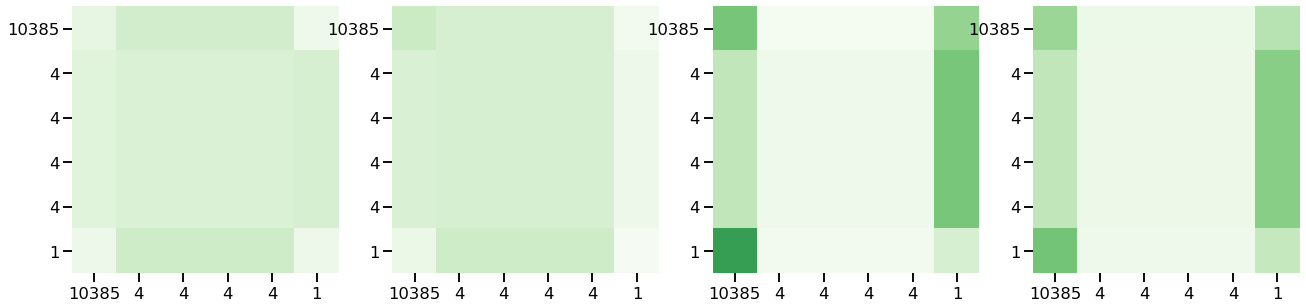

Entrenando Run # 9
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.175 	F-macro_val: 0.083
Epoch 10 	acc_val: 0.869 	F-macro_val: 0.419
Epoch 20 	acc_val: 0.886 	F-macro_val: 0.438
Epoch 30 	acc_val: 0.884 	F-macro_val: 0.442
Epoch 40 	acc_val: 0.884 	F-macro_val: 0.442
Epoch 50 	acc_val: 0.882 	F-macro_val: 0.444
Testing run # 9
SE TUVIERON QUE REPETIR 21 EJEMPLOS


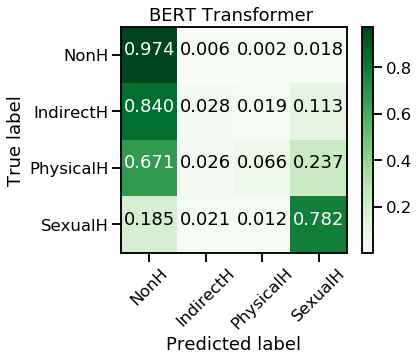

Test_ acc: 0.8638718794159209
Test_ f1 none: [0.927 0.047 0.111 0.8  ]
Test_ f1 macro: 0.4714556266079107
Entrenando Run # 10
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.353 	F-macro_val: 0.195
Epoch 10 	acc_val: 0.681 	F-macro_val: 0.351
Epoch 20 	acc_val: 0.844 	F-macro_val: 0.444
Epoch 30 	acc_val: 0.843 	F-macro_val: 0.449
Epoch 40 	acc_val: 0.850 	F-macro_val: 0.442
Epoch 50 	acc_val: 0.854 	F-macro_val: 0.449
Testing run # 10
SE TUVIERON QUE REPETIR 21 EJEMPLOS


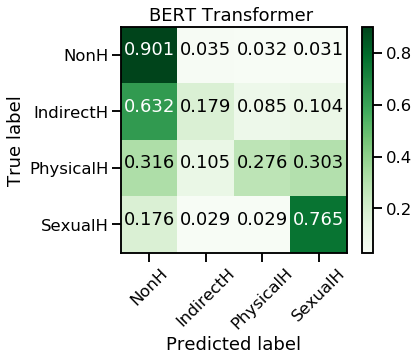

Test_ acc: 0.8210080075365049
Test_ f1 none: [0.903 0.191 0.25  0.76 ]
Test_ f1 macro: 0.5261187692436319
Entrenando Run # 11
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.662 	F-macro_val: 0.366
Epoch 10 	acc_val: 0.839 	F-macro_val: 0.461
Epoch 20 	acc_val: 0.847 	F-macro_val: 0.459
Epoch 30 	acc_val: 0.832 	F-macro_val: 0.463
Epoch 40 	acc_val: 0.853 	F-macro_val: 0.462
Epoch 50 	acc_val: 0.864 	F-macro_val: 0.466
Testing run # 11
SE TUVIERON QUE REPETIR 21 EJEMPLOS


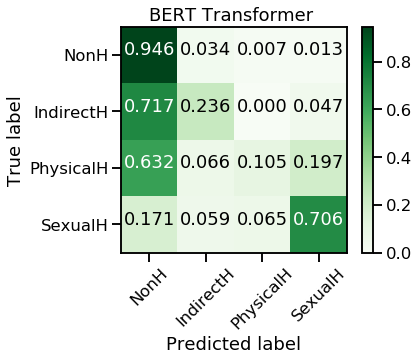

Test_ acc: 0.8417333961375412
Test_ f1 none: [0.918 0.238 0.136 0.773]
Test_ f1 macro: 0.5162614986775157
Entrenando Run # 12
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.333 	F-macro_val: 0.212
Epoch 10 	acc_val: 0.760 	F-macro_val: 0.420
Epoch 20 	acc_val: 0.824 	F-macro_val: 0.431
Epoch 30 	acc_val: 0.867 	F-macro_val: 0.428
Epoch 40 	acc_val: 0.869 	F-macro_val: 0.437
Epoch 50 	acc_val: 0.877 	F-macro_val: 0.440
Testing run # 12
SE TUVIERON QUE REPETIR 21 EJEMPLOS


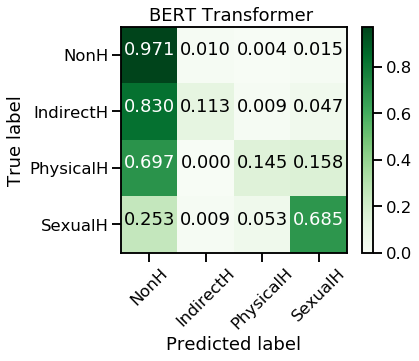

Test_ acc: 0.8530381535562883
Test_ f1 none: [0.919 0.175 0.196 0.759]
Test_ f1 macro: 0.5124677755570218
Entrenando Run # 13
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.256 	F-macro_val: 0.133
Epoch 10 	acc_val: 0.583 	F-macro_val: 0.360
Epoch 20 	acc_val: 0.750 	F-macro_val: 0.426
Epoch 30 	acc_val: 0.867 	F-macro_val: 0.454
Epoch 40 	acc_val: 0.875 	F-macro_val: 0.452
Epoch 50 	acc_val: 0.878 	F-macro_val: 0.451
Testing run # 13
SE TUVIERON QUE REPETIR 21 EJEMPLOS


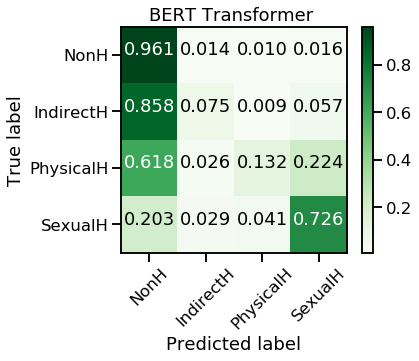

Test_ acc: 0.8492699010833726
Test_ f1 none: [0.919 0.108 0.171 0.778]
Test_ f1 macro: 0.4940769174353993
Entrenando Run # 14
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.157 	F-macro_val: 0.099
Epoch 10 	acc_val: 0.703 	F-macro_val: 0.356
Epoch 20 	acc_val: 0.835 	F-macro_val: 0.444
Epoch 30 	acc_val: 0.856 	F-macro_val: 0.449
Epoch 40 	acc_val: 0.857 	F-macro_val: 0.439
Epoch 50 	acc_val: 0.857 	F-macro_val: 0.445
Testing run # 14
SE TUVIERON QUE REPETIR 21 EJEMPLOS


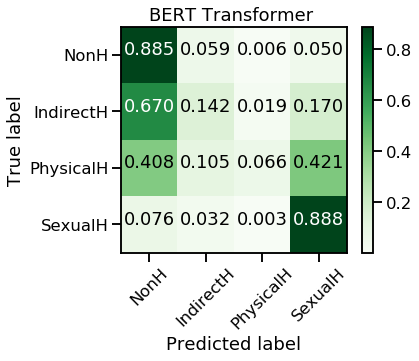

Test_ acc: 0.8191238813000471
Test_ f1 none: [0.901 0.128 0.106 0.782]
Test_ f1 macro: 0.4794494932246609
Entrenando Run # 15
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.076 	F-macro_val: 0.052
Epoch 10 	acc_val: 0.738 	F-macro_val: 0.389
Epoch 20 	acc_val: 0.831 	F-macro_val: 0.415
Epoch 30 	acc_val: 0.833 	F-macro_val: 0.450
Epoch 40 	acc_val: 0.848 	F-macro_val: 0.450
Epoch 50 	acc_val: 0.857 	F-macro_val: 0.455
Testing run # 15
SE TUVIERON QUE REPETIR 21 EJEMPLOS


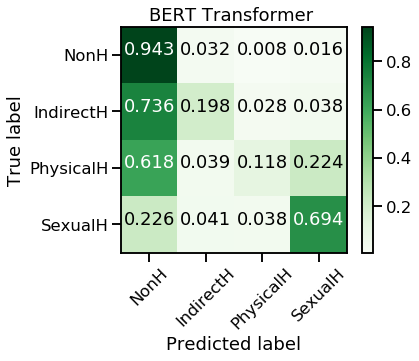

Test_ acc: 0.8365520489872822
Test_ f1 none: [0.912 0.214 0.158 0.758]
Test_ f1 macro: 0.5103413420921435
Entrenando Run # 16
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.132 	F-macro_val: 0.101
Epoch 10 	acc_val: 0.700 	F-macro_val: 0.391
Epoch 20 	acc_val: 0.861 	F-macro_val: 0.438
Epoch 30 	acc_val: 0.859 	F-macro_val: 0.436
Epoch 40 	acc_val: 0.864 	F-macro_val: 0.440
Epoch 50 	acc_val: 0.861 	F-macro_val: 0.439
Testing run # 16
SE TUVIERON QUE REPETIR 21 EJEMPLOS


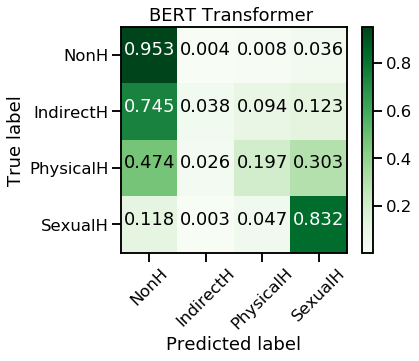

Test_ acc: 0.8605746585021197
Test_ f1 none: [0.93  0.067 0.231 0.791]
Test_ f1 macro: 0.5045233876508491
Entrenando Run # 17
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.189 	F-macro_val: 0.107
Epoch 10 	acc_val: 0.728 	F-macro_val: 0.347
Epoch 20 	acc_val: 0.848 	F-macro_val: 0.438
Epoch 30 	acc_val: 0.862 	F-macro_val: 0.445
Epoch 40 	acc_val: 0.859 	F-macro_val: 0.449
Epoch 50 	acc_val: 0.859 	F-macro_val: 0.453
Testing run # 17
SE TUVIERON QUE REPETIR 21 EJEMPLOS


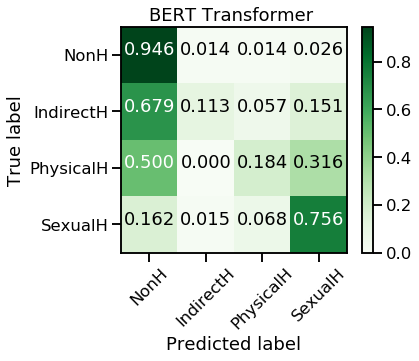

Test_ acc: 0.8464437117286858
Test_ f1 none: [0.923 0.164 0.197 0.758]
Test_ f1 macro: 0.5107123715844956
Entrenando Run # 18
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.271 	F-macro_val: 0.143
Epoch 10 	acc_val: 0.873 	F-macro_val: 0.436
Epoch 20 	acc_val: 0.881 	F-macro_val: 0.445
Epoch 30 	acc_val: 0.876 	F-macro_val: 0.452
Epoch 40 	acc_val: 0.879 	F-macro_val: 0.455
Epoch 50 	acc_val: 0.877 	F-macro_val: 0.450
Testing run # 18
SE TUVIERON QUE REPETIR 21 EJEMPLOS


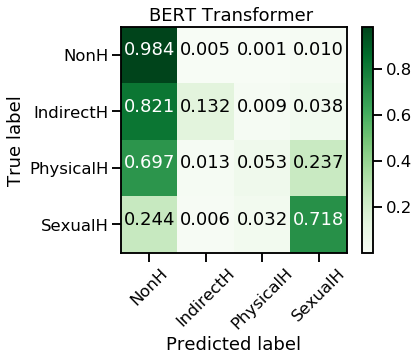

Test_ acc: 0.8652849740932642
Test_ f1 none: [0.927 0.214 0.085 0.785]
Test_ f1 macro: 0.5025389792863932
Entrenando Run # 19
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.050 	F-macro_val: 0.050
Epoch 10 	acc_val: 0.442 	F-macro_val: 0.253
Epoch 20 	acc_val: 0.784 	F-macro_val: 0.412
Epoch 30 	acc_val: 0.813 	F-macro_val: 0.443
Epoch 40 	acc_val: 0.840 	F-macro_val: 0.454
Epoch 50 	acc_val: 0.850 	F-macro_val: 0.465
Testing run # 19
SE TUVIERON QUE REPETIR 21 EJEMPLOS


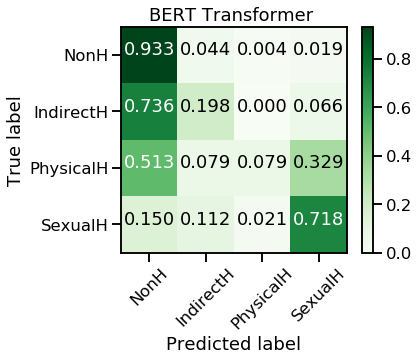

Test_ acc: 0.8308996702779087
Test_ f1 none: [0.915 0.174 0.126 0.754]
Test_ f1 macro: 0.4923773066447642
Entrenando Run # 20
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.327 	F-macro_val: 0.189
Epoch 10 	acc_val: 0.811 	F-macro_val: 0.420
Epoch 20 	acc_val: 0.860 	F-macro_val: 0.462
Epoch 30 	acc_val: 0.861 	F-macro_val: 0.458
Epoch 40 	acc_val: 0.864 	F-macro_val: 0.462
Epoch 50 	acc_val: 0.864 	F-macro_val: 0.460
Testing run # 20
SE TUVIERON QUE REPETIR 21 EJEMPLOS


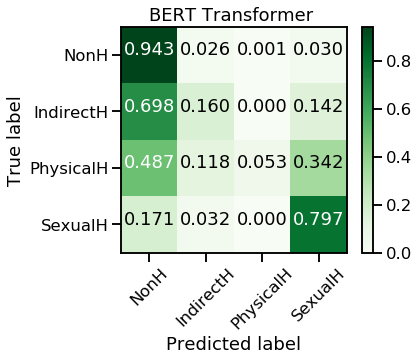

Test_ acc: 0.8483278379651437
Test_ f1 none: [0.92  0.184 0.098 0.774]
Test_ f1 macro: 0.4940082588589718


In [31]:
best_0cw, all_accs_0cw, all_fno_0cw, all_ma_0cw, all_cm_0cw =train_transformer(0.0, 60, path_a, path_m, "Greens", class_weights=class_weights)

In [32]:
print ("best_0cw", best_0cw)
print ("all_accs_0cw", all_accs_0cw)
print ("all_fno_0cw", all_fno_0cw)
print ("all_ma_0cw", all_ma_0cw)

best_0cw {'F_ma': 0.5340998673454536, 'Run': 8}
all_accs_0cw [0.7979274611398963, 0.8341968911917098, 0.7691945360339143, 0.8487988695242581, 0.6867640131888837, 0.8243052284503062, 0.8389072067828545, 0.7913330193122939, 0.8638718794159209, 0.8210080075365049, 0.8417333961375412, 0.8530381535562883, 0.8492699010833726, 0.8191238813000471, 0.8365520489872822, 0.8605746585021197, 0.8464437117286858, 0.8652849740932642, 0.8308996702779087, 0.8483278379651437]
all_fno_0cw [array([0.901, 0.185, 0.211, 0.742]), array([0.908, 0.254, 0.133, 0.719]), array([0.879, 0.141, 0.122, 0.779]), array([0.92 , 0.194, 0.071, 0.771]), array([0.801, 0.185, 0.184, 0.741]), array([0.901, 0.145, 0.069, 0.791]), array([0.917, 0.167, 0.224, 0.765]), array([0.883, 0.267, 0.198, 0.788]), array([0.927, 0.047, 0.111, 0.8  ]), array([0.903, 0.191, 0.25 , 0.76 ]), array([0.918, 0.238, 0.136, 0.773]), array([0.919, 0.175, 0.196, 0.759]), array([0.919, 0.108, 0.171, 0.778]), array([0.901, 0.128, 0.106, 0.782]), array([

Acc: 0.826 -- deviation: 0.040
F-score: 0.500 -- deviation: 0.017
(0.0cw) NIPS: 0.9062585026768716 0.1720412160978902 0.153829277536544 0.7683818474361361


Confusion counts
[[29431.  1630.   254.   705.]
 [ 1473.   417.    51.   179.]
 [  794.   128.   181.   417.]
 [ 1168.   359.   214.  5059.]]


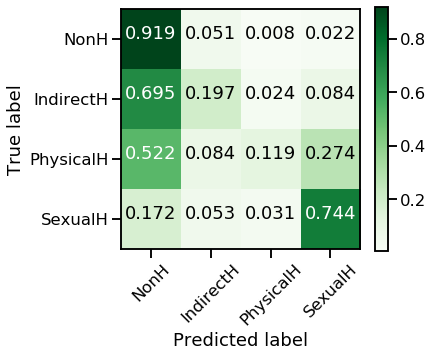

In [33]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs_0cw)), "-- deviation: %.3f" % np.std(np.asarray(all_accs_0cw)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma_0cw)), "-- deviation: %.3f" % np.std(np.asarray(all_ma_0cw)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno_0cw)[:,0])
den=np.mean(np.asarray(all_fno_0cw)[:,1])
que=np.mean(np.asarray(all_fno_0cw)[:,2])
com=np.mean(np.asarray(all_fno_0cw)[:,3])

print ("(0.0cw) NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm_0cw:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["NonH", "IndirectH", "PhysicalH", "SexualH"], "", cmap='Greens')

In [7]:
b=np.asarray([[29431.  ,1630.   ,254.  , 705.],
 [ 1473.  , 417.   , 51.  , 179.],
 [  794.  , 128.   ,181.  , 417.],
 [ 1168.  , 359.   ,214.  ,5059.]])

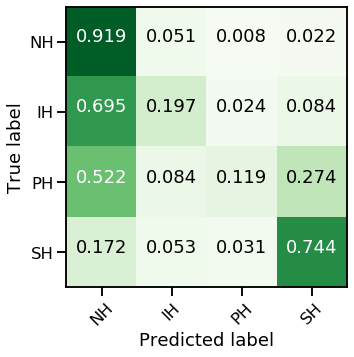

In [9]:
plot_cm(cm_norma(b),["NH", "IH", "PH", "SH"], "", cmap='Greens')

## Con aumento de datos

### 0.15

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 1
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.420 	F-macro_val: 0.227
Epoch 10 	acc_val: 0.882 	F-macro_val: 0.435
Epoch 20 	acc_val: 0.884 	F-macro_val: 0.437
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


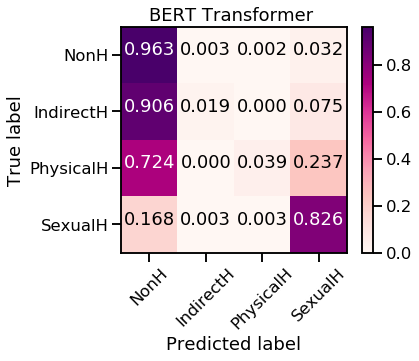

Test_ acc: 0.8605746585021197
Test_ f1 none: [0.92  0.035 0.072 0.804]
Test_ f1 macro: 0.45784564959635243


Ejemplo de tweet con label  NonH  y tweet_id  894
Encoder Layer 1


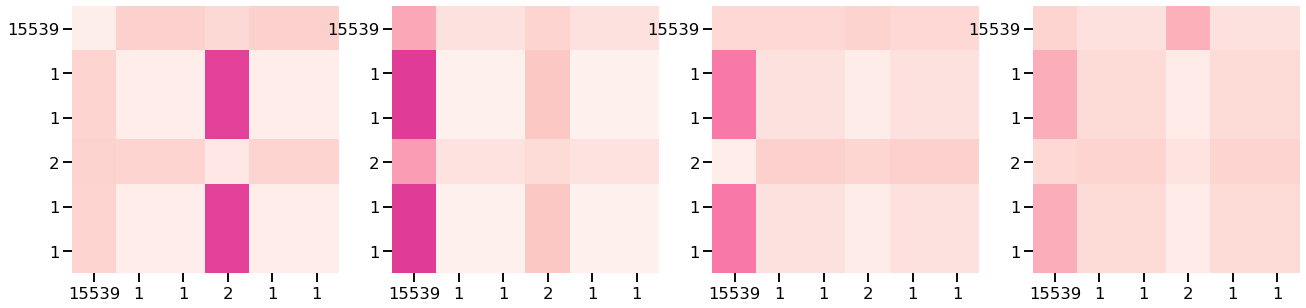

Encoder Layer 2


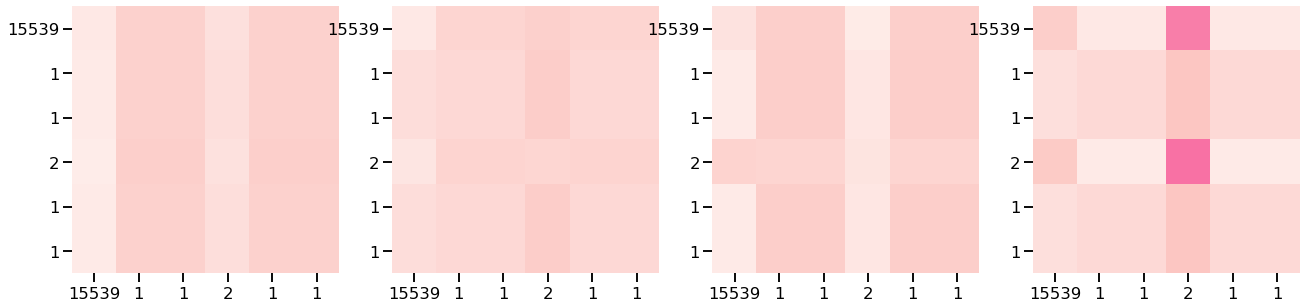



Ejemplo de tweet con label  IndirectH  y tweet_id  1722
Encoder Layer 1


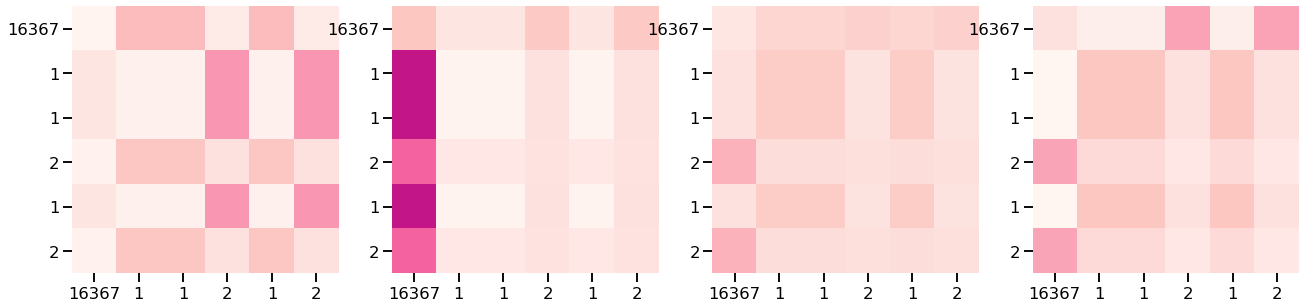

Encoder Layer 2


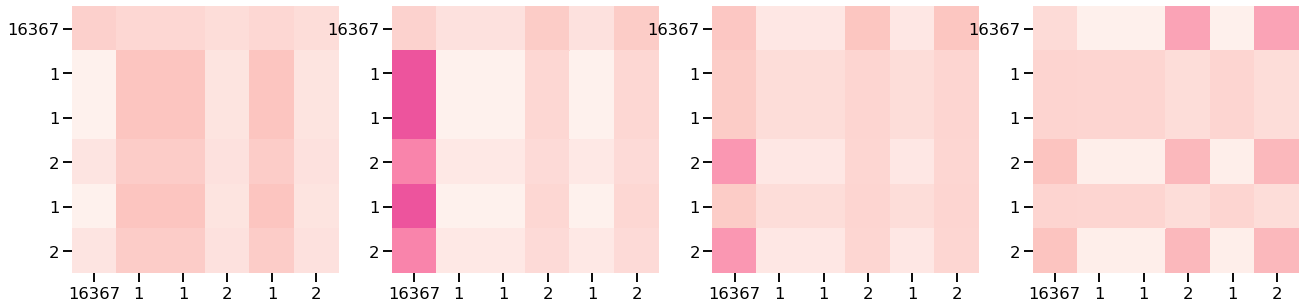



Ejemplo de tweet con label  PhysicalH  y tweet_id  1605
Encoder Layer 1


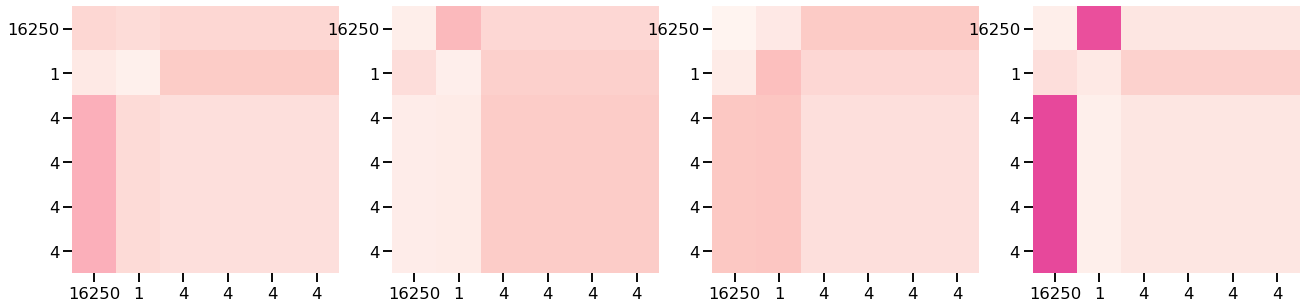

Encoder Layer 2


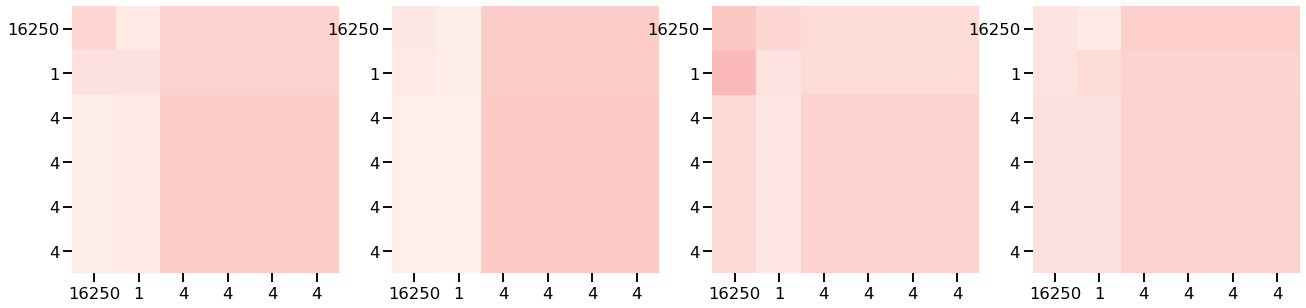



Ejemplo de tweet con label  SexualH  y tweet_id  1741
Encoder Layer 1


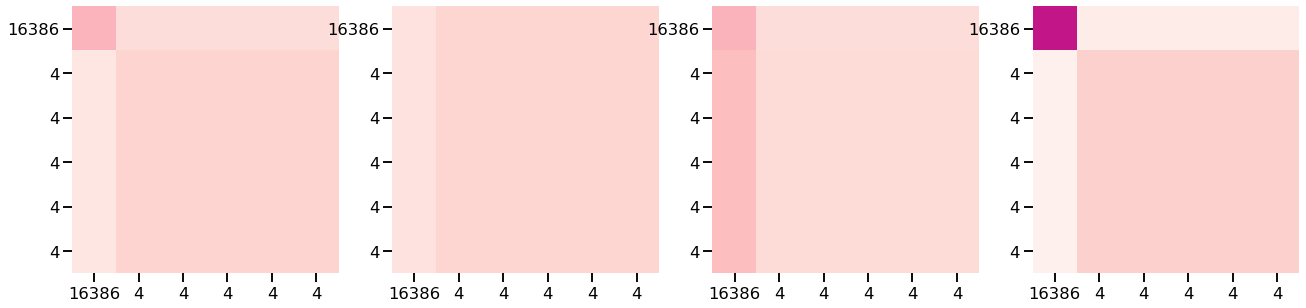

Encoder Layer 2


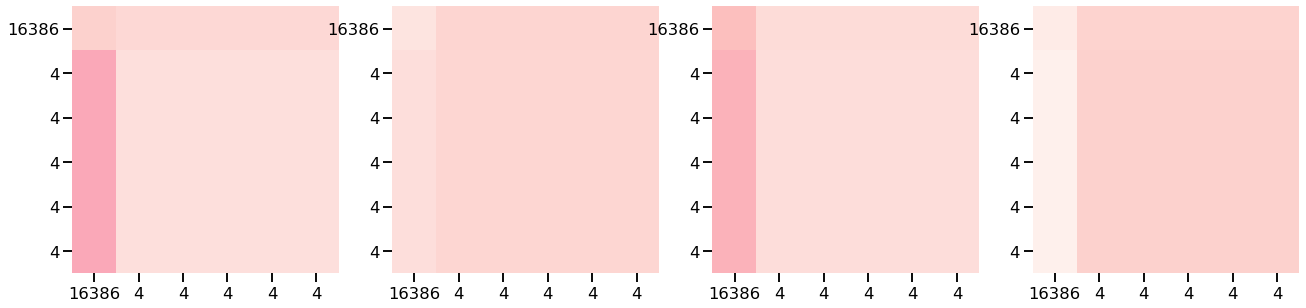

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 2
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.562 	F-macro_val: 0.253
Epoch 10 	acc_val: 0.872 	F-macro_val: 0.430
Epoch 20 	acc_val: 0.874 	F-macro_val: 0.432
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


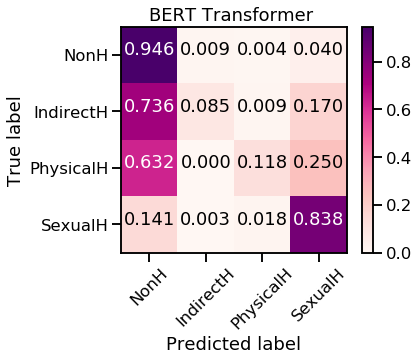

Test_ acc: 0.8563353744700894
Test_ f1 none: [0.921 0.137 0.182 0.785]
Test_ f1 macro: 0.5063298433224754


Ejemplo de tweet con label  NonH  y tweet_id  1709
Encoder Layer 1


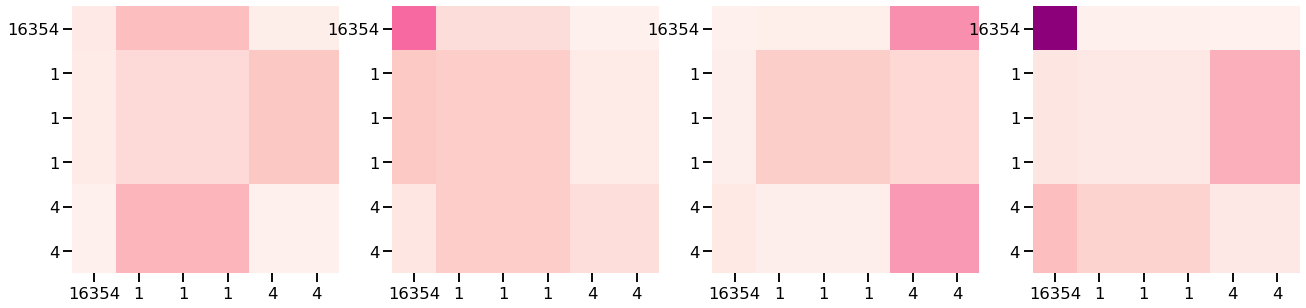

Encoder Layer 2


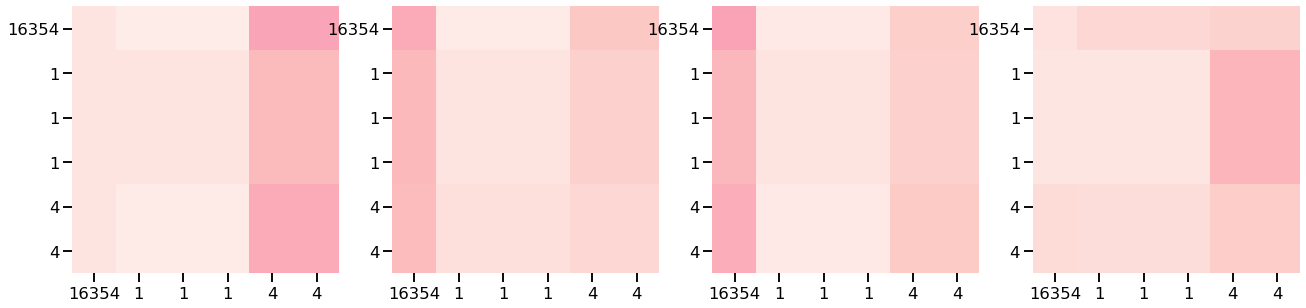



Ejemplo de tweet con label  IndirectH  y tweet_id  1287
Encoder Layer 1


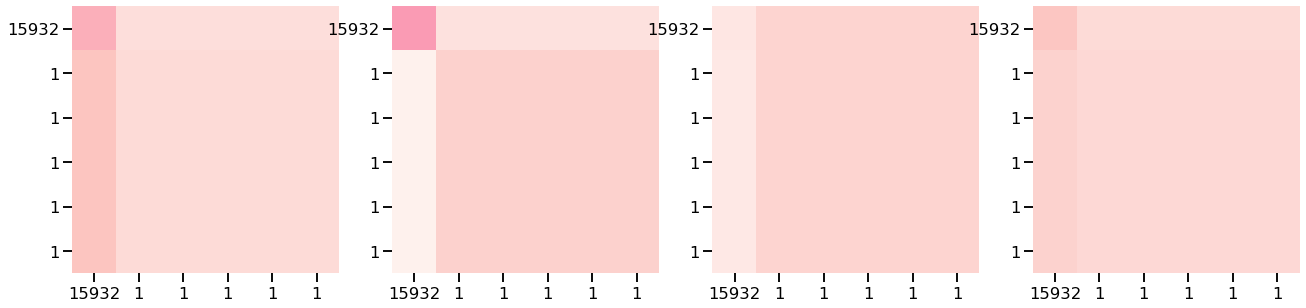

Encoder Layer 2


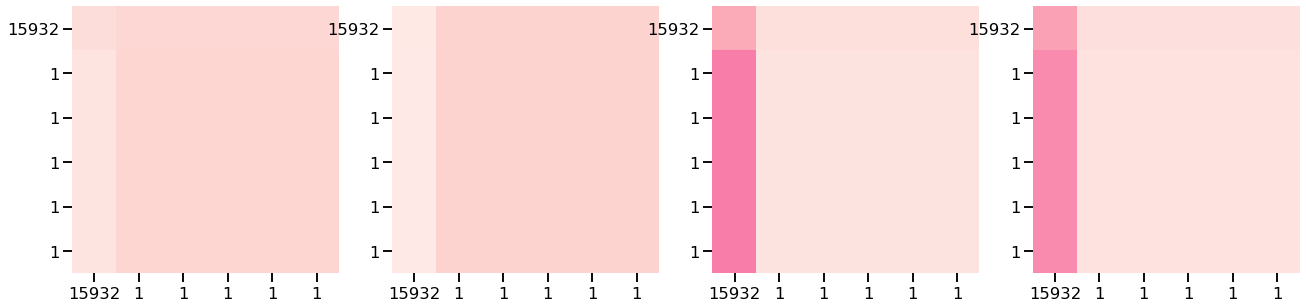



Ejemplo de tweet con label  PhysicalH  y tweet_id  97
Encoder Layer 1


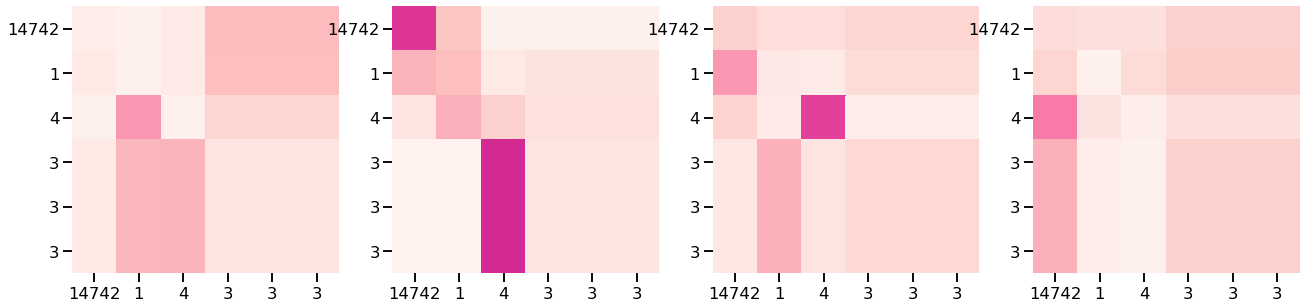

Encoder Layer 2


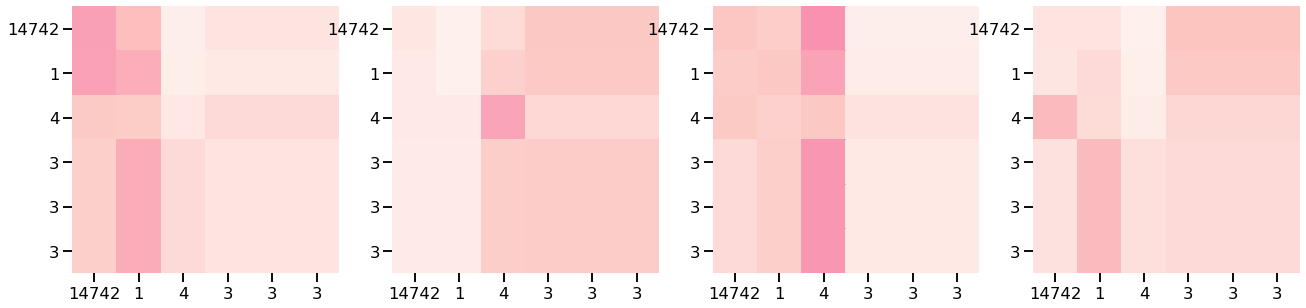



Ejemplo de tweet con label  SexualH  y tweet_id  1840
Encoder Layer 1


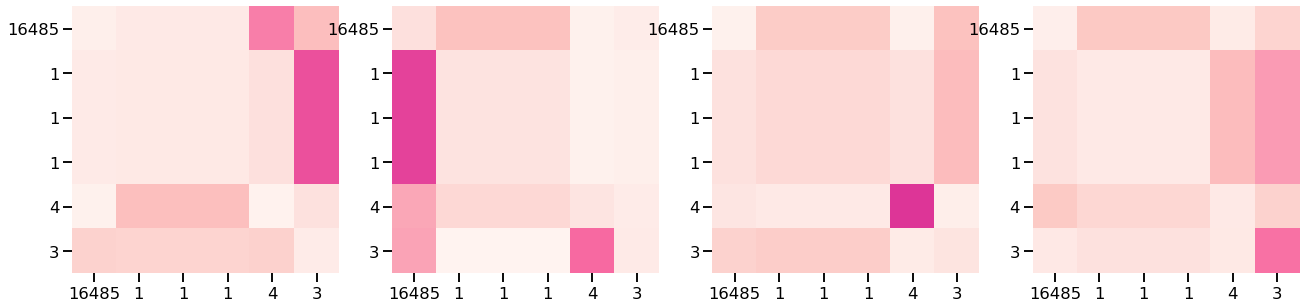

Encoder Layer 2


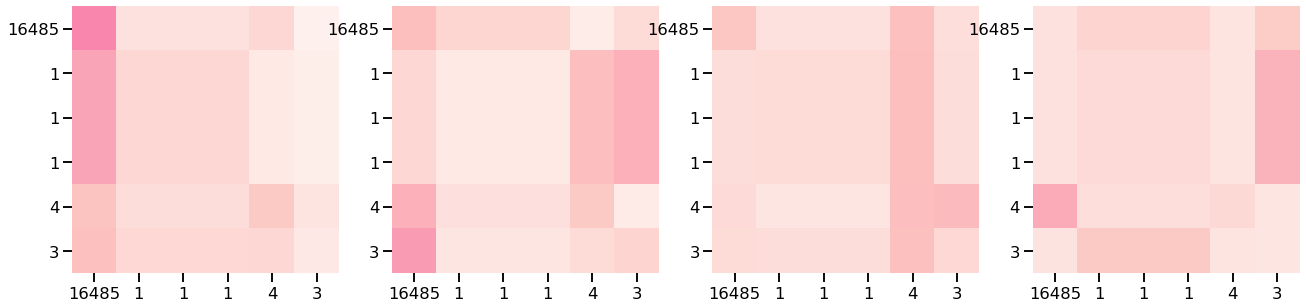

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 3
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.543 	F-macro_val: 0.236
Epoch 10 	acc_val: 0.882 	F-macro_val: 0.451
Epoch 20 	acc_val: 0.887 	F-macro_val: 0.445
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


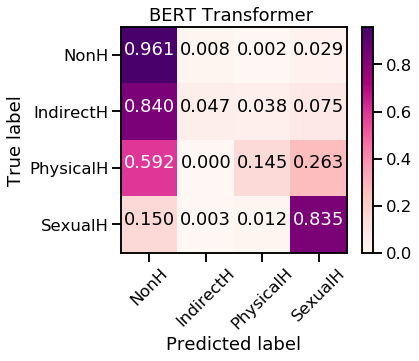

Test_ acc: 0.8657560056523788
Test_ f1 none: [0.925 0.08  0.224 0.813]
Test_ f1 macro: 0.5106175761080838


Ejemplo de tweet con label  NonH  y tweet_id  1748
Encoder Layer 1


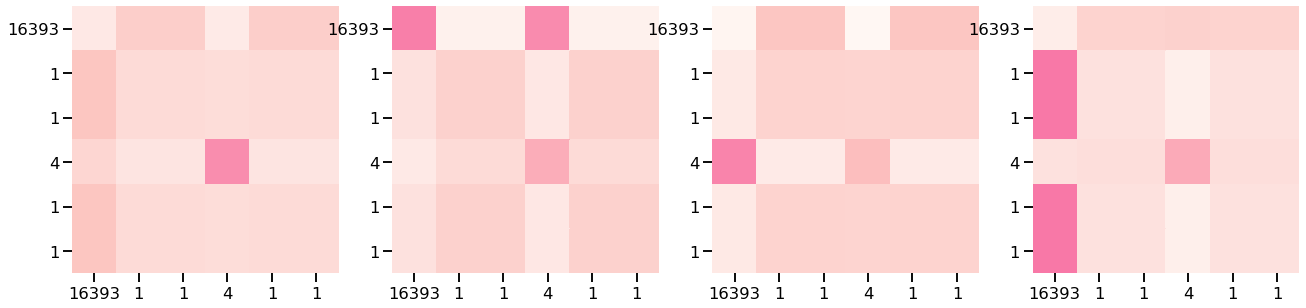

Encoder Layer 2


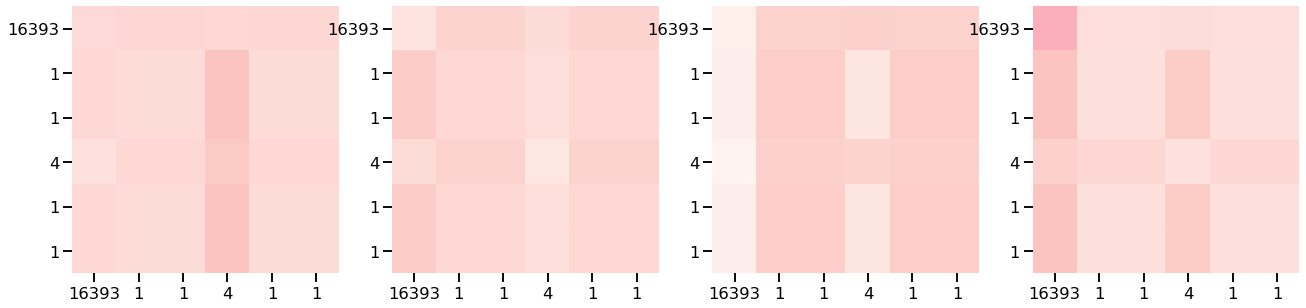



Ejemplo de tweet con label  IndirectH  y tweet_id  1513
Encoder Layer 1


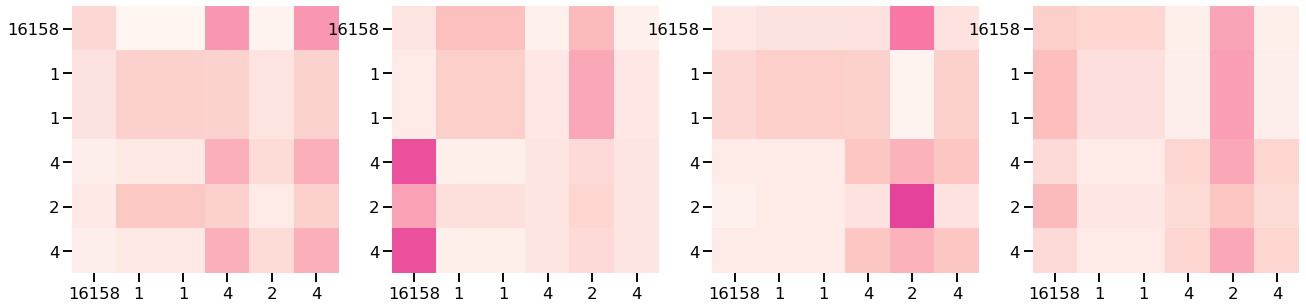

Encoder Layer 2


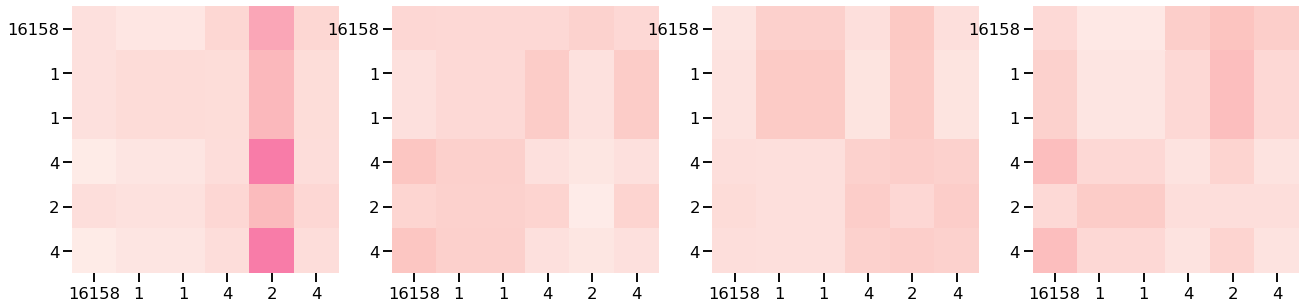



Ejemplo de tweet con label  PhysicalH  y tweet_id  200
Encoder Layer 1


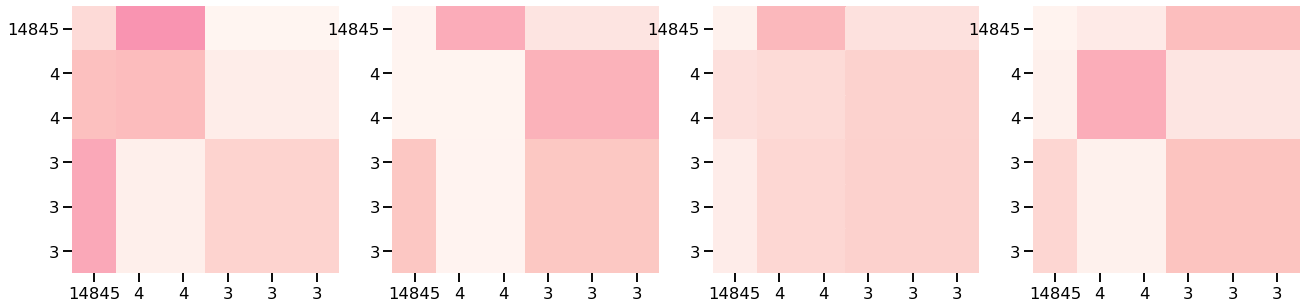

Encoder Layer 2


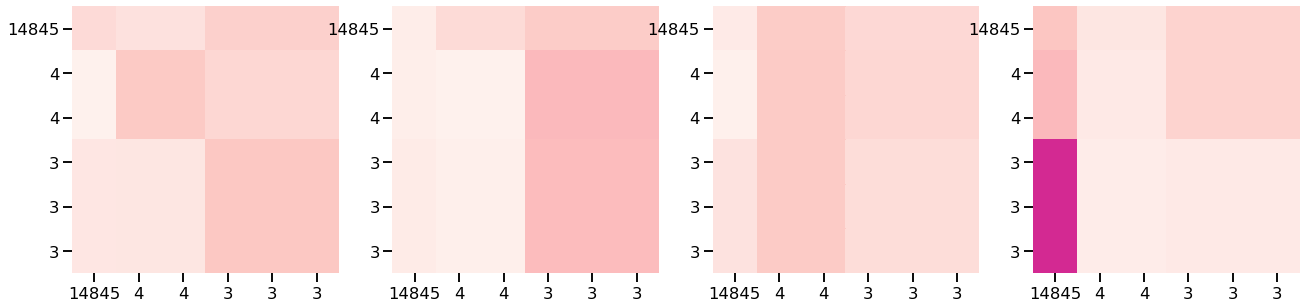



Ejemplo de tweet con label  SexualH  y tweet_id  2046
Encoder Layer 1


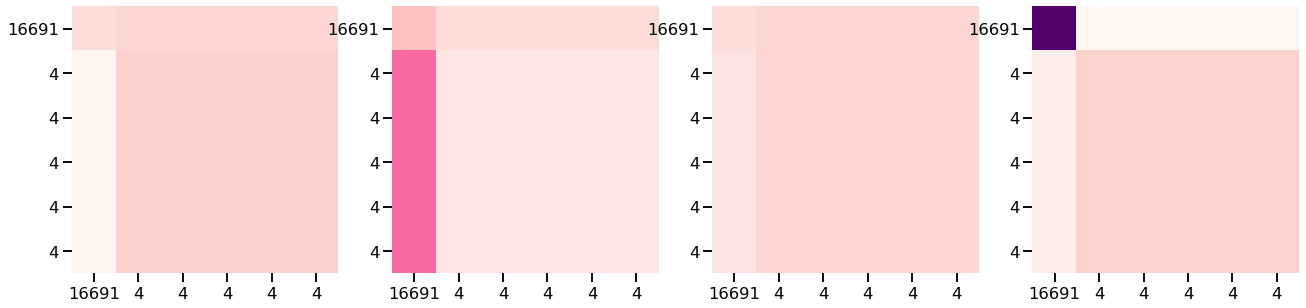

Encoder Layer 2


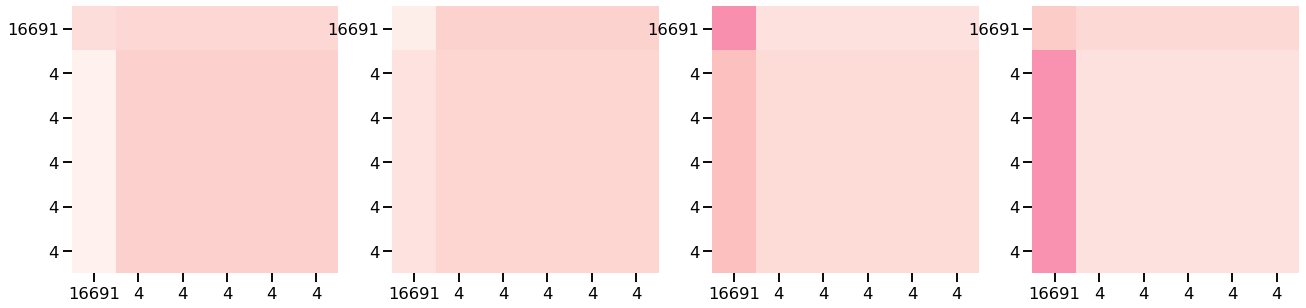

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 4
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.741 	F-macro_val: 0.356
Epoch 10 	acc_val: 0.877 	F-macro_val: 0.437
Epoch 20 	acc_val: 0.883 	F-macro_val: 0.438
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


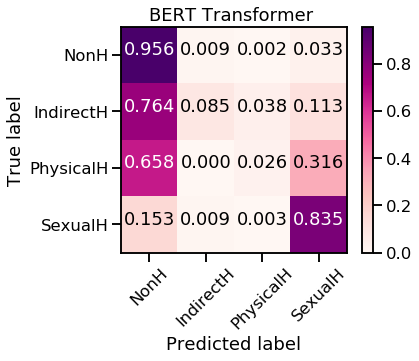

Test_ acc: 0.8601036269430051
Test_ f1 none: [0.924 0.136 0.047 0.797]
Test_ f1 macro: 0.47579736167297065
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 5
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.099 	F-macro_val: 0.085
Epoch 10 	acc_val: 0.885 	F-macro_val: 0.443
Epoch 20 	acc_val: 0.888 	F-macro_val: 0.444
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


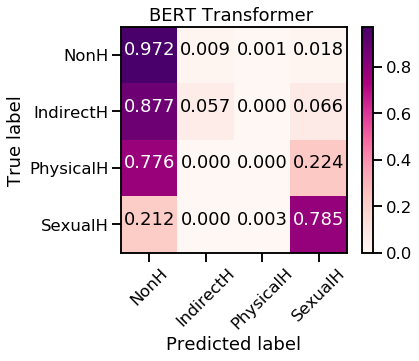

Test_ acc: 0.8615167216203485
Test_ f1 none: [0.92  0.094 0.    0.809]
Test_ f1 macro: 0.45600420959520094
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 6
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.562 	F-macro_val: 0.201
Epoch 10 	acc_val: 0.883 	F-macro_val: 0.439
Epoch 20 	acc_val: 0.884 	F-macro_val: 0.438
Testing run # 6
SE TUVIERON QUE REPETIR 21 EJEMPLOS


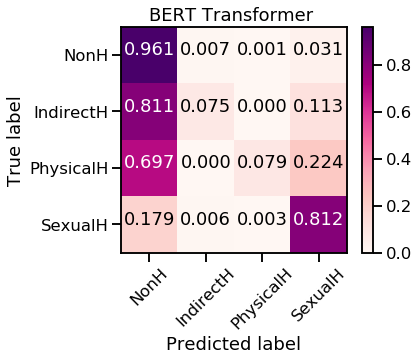

Test_ acc: 0.8615167216203485
Test_ f1 none: [0.922 0.126 0.141 0.795]
Test_ f1 macro: 0.49602666444390964
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 7
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.582 	F-macro_val: 0.309
Epoch 10 	acc_val: 0.886 	F-macro_val: 0.447
Epoch 20 	acc_val: 0.886 	F-macro_val: 0.444
Testing run # 7
SE TUVIERON QUE REPETIR 21 EJEMPLOS


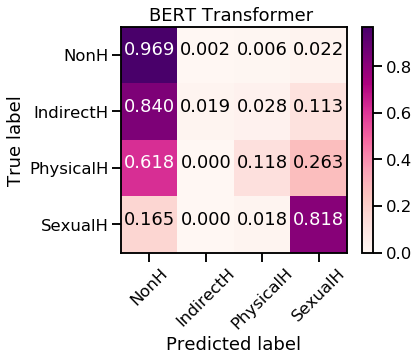

Test_ acc: 0.867169100329722
Test_ f1 none: [0.928 0.036 0.173 0.81 ]
Test_ f1 macro: 0.48689018833729186
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 8
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.411 	F-macro_val: 0.275
Epoch 10 	acc_val: 0.882 	F-macro_val: 0.440
Epoch 20 	acc_val: 0.882 	F-macro_val: 0.440
Testing run # 8
SE TUVIERON QUE REPETIR 21 EJEMPLOS


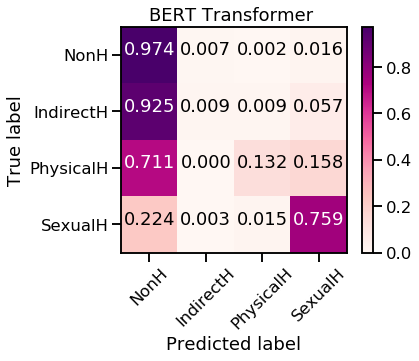

Test_ acc: 0.8615167216203485
Test_ f1 none: [0.921 0.017 0.208 0.804]
Test_ f1 macro: 0.48737598175999175
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 9
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.344 	F-macro_val: 0.205
Epoch 10 	acc_val: 0.885 	F-macro_val: 0.439
Epoch 20 	acc_val: 0.886 	F-macro_val: 0.437
Testing run # 9
SE TUVIERON QUE REPETIR 21 EJEMPLOS


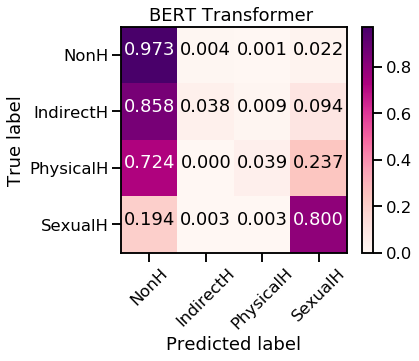

Test_ acc: 0.8648139425341498
Test_ f1 none: [0.924 0.068 0.072 0.806]
Test_ f1 macro: 0.4675118252576322
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 10
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.737 	F-macro_val: 0.394
Epoch 10 	acc_val: 0.880 	F-macro_val: 0.445
Epoch 20 	acc_val: 0.882 	F-macro_val: 0.443
Testing run # 10
SE TUVIERON QUE REPETIR 21 EJEMPLOS


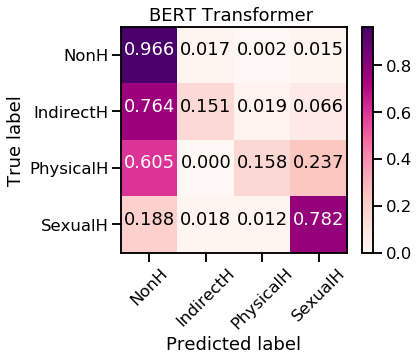

Test_ acc: 0.8666980687706076
Test_ f1 none: [0.926 0.206 0.245 0.812]
Test_ f1 macro: 0.5474666220247847


Ejemplo de tweet con label  NonH  y tweet_id  226
Encoder Layer 1


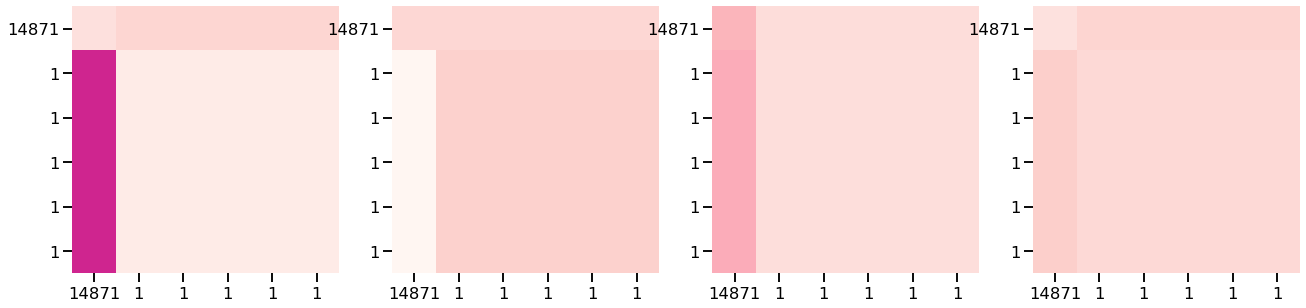

Encoder Layer 2


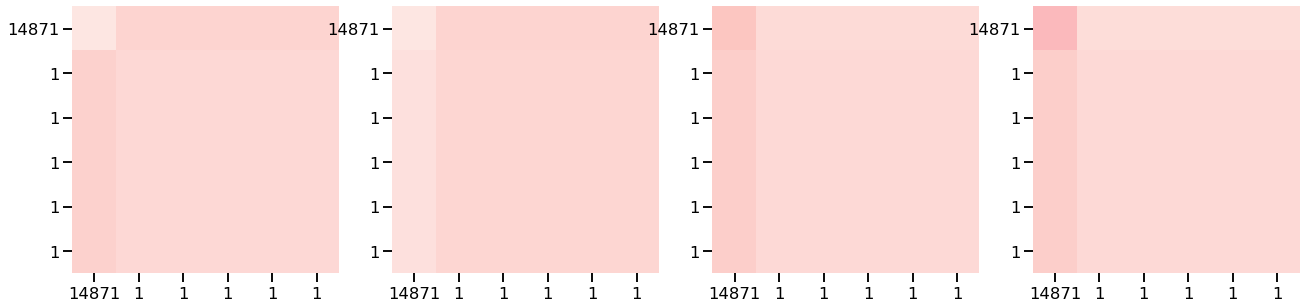



Ejemplo de tweet con label  IndirectH  y tweet_id  819
Encoder Layer 1


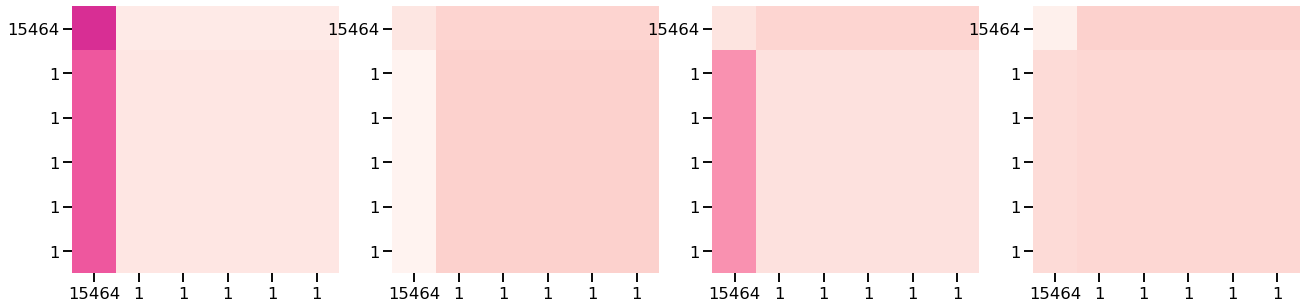

Encoder Layer 2


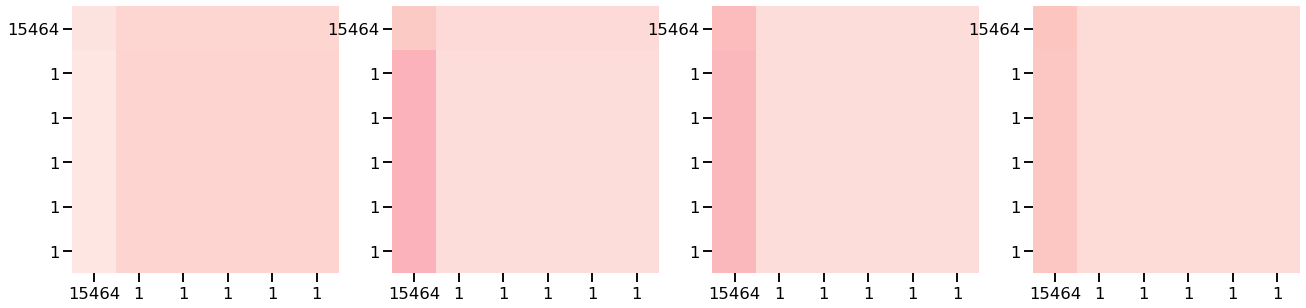



Ejemplo de tweet con label  PhysicalH  y tweet_id  456
Encoder Layer 1


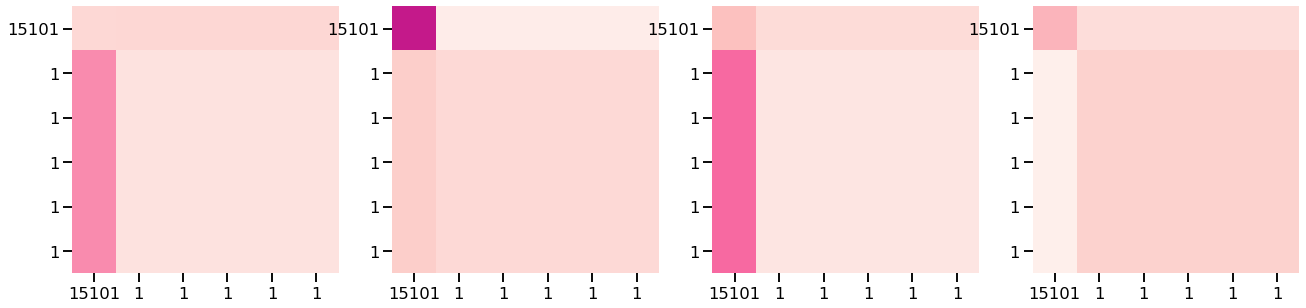

Encoder Layer 2


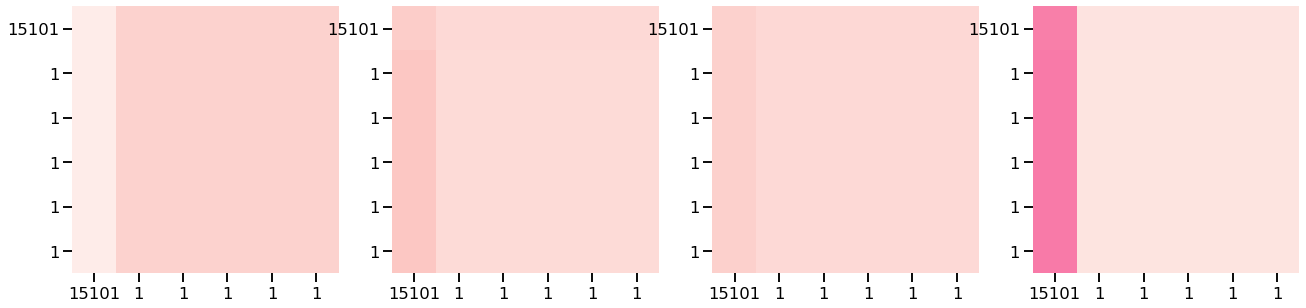



Ejemplo de tweet con label  SexualH  y tweet_id  764
Encoder Layer 1


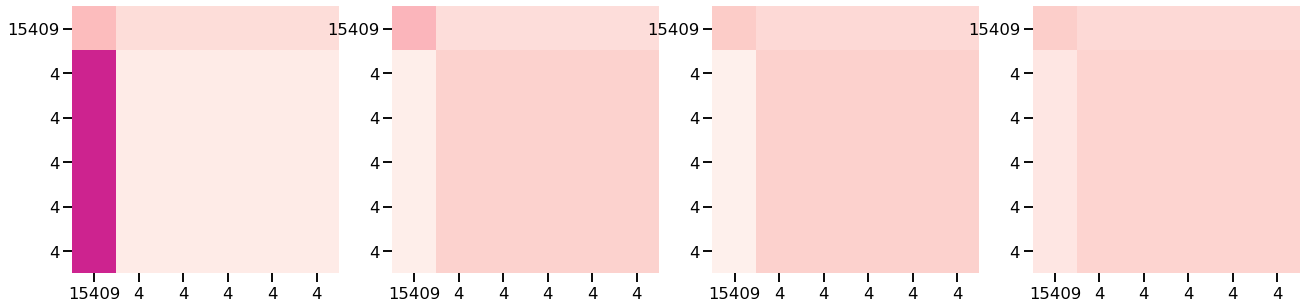

Encoder Layer 2


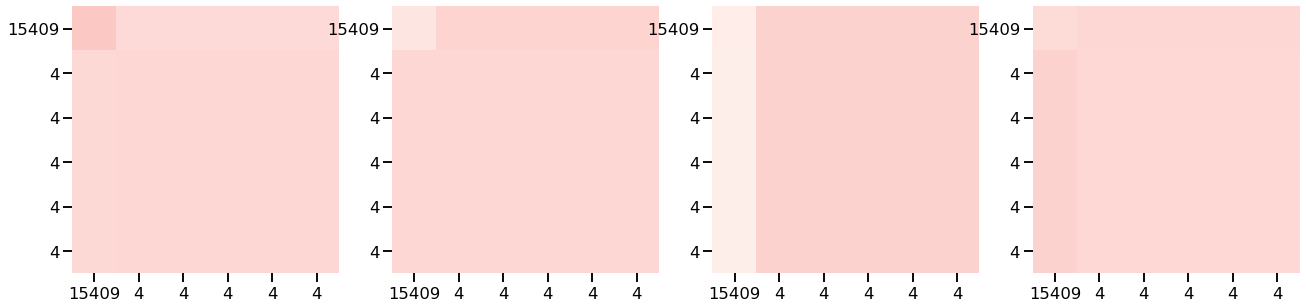

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 11
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.254 	F-macro_val: 0.165
Epoch 10 	acc_val: 0.868 	F-macro_val: 0.434
Epoch 20 	acc_val: 0.870 	F-macro_val: 0.436
Testing run # 11
SE TUVIERON QUE REPETIR 21 EJEMPLOS


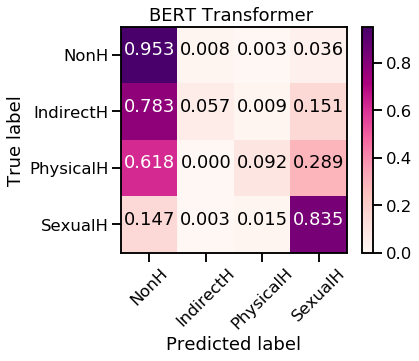

Test_ acc: 0.8582195007065473
Test_ f1 none: [0.923 0.095 0.149 0.789]
Test_ f1 macro: 0.4889070469031468
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 12
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.056 	F-macro_val: 0.065
Epoch 10 	acc_val: 0.876 	F-macro_val: 0.432
Epoch 20 	acc_val: 0.880 	F-macro_val: 0.433
Testing run # 12
SE TUVIERON QUE REPETIR 21 EJEMPLOS


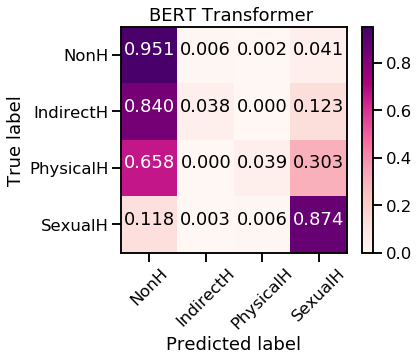

Test_ acc: 0.8601036269430051
Test_ f1 none: [0.922 0.066 0.071 0.805]
Test_ f1 macro: 0.46586188064817713
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 13
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.186 	F-macro_val: 0.137
Epoch 10 	acc_val: 0.884 	F-macro_val: 0.437
Epoch 20 	acc_val: 0.885 	F-macro_val: 0.437
Testing run # 13
SE TUVIERON QUE REPETIR 21 EJEMPLOS


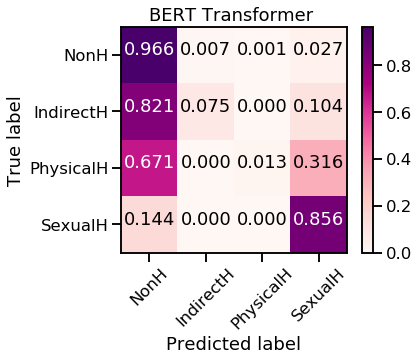

Test_ acc: 0.8695242581252944
Test_ f1 none: [0.927 0.128 0.026 0.821]
Test_ f1 macro: 0.4754825034559107
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 14
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.449 	F-macro_val: 0.216
Epoch 10 	acc_val: 0.883 	F-macro_val: 0.438
Epoch 20 	acc_val: 0.888 	F-macro_val: 0.440
Testing run # 14
SE TUVIERON QUE REPETIR 21 EJEMPLOS


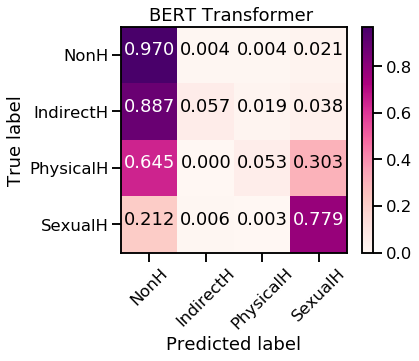

Test_ acc: 0.8610456900612341
Test_ f1 none: [0.922 0.099 0.089 0.796]
Test_ f1 macro: 0.47644838269382916
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 15
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.204 	F-macro_val: 0.122
Epoch 10 	acc_val: 0.881 	F-macro_val: 0.444
Epoch 20 	acc_val: 0.884 	F-macro_val: 0.443
Testing run # 15
SE TUVIERON QUE REPETIR 21 EJEMPLOS


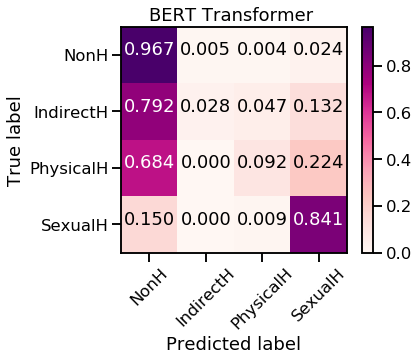

Test_ acc: 0.8685821950070655
Test_ f1 none: [0.928 0.051 0.143 0.823]
Test_ f1 macro: 0.4863045827074604
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 16
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.338 	F-macro_val: 0.184
Epoch 10 	acc_val: 0.876 	F-macro_val: 0.427
Epoch 20 	acc_val: 0.881 	F-macro_val: 0.431
Testing run # 16
SE TUVIERON QUE REPETIR 21 EJEMPLOS


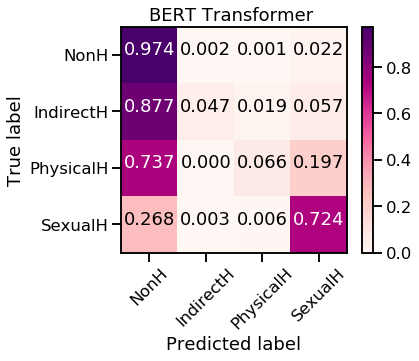

Test_ acc: 0.8553933113518606
Test_ f1 none: [0.917 0.086 0.115 0.766]
Test_ f1 macro: 0.4712204518654808
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 17
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.206 	F-macro_val: 0.141
Epoch 10 	acc_val: 0.885 	F-macro_val: 0.435
Epoch 20 	acc_val: 0.883 	F-macro_val: 0.434
Testing run # 17
SE TUVIERON QUE REPETIR 21 EJEMPLOS


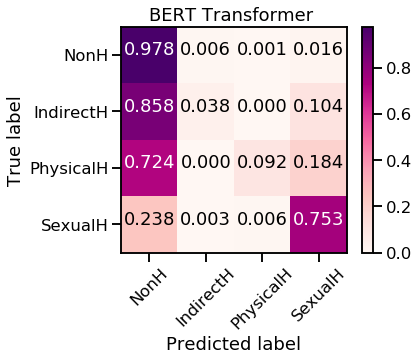

Test_ acc: 0.8629298162976919
Test_ f1 none: [0.922 0.067 0.161 0.793]
Test_ f1 macro: 0.48566083513772207
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 18
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.078 	F-macro_val: 0.077
Epoch 10 	acc_val: 0.876 	F-macro_val: 0.447
Epoch 20 	acc_val: 0.878 	F-macro_val: 0.434
Testing run # 18
SE TUVIERON QUE REPETIR 21 EJEMPLOS


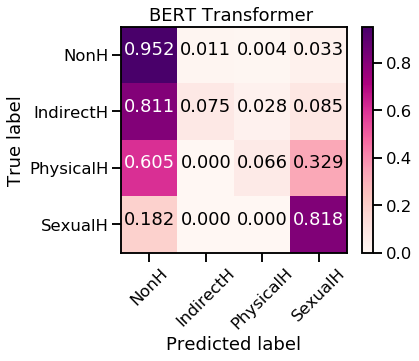

Test_ acc: 0.8549222797927462
Test_ f1 none: [0.918 0.122 0.11  0.789]
Test_ f1 macro: 0.48475722425273304
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 19
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.853 	F-macro_val: 0.426
Epoch 10 	acc_val: 0.878 	F-macro_val: 0.435
Epoch 20 	acc_val: 0.877 	F-macro_val: 0.435
Testing run # 19
SE TUVIERON QUE REPETIR 21 EJEMPLOS


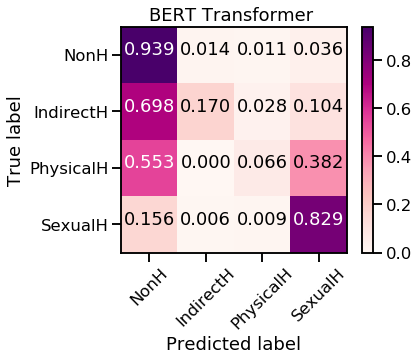

Test_ acc: 0.8516250588789449
Test_ f1 none: [0.918 0.242 0.096 0.783]
Test_ f1 macro: 0.5098803456133717
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 20
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.264 	F-macro_val: 0.174
Epoch 10 	acc_val: 0.875 	F-macro_val: 0.425
Epoch 20 	acc_val: 0.880 	F-macro_val: 0.429
Testing run # 20
SE TUVIERON QUE REPETIR 21 EJEMPLOS


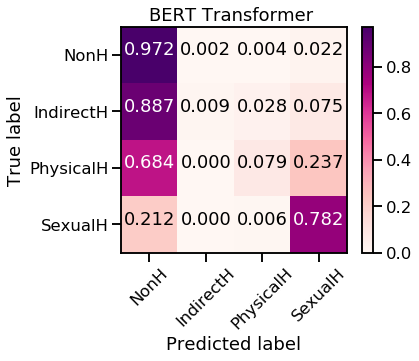

Test_ acc: 0.8615167216203485
Test_ f1 none: [0.922 0.018 0.129 0.796]
Test_ f1 macro: 0.4664238339872877


In [41]:
bc = BertClient()  

best_15, all_accs_15, all_fno_15, all_ma_15, all_cm_15 = train_transformer(0.15, 26, path_a, path_m, "RdPu", augmented=True)


In [42]:
print ("best_15", best_15)
print ("all_accs_15", all_accs_15)
print ("all_fno_15", all_fno_15)
print ("all_ma_15", all_ma_15)

best_15 {'F_ma': 0.5474666220247847, 'Run': 10}
all_accs_15 [0.8605746585021197, 0.8563353744700894, 0.8657560056523788, 0.8601036269430051, 0.8615167216203485, 0.8615167216203485, 0.867169100329722, 0.8615167216203485, 0.8648139425341498, 0.8666980687706076, 0.8582195007065473, 0.8601036269430051, 0.8695242581252944, 0.8610456900612341, 0.8685821950070655, 0.8553933113518606, 0.8629298162976919, 0.8549222797927462, 0.8516250588789449, 0.8615167216203485]
all_fno_15 [array([0.92 , 0.035, 0.072, 0.804]), array([0.921, 0.137, 0.182, 0.785]), array([0.925, 0.08 , 0.224, 0.813]), array([0.924, 0.136, 0.047, 0.797]), array([0.92 , 0.094, 0.   , 0.809]), array([0.922, 0.126, 0.141, 0.795]), array([0.928, 0.036, 0.173, 0.81 ]), array([0.921, 0.017, 0.208, 0.804]), array([0.924, 0.068, 0.072, 0.806]), array([0.926, 0.206, 0.245, 0.812]), array([0.923, 0.095, 0.149, 0.789]), array([0.922, 0.066, 0.071, 0.805]), array([0.927, 0.128, 0.026, 0.821]), array([0.922, 0.099, 0.089, 0.796]), array([0.9

Acc: 0.861 -- deviation: 0.005
F-score: 0.485 -- deviation: 0.021
(0.15) NIPS: 0.9225752099920648 0.09555161427555767 0.12263661755233166 0.7997991600568086


Confusion counts
[[3.084e+04 2.260e+02 9.700e+01 8.600e+02]
 [1.757e+03 1.250e+02 3.500e+01 2.030e+02]
 [1.012e+03 0.000e+00 1.150e+02 3.930e+02]
 [1.224e+03 2.400e+01 5.000e+01 5.502e+03]]


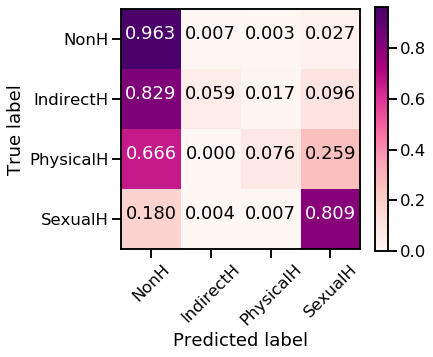

In [43]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs_15)), "-- deviation: %.3f" % np.std(np.asarray(all_accs_15)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma_15)), "-- deviation: %.3f" % np.std(np.asarray(all_ma_15)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno_15)[:,0])
den=np.mean(np.asarray(all_fno_15)[:,1])
que=np.mean(np.asarray(all_fno_15)[:,2])
com=np.mean(np.asarray(all_fno_15)[:,3])

print ("(0.15) NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm_15:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["NonH", "IndirectH", "PhysicalH", "SexualH"], "", cmap='RdPu')

## 0.5 mask

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 1
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.525 	F-macro_val: 0.285
Epoch 10 	acc_val: 0.875 	F-macro_val: 0.443
Epoch 20 	acc_val: 0.878 	F-macro_val: 0.446
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


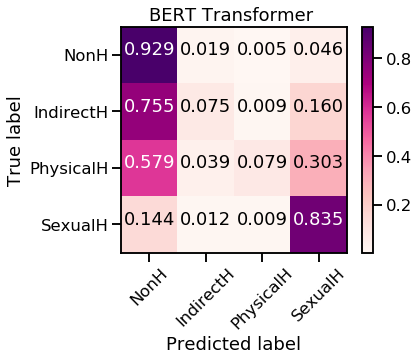

Test_ acc: 0.8412623645784267
Test_ f1 none: [0.912 0.105 0.128 0.77 ]
Test_ f1 macro: 0.4787235391535396


Ejemplo de tweet con label  NonH  y tweet_id  1956
Encoder Layer 1


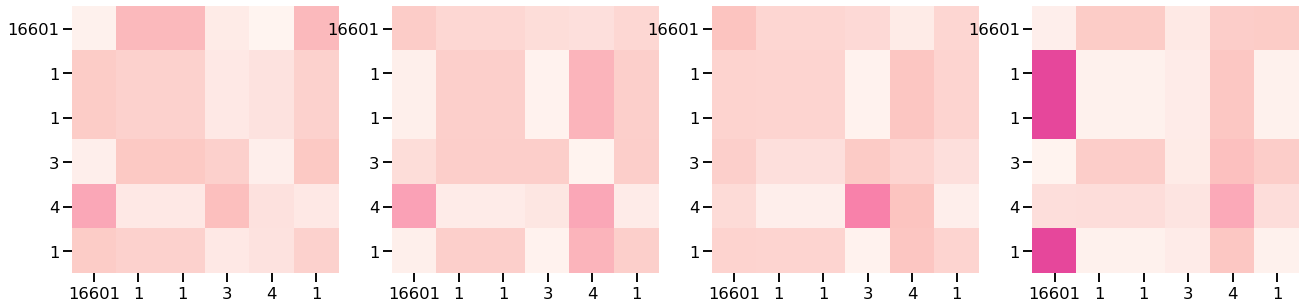

Encoder Layer 2


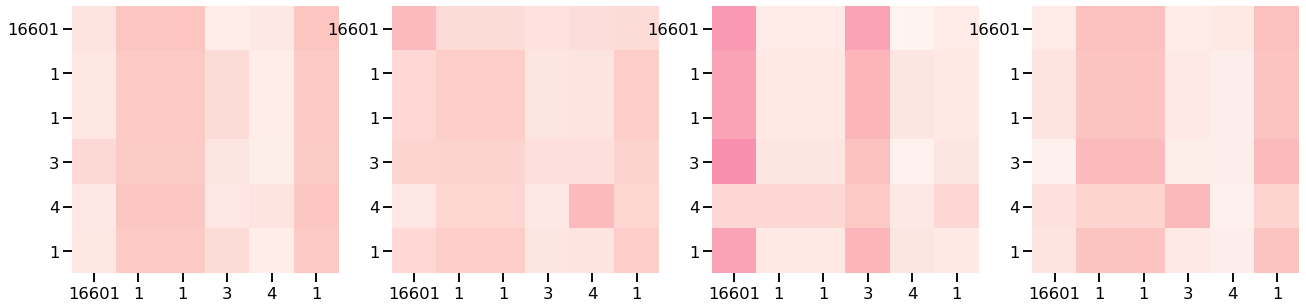



Ejemplo de tweet con label  IndirectH  y tweet_id  1633
Encoder Layer 1


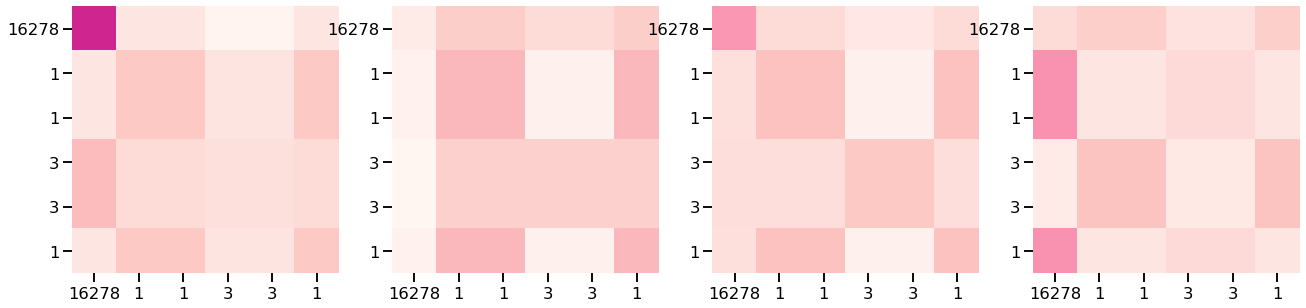

Encoder Layer 2


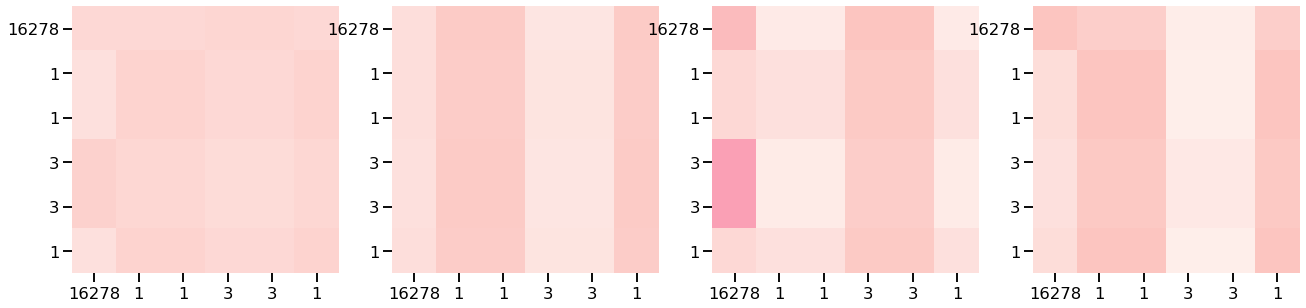



Ejemplo de tweet con label  PhysicalH  y tweet_id  1400
Encoder Layer 1


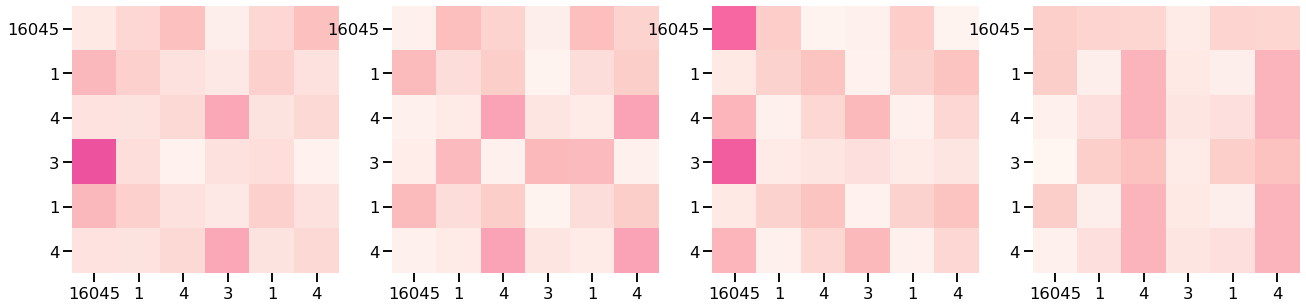

Encoder Layer 2


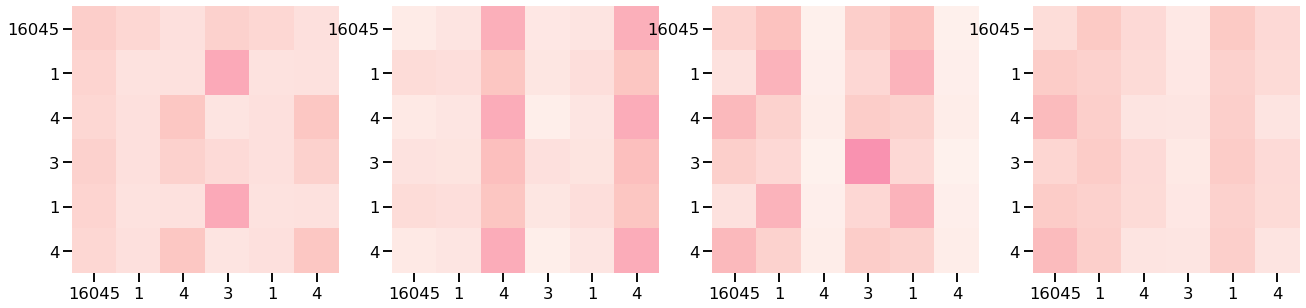



Ejemplo de tweet con label  SexualH  y tweet_id  1785
Encoder Layer 1


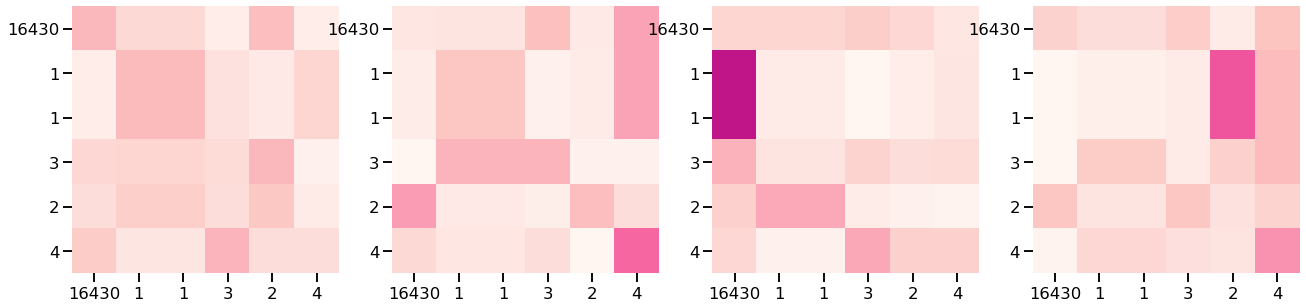

Encoder Layer 2


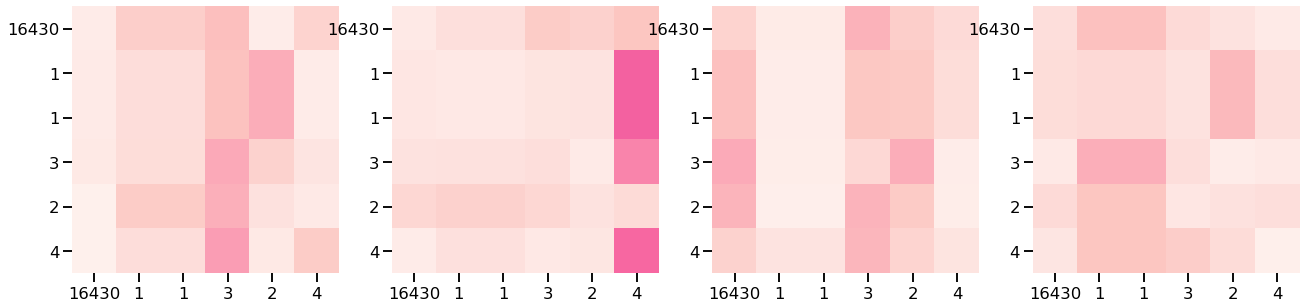

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 2
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.275 	F-macro_val: 0.123
Epoch 10 	acc_val: 0.871 	F-macro_val: 0.432
Epoch 20 	acc_val: 0.873 	F-macro_val: 0.431
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


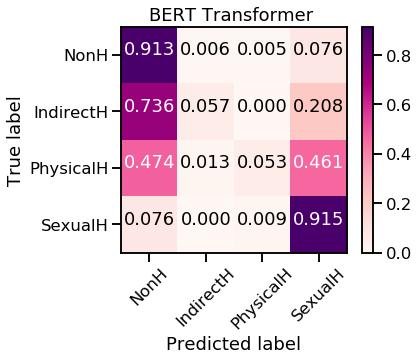

Test_ acc: 0.8393782383419689
Test_ f1 none: [0.913 0.098 0.088 0.749]
Test_ f1 macro: 0.4618563268062378
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 3
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.543 	F-macro_val: 0.291
Epoch 10 	acc_val: 0.882 	F-macro_val: 0.440
Epoch 20 	acc_val: 0.883 	F-macro_val: 0.442
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


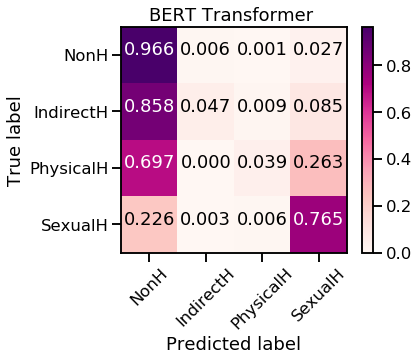

Test_ acc: 0.8544512482336316
Test_ f1 none: [0.918 0.083 0.071 0.773]
Test_ f1 macro: 0.4611962971501683
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 4
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.462 	F-macro_val: 0.224
Epoch 10 	acc_val: 0.872 	F-macro_val: 0.432
Epoch 20 	acc_val: 0.873 	F-macro_val: 0.433
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


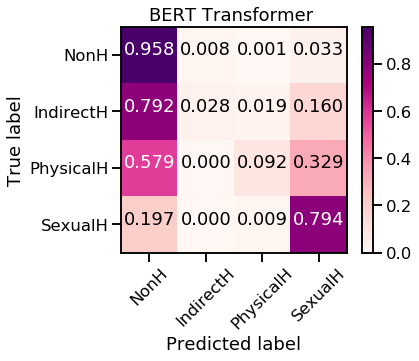

Test_ acc: 0.8544512482336316
Test_ f1 none: [0.921 0.049 0.157 0.766]
Test_ f1 macro: 0.47344061669630033
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 5
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.210 	F-macro_val: 0.186
Epoch 10 	acc_val: 0.863 	F-macro_val: 0.436
Epoch 20 	acc_val: 0.867 	F-macro_val: 0.437
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


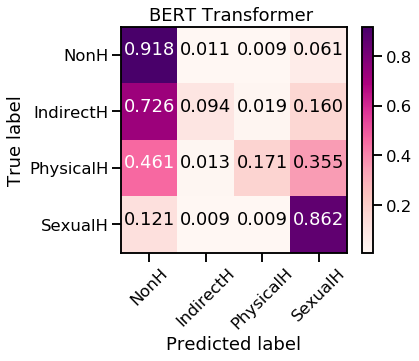

Test_ acc: 0.8412623645784267
Test_ f1 none: [0.912 0.145 0.239 0.756]
Test_ f1 macro: 0.5128748371392196


Ejemplo de tweet con label  NonH  y tweet_id  352
Encoder Layer 1


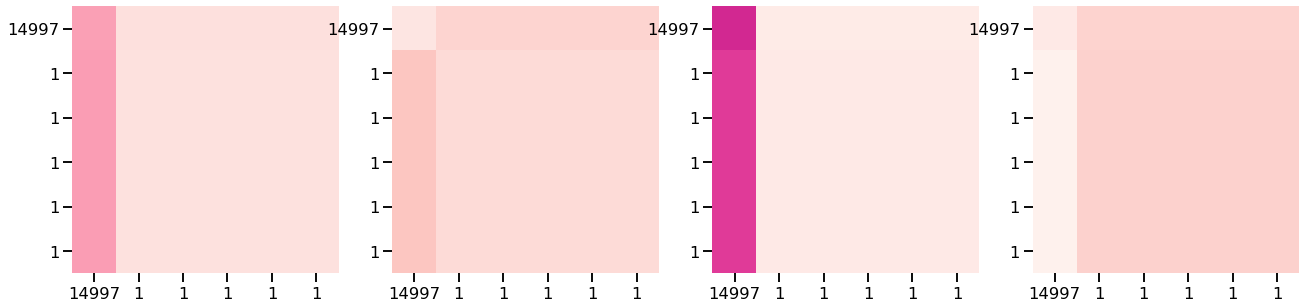

Encoder Layer 2


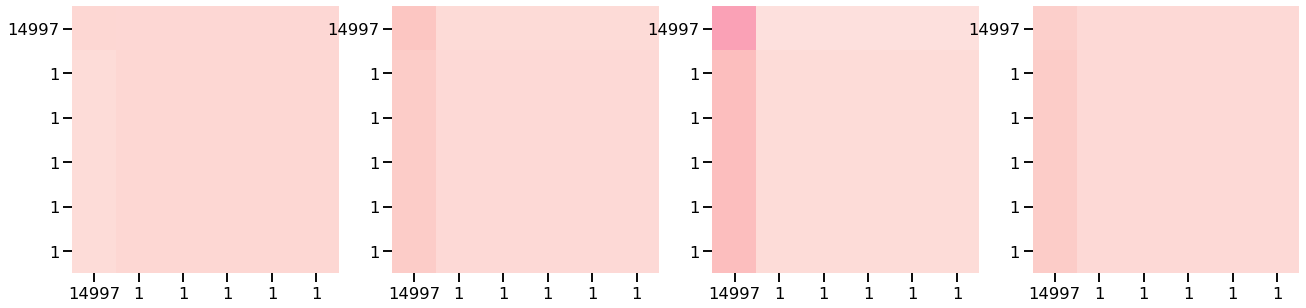



Ejemplo de tweet con label  IndirectH  y tweet_id  1737
Encoder Layer 1


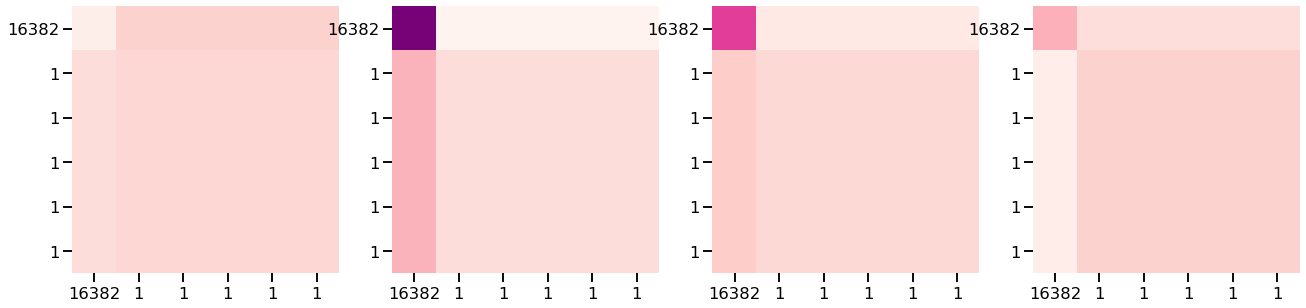

Encoder Layer 2


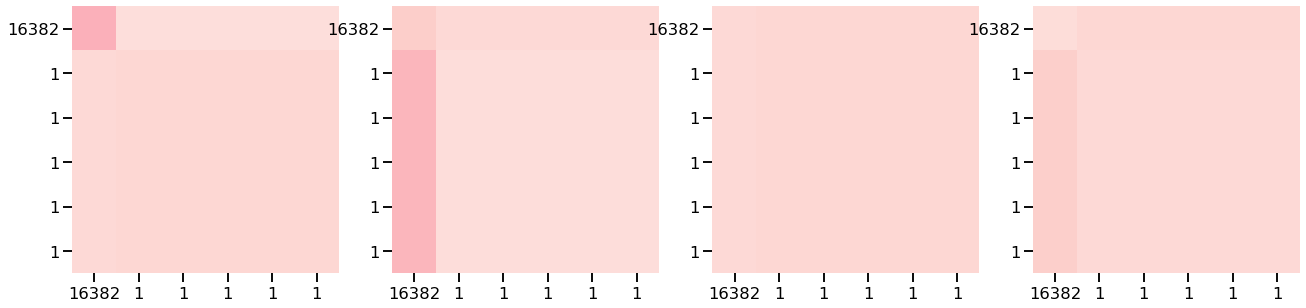



Ejemplo de tweet con label  PhysicalH  y tweet_id  315
Encoder Layer 1


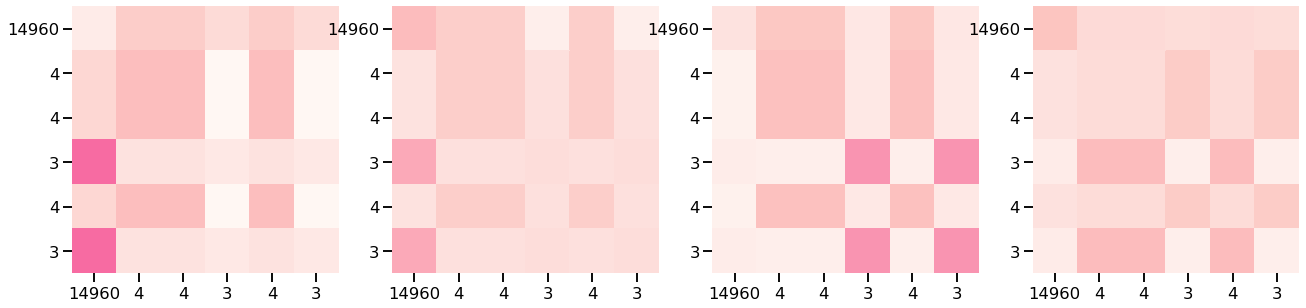

Encoder Layer 2


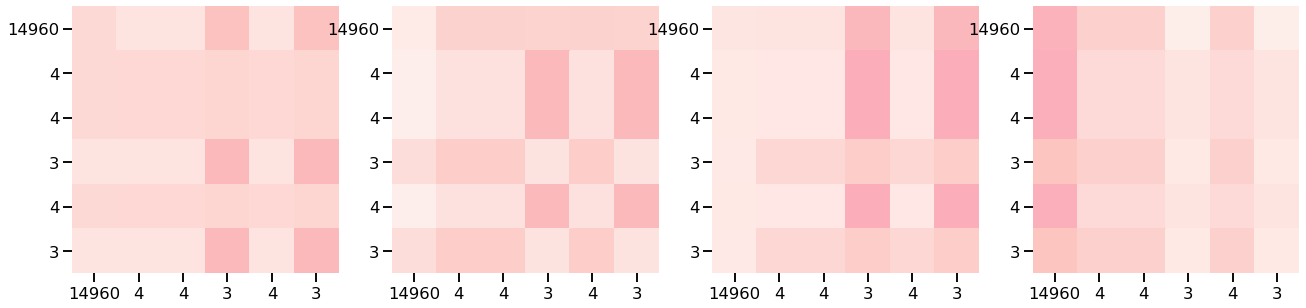



Ejemplo de tweet con label  SexualH  y tweet_id  1126
Encoder Layer 1


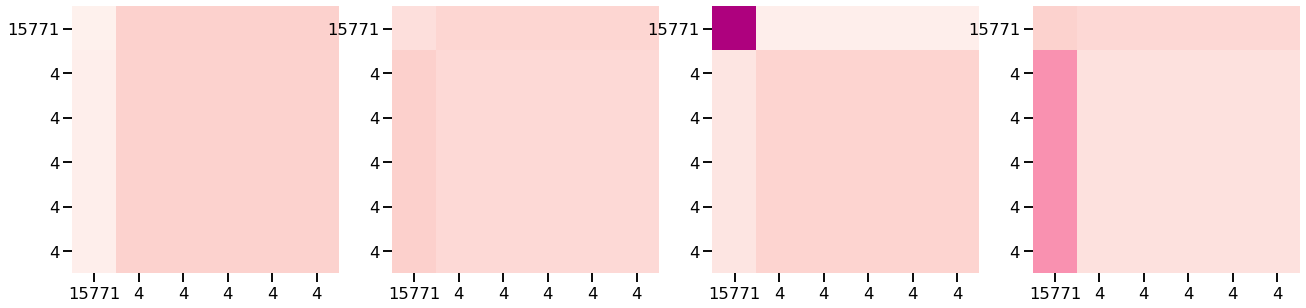

Encoder Layer 2


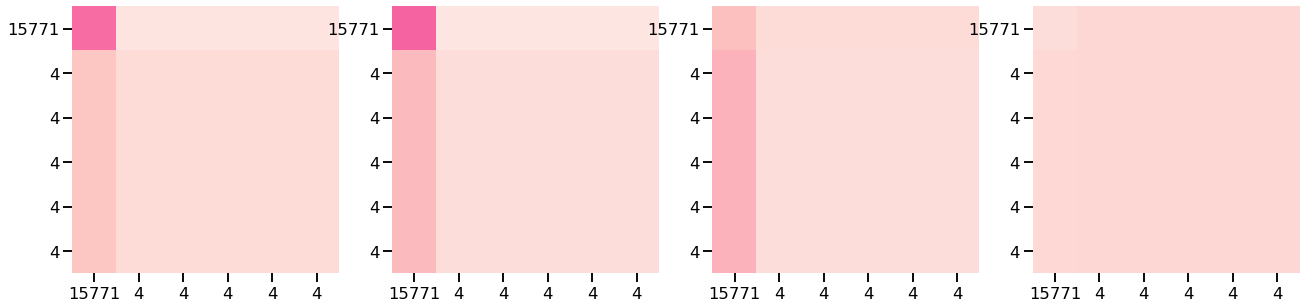

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 6
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.119 	F-macro_val: 0.079
Epoch 10 	acc_val: 0.871 	F-macro_val: 0.437
Epoch 20 	acc_val: 0.879 	F-macro_val: 0.441
Testing run # 6
SE TUVIERON QUE REPETIR 21 EJEMPLOS


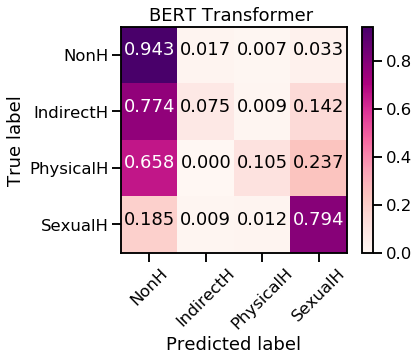

Test_ acc: 0.8459726801695714
Test_ f1 none: [0.913 0.111 0.16  0.776]
Test_ f1 macro: 0.4901159507965316
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 7
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.675 	F-macro_val: 0.331
Epoch 10 	acc_val: 0.872 	F-macro_val: 0.444
Epoch 20 	acc_val: 0.875 	F-macro_val: 0.443
Testing run # 7
SE TUVIERON QUE REPETIR 21 EJEMPLOS


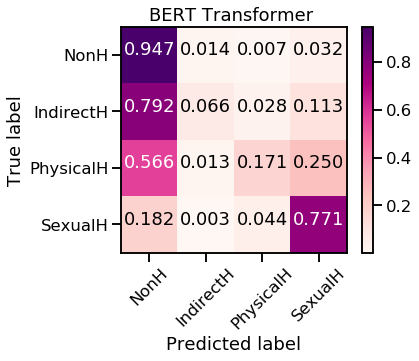

Test_ acc: 0.8469147432878003
Test_ f1 none: [0.917 0.102 0.22  0.765]
Test_ f1 macro: 0.5011531637243035
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 8
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.744 	F-macro_val: 0.375
Epoch 10 	acc_val: 0.869 	F-macro_val: 0.441
Epoch 20 	acc_val: 0.875 	F-macro_val: 0.444
Testing run # 8
SE TUVIERON QUE REPETIR 21 EJEMPLOS


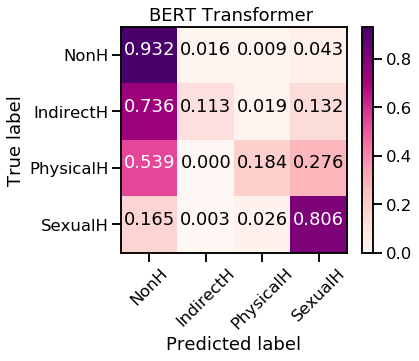

Test_ acc: 0.8440885539331136
Test_ f1 none: [0.913 0.166 0.243 0.763]
Test_ f1 macro: 0.5213308488117254


Ejemplo de tweet con label  NonH  y tweet_id  111
Encoder Layer 1


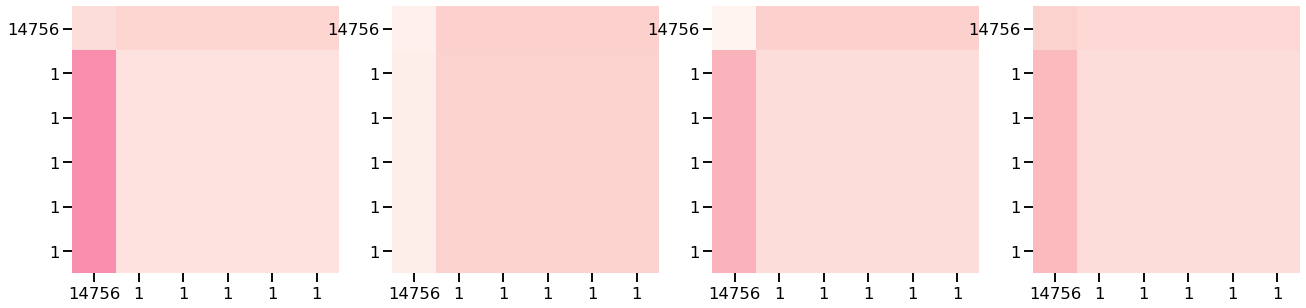

Encoder Layer 2


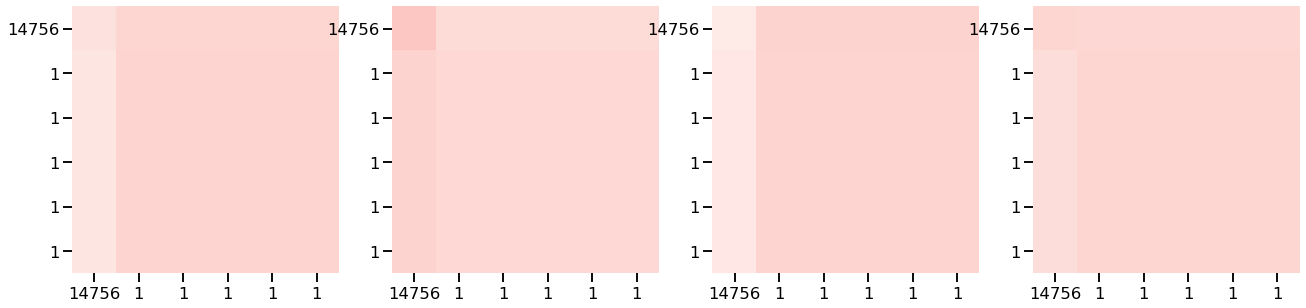



Ejemplo de tweet con label  IndirectH  y tweet_id  1461
Encoder Layer 1


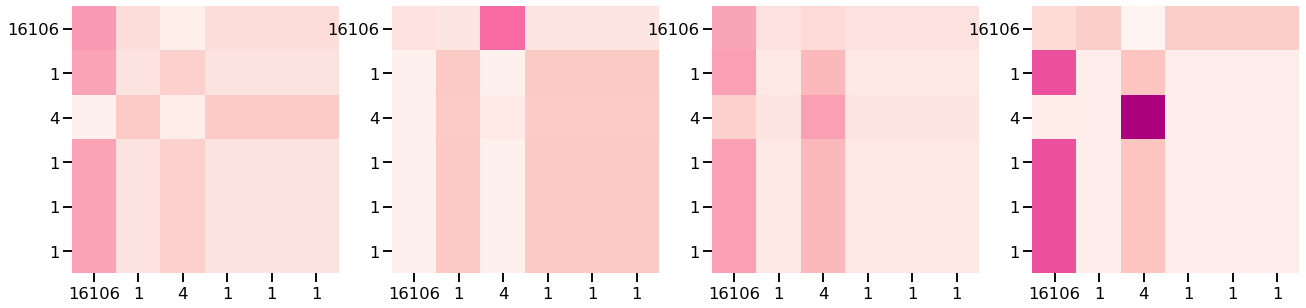

Encoder Layer 2


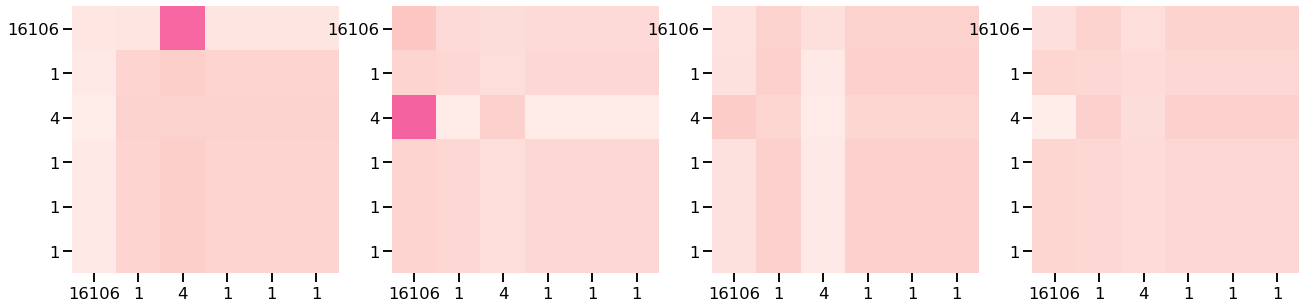



Ejemplo de tweet con label  PhysicalH  y tweet_id  315
Encoder Layer 1


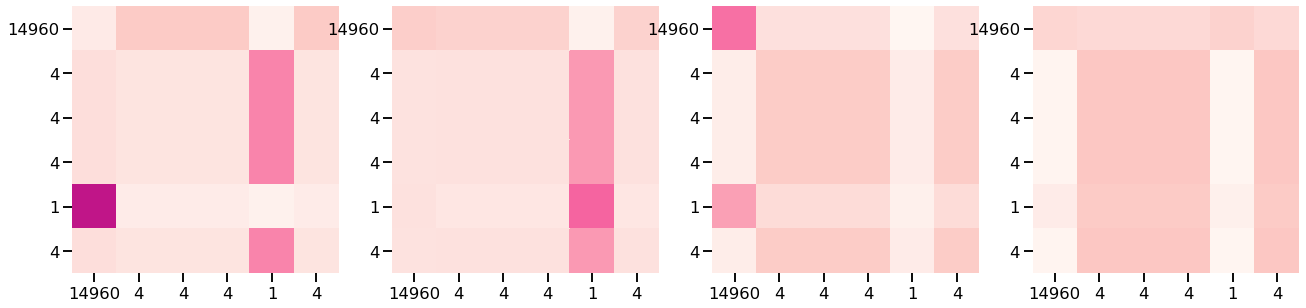

Encoder Layer 2


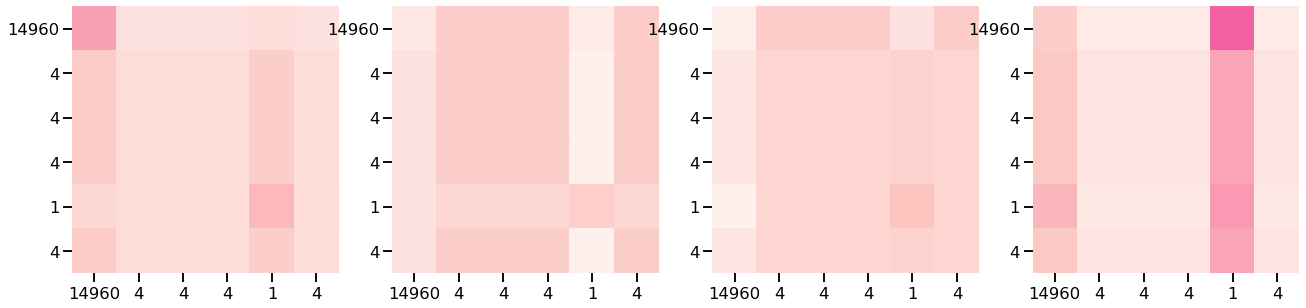



Ejemplo de tweet con label  SexualH  y tweet_id  1741
Encoder Layer 1


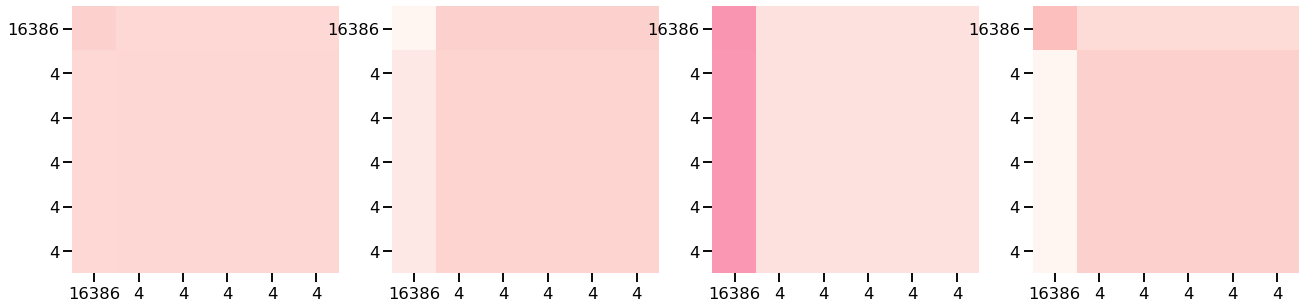

Encoder Layer 2


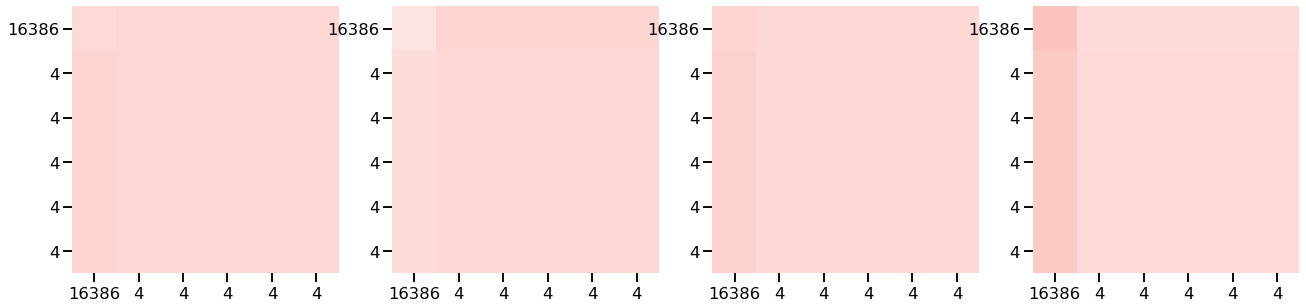

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 9
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.558 	F-macro_val: 0.301
Epoch 10 	acc_val: 0.876 	F-macro_val: 0.433
Epoch 20 	acc_val: 0.874 	F-macro_val: 0.431
Testing run # 9
SE TUVIERON QUE REPETIR 21 EJEMPLOS


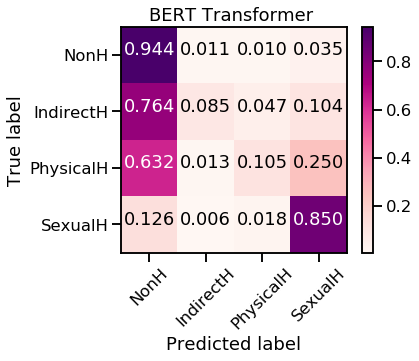

Test_ acc: 0.855864342910975
Test_ f1 none: [0.92  0.132 0.144 0.808]
Test_ f1 macro: 0.5012769846339024
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 10
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.348 	F-macro_val: 0.195
Epoch 10 	acc_val: 0.880 	F-macro_val: 0.432
Epoch 20 	acc_val: 0.880 	F-macro_val: 0.432
Testing run # 10
SE TUVIERON QUE REPETIR 21 EJEMPLOS


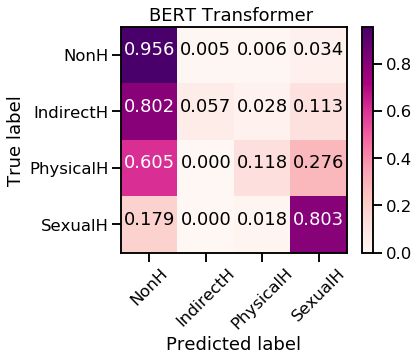

Test_ acc: 0.8563353744700894
Test_ f1 none: [0.921 0.1   0.175 0.78 ]
Test_ f1 macro: 0.49390298274164474
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 11
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.086 	F-macro_val: 0.077
Epoch 10 	acc_val: 0.882 	F-macro_val: 0.448
Epoch 20 	acc_val: 0.886 	F-macro_val: 0.449
Testing run # 11
SE TUVIERON QUE REPETIR 21 EJEMPLOS


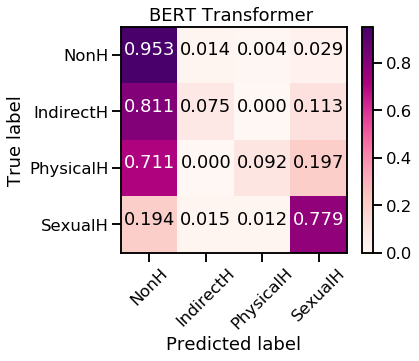

Test_ acc: 0.8502119642016015
Test_ f1 none: [0.915 0.113 0.149 0.782]
Test_ f1 macro: 0.4896723218659137
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 12
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.202 	F-macro_val: 0.137
Epoch 10 	acc_val: 0.869 	F-macro_val: 0.447
Epoch 20 	acc_val: 0.870 	F-macro_val: 0.448
Testing run # 12
SE TUVIERON QUE REPETIR 21 EJEMPLOS


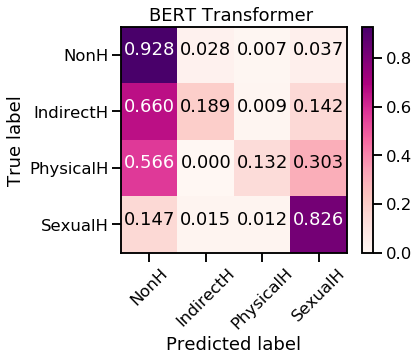

Test_ acc: 0.8464437117286858
Test_ f1 none: [0.914 0.227 0.196 0.783]
Test_ f1 macro: 0.5301356255301856


Ejemplo de tweet con label  NonH  y tweet_id  1733
Encoder Layer 1


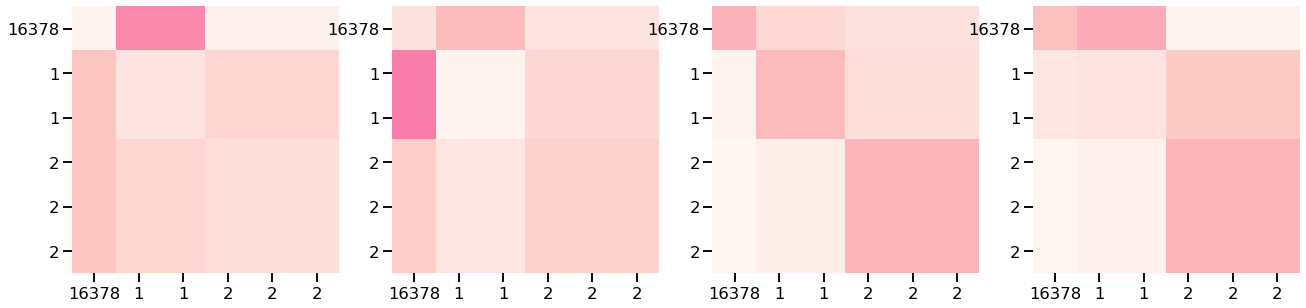

Encoder Layer 2


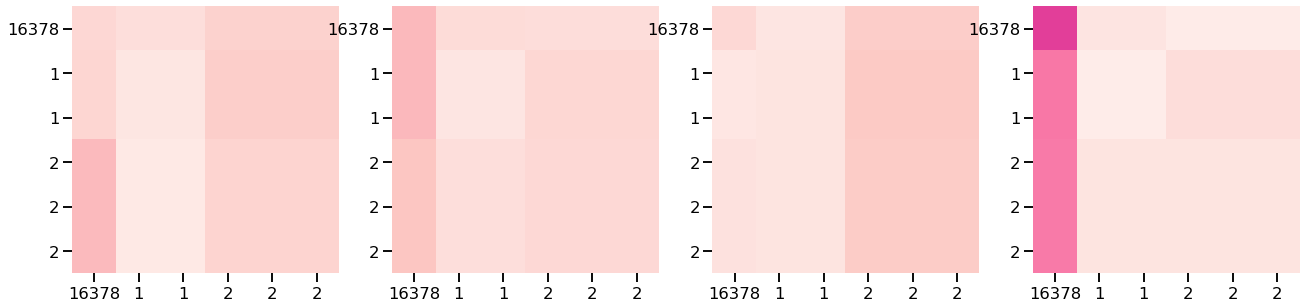



Ejemplo de tweet con label  IndirectH  y tweet_id  506
Encoder Layer 1


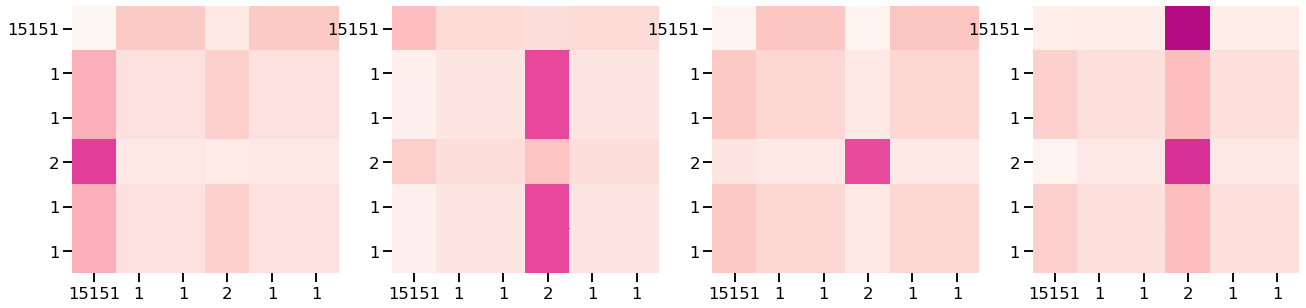

Encoder Layer 2


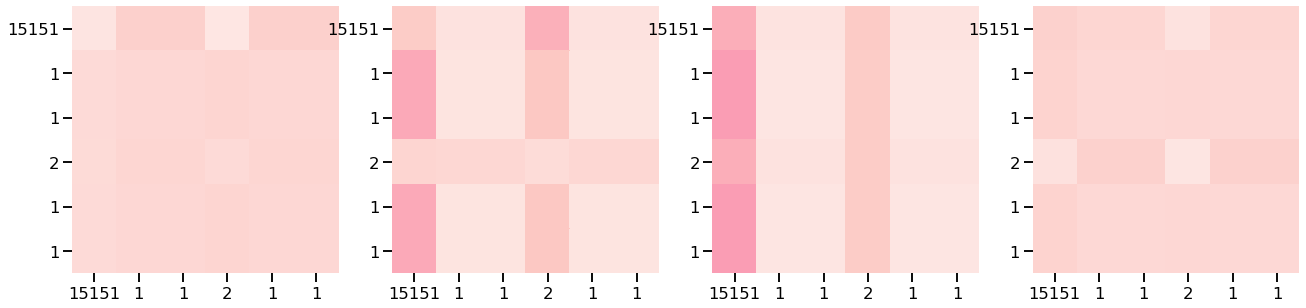



Ejemplo de tweet con label  PhysicalH  y tweet_id  1374
Encoder Layer 1


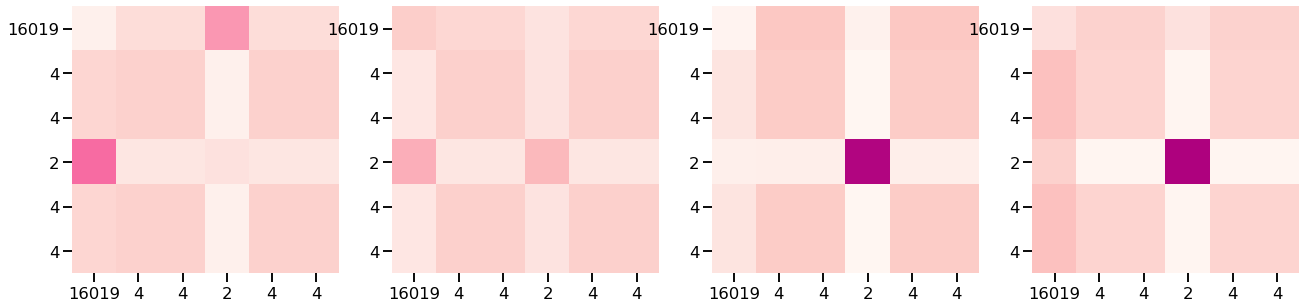

Encoder Layer 2


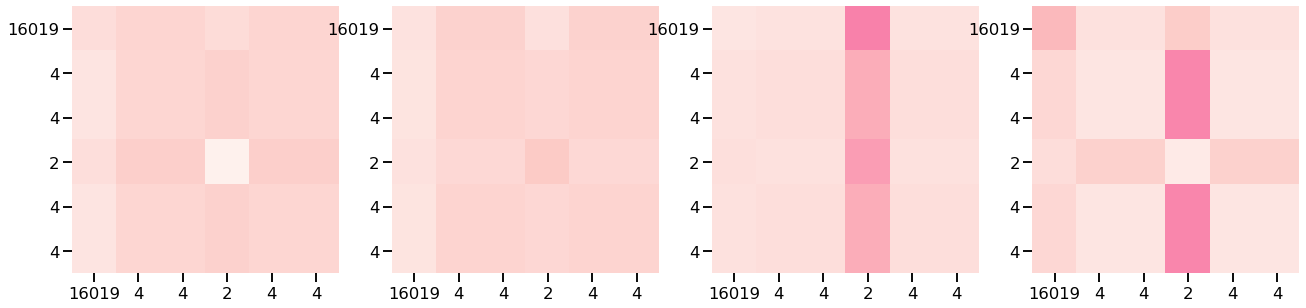



Ejemplo de tweet con label  SexualH  y tweet_id  1925
Encoder Layer 1


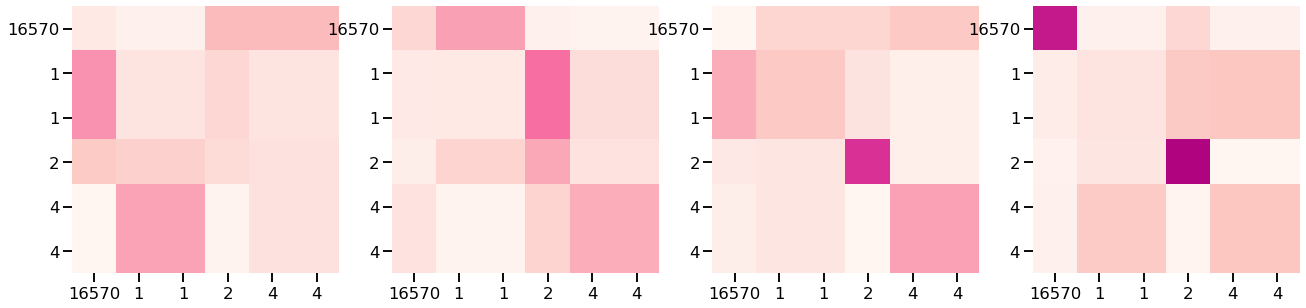

Encoder Layer 2


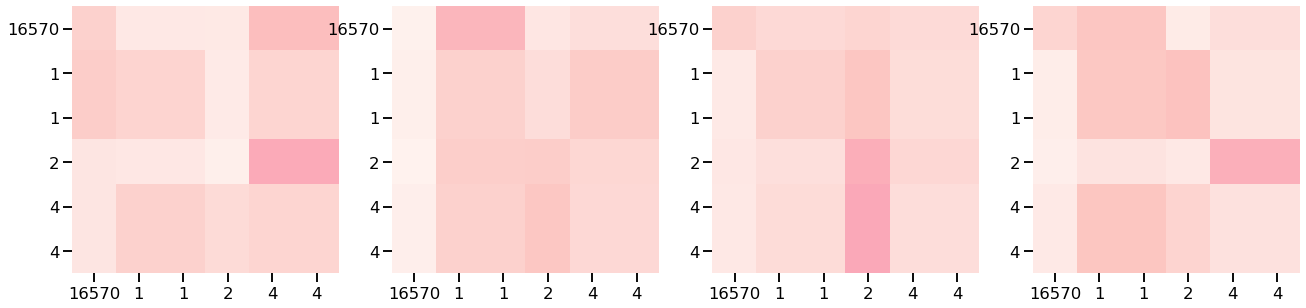

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 13
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.180 	F-macro_val: 0.137
Epoch 10 	acc_val: 0.879 	F-macro_val: 0.431
Epoch 20 	acc_val: 0.882 	F-macro_val: 0.432
Testing run # 13
SE TUVIERON QUE REPETIR 21 EJEMPLOS


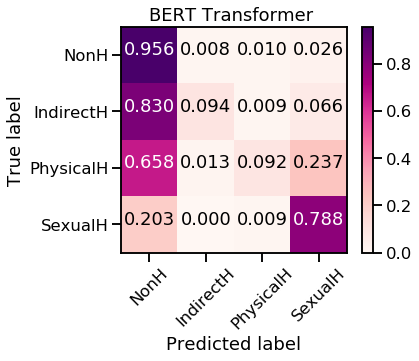

Test_ acc: 0.8553933113518606
Test_ f1 none: [0.917 0.154 0.136 0.795]
Test_ f1 macro: 0.5005154349277765
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 14
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.197 	F-macro_val: 0.151
Epoch 10 	acc_val: 0.865 	F-macro_val: 0.443
Epoch 20 	acc_val: 0.872 	F-macro_val: 0.445
Testing run # 14
SE TUVIERON QUE REPETIR 21 EJEMPLOS


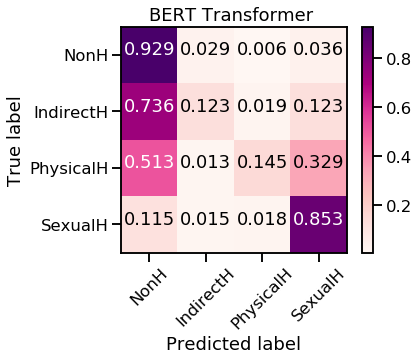

Test_ acc: 0.8487988695242581
Test_ f1 none: [0.917 0.152 0.212 0.799]
Test_ f1 macro: 0.51989663813421
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 15
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.043 	F-macro_val: 0.035
Epoch 10 	acc_val: 0.880 	F-macro_val: 0.433
Epoch 20 	acc_val: 0.880 	F-macro_val: 0.442
Testing run # 15
SE TUVIERON QUE REPETIR 21 EJEMPLOS


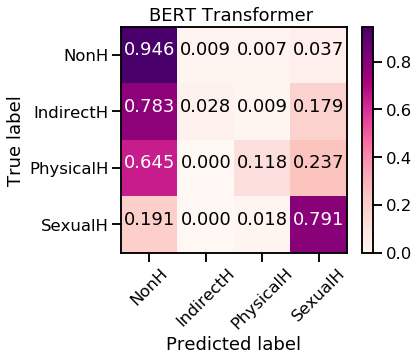

Test_ acc: 0.8459726801695714
Test_ f1 none: [0.915 0.049 0.173 0.762]
Test_ f1 macro: 0.47461900060512474
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 16
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.132 	F-macro_val: 0.101
Epoch 10 	acc_val: 0.857 	F-macro_val: 0.430
Epoch 20 	acc_val: 0.869 	F-macro_val: 0.430
Testing run # 16
SE TUVIERON QUE REPETIR 21 EJEMPLOS


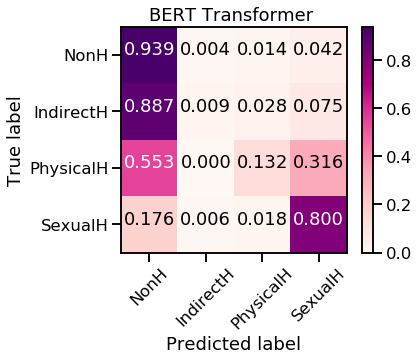

Test_ acc: 0.8417333961375412
Test_ f1 none: [0.911 0.017 0.169 0.764]
Test_ f1 macro: 0.46554169801775713
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 17
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.192 	F-macro_val: 0.185
Epoch 10 	acc_val: 0.885 	F-macro_val: 0.444
Epoch 20 	acc_val: 0.886 	F-macro_val: 0.446
Testing run # 17
SE TUVIERON QUE REPETIR 21 EJEMPLOS


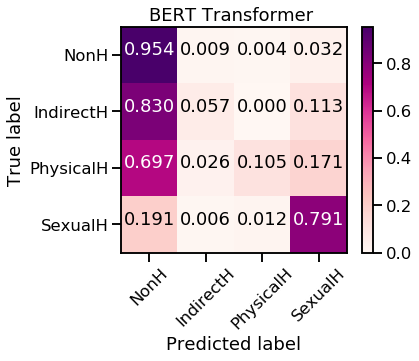

Test_ acc: 0.8530381535562883
Test_ f1 none: [0.916 0.092 0.168 0.784]
Test_ f1 macro: 0.4903317834478731
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 18
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.130 	F-macro_val: 0.080
Epoch 10 	acc_val: 0.882 	F-macro_val: 0.440
Epoch 20 	acc_val: 0.880 	F-macro_val: 0.437
Testing run # 18
SE TUVIERON QUE REPETIR 21 EJEMPLOS


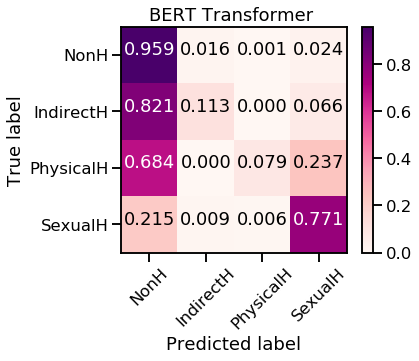

Test_ acc: 0.8553933113518606
Test_ f1 none: [0.917 0.164 0.14  0.788]
Test_ f1 macro: 0.5022942782712817
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 19
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.126 	F-macro_val: 0.106
Epoch 10 	acc_val: 0.883 	F-macro_val: 0.441
Epoch 20 	acc_val: 0.881 	F-macro_val: 0.442
Testing run # 19
SE TUVIERON QUE REPETIR 21 EJEMPLOS


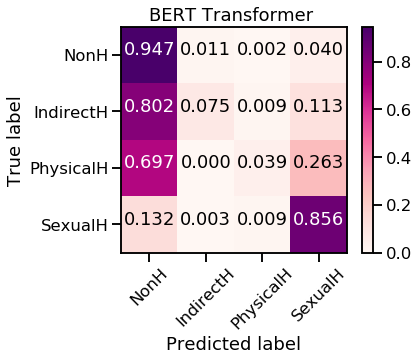

Test_ acc: 0.8563353744700894
Test_ f1 none: [0.919 0.121 0.069 0.801]
Test_ f1 macro: 0.47737893089218797
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 20
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.288 	F-macro_val: 0.201
Epoch 10 	acc_val: 0.871 	F-macro_val: 0.426
Epoch 20 	acc_val: 0.875 	F-macro_val: 0.426
Testing run # 20
SE TUVIERON QUE REPETIR 21 EJEMPLOS


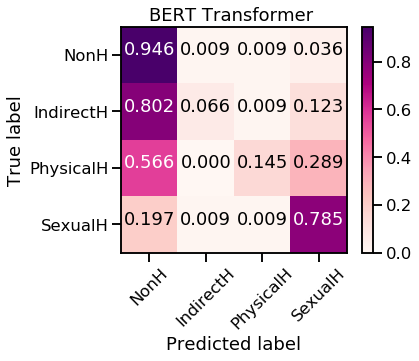

Test_ acc: 0.8478568064060292
Test_ f1 none: [0.915 0.108 0.208 0.764]
Test_ f1 macro: 0.4985798389013413


In [44]:
best_50, all_accs_50, all_fno_50, all_ma_50, all_cm_50 = train_transformer(0.5, 26, path_a, path_m, "RdPu", augmented=True)

In [45]:
print ("best_50", best_50)
print ("all_accs_50", all_accs_50)
print ("all_fno_50", all_fno_50)
print ("all_ma_50", all_ma_50)

best_50 {'F_ma': 0.5301356255301856, 'Run': 12}
all_accs_50 [0.8412623645784267, 0.8393782383419689, 0.8544512482336316, 0.8544512482336316, 0.8412623645784267, 0.8459726801695714, 0.8469147432878003, 0.8440885539331136, 0.855864342910975, 0.8563353744700894, 0.8502119642016015, 0.8464437117286858, 0.8553933113518606, 0.8487988695242581, 0.8459726801695714, 0.8417333961375412, 0.8530381535562883, 0.8553933113518606, 0.8563353744700894, 0.8478568064060292]
all_fno_50 [array([0.912, 0.105, 0.128, 0.77 ]), array([0.913, 0.098, 0.088, 0.749]), array([0.918, 0.083, 0.071, 0.773]), array([0.921, 0.049, 0.157, 0.766]), array([0.912, 0.145, 0.239, 0.756]), array([0.913, 0.111, 0.16 , 0.776]), array([0.917, 0.102, 0.22 , 0.765]), array([0.913, 0.166, 0.243, 0.763]), array([0.92 , 0.132, 0.144, 0.808]), array([0.921, 0.1  , 0.175, 0.78 ]), array([0.915, 0.113, 0.149, 0.782]), array([0.914, 0.227, 0.196, 0.783]), array([0.917, 0.154, 0.136, 0.795]), array([0.917, 0.152, 0.212, 0.799]), array([0.9

Acc: 0.849 -- deviation: 0.006
F-score: 0.492 -- deviation: 0.019
(0.5) NIPS: 0.915914198029928 0.11441784482422472 0.16225334247158424 0.776382034323708


Confusion counts
[[3.020e+04 3.990e+02 2.010e+02 1.218e+03]
 [1.664e+03 1.620e+02 3.000e+01 2.640e+02]
 [9.180e+02 1.100e+01 1.670e+02 4.240e+02]
 [1.144e+03 4.100e+01 9.500e+01 5.520e+03]]


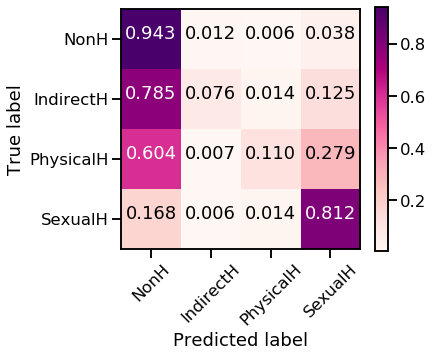

In [46]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs_50)), "-- deviation: %.3f" % np.std(np.asarray(all_accs_50)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma_50)), "-- deviation: %.3f" % np.std(np.asarray(all_ma_50)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno_50)[:,0])
den=np.mean(np.asarray(all_fno_50)[:,1])
que=np.mean(np.asarray(all_fno_50)[:,2])
com=np.mean(np.asarray(all_fno_50)[:,3])

print ("(0.5) NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm_50:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["NonH", "IndirectH", "PhysicalH", "SexualH"], "", cmap='RdPu')

In [10]:
c=np.asarray([[3.020e+04 ,3.990e+02, 2.010e+02, 1.218e+03],
 [1.664e+03 ,1.620e+02 ,3.000e+01, 2.640e+02],
 [9.180e+02 ,1.100e+01 ,1.670e+02, 4.240e+02],
 [1.144e+03 ,4.100e+01 ,9.500e+01, 5.520e+03]])

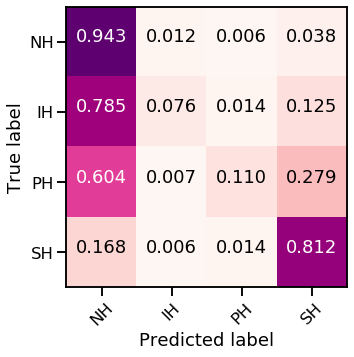

In [12]:
plot_cm(cm_norma(c),["NH", "IH", "PH", "SH"], "", cmap='RdPu')

## 0.85 -- 10 run

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 1
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.264 	F-macro_val: 0.153
Epoch 10 	acc_val: 0.870 	F-macro_val: 0.432
Epoch 20 	acc_val: 0.875 	F-macro_val: 0.430
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


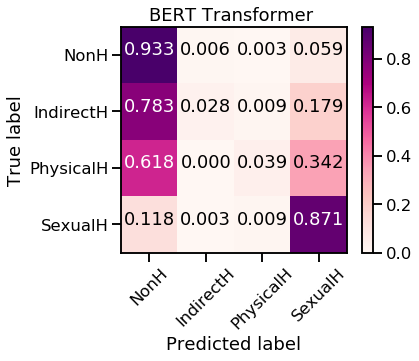

Test_ acc: 0.8455016486104568
Test_ f1 none: [0.915 0.05  0.068 0.764]
Test_ f1 macro: 0.4493253463408824


Ejemplo de tweet con label  NonH  y tweet_id  512
Encoder Layer 1


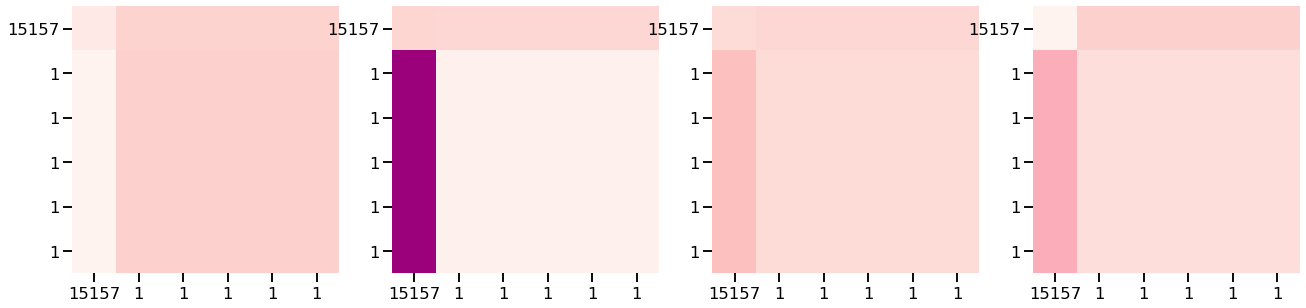

Encoder Layer 2


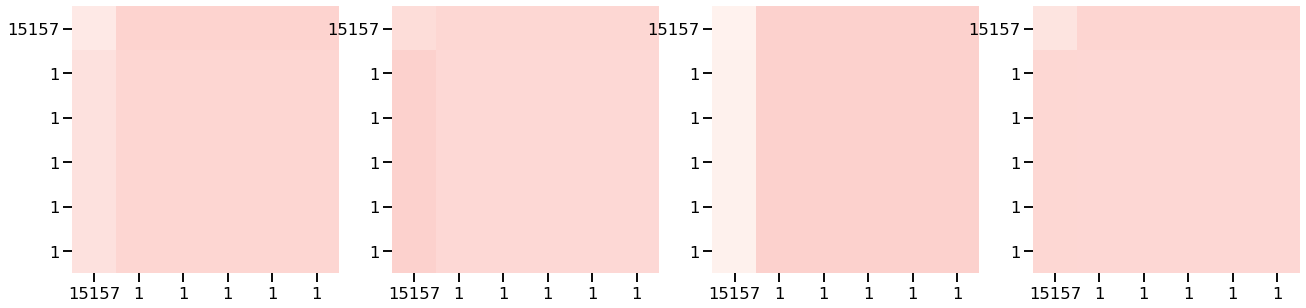



Ejemplo de tweet con label  IndirectH  y tweet_id  1769
Encoder Layer 1


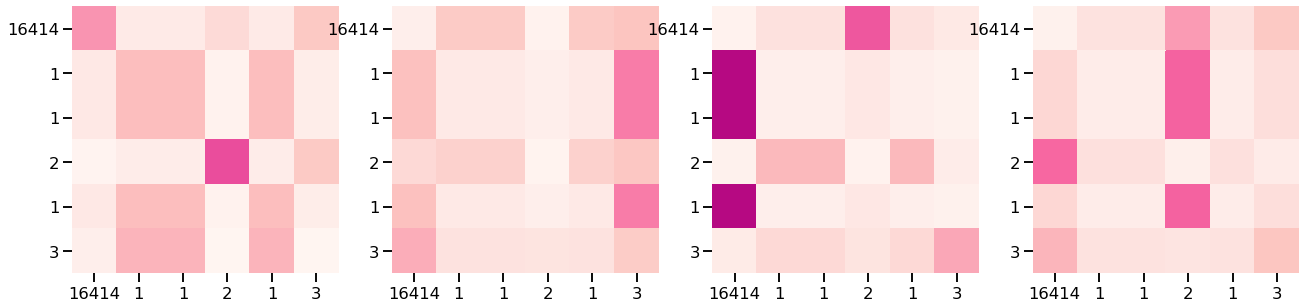

Encoder Layer 2


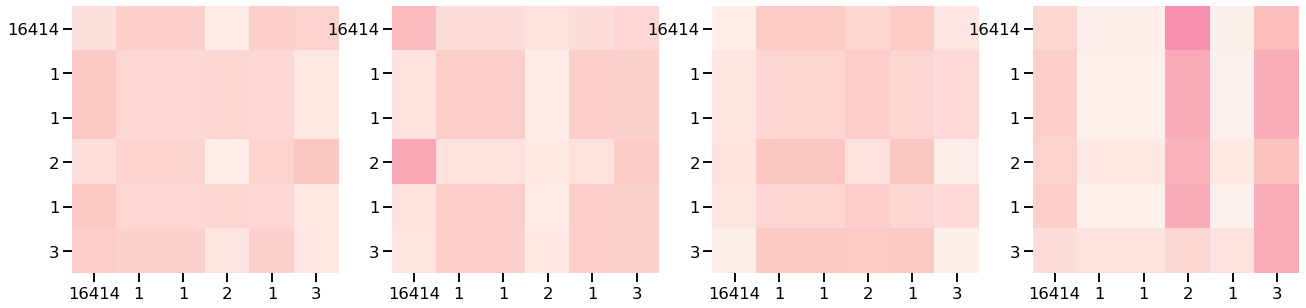



Ejemplo de tweet con label  PhysicalH  y tweet_id  1981
Encoder Layer 1


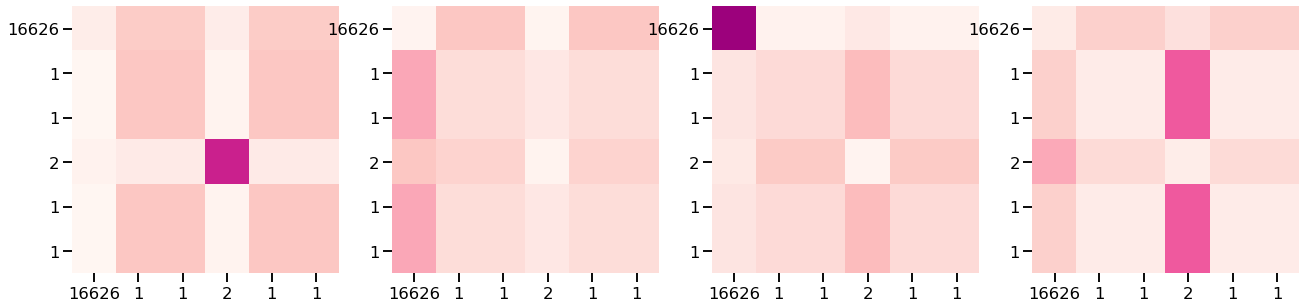

Encoder Layer 2


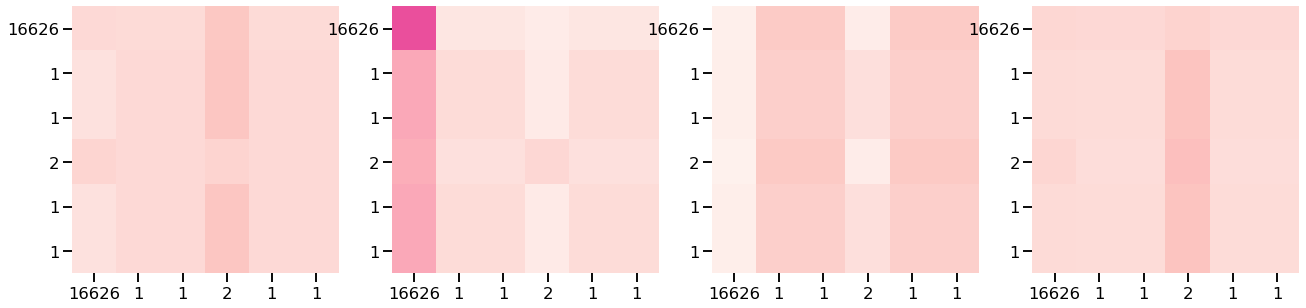



Ejemplo de tweet con label  SexualH  y tweet_id  695
Encoder Layer 1


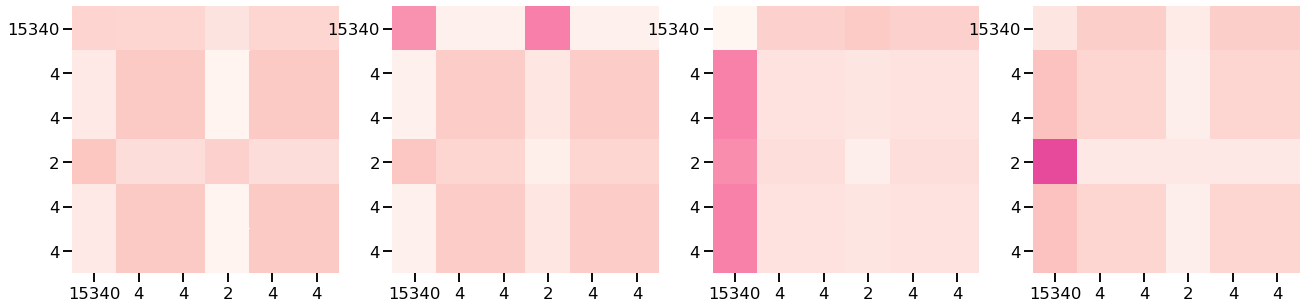

Encoder Layer 2


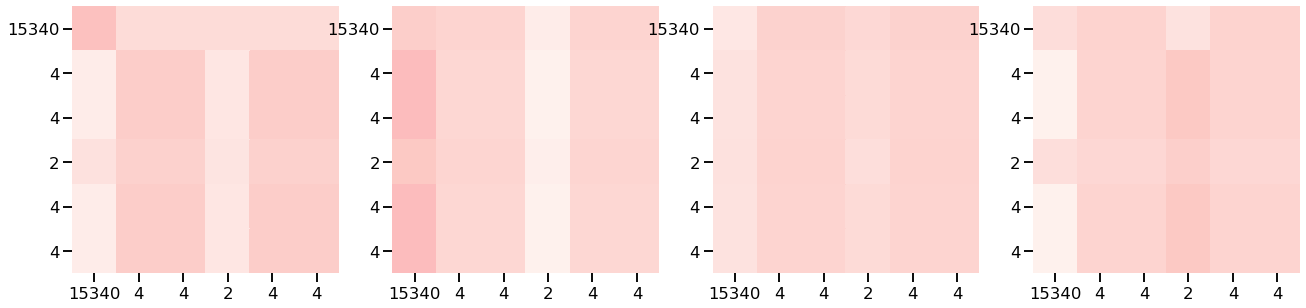

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 2
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.175 	F-macro_val: 0.116
Epoch 10 	acc_val: 0.827 	F-macro_val: 0.424
Epoch 20 	acc_val: 0.832 	F-macro_val: 0.423
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


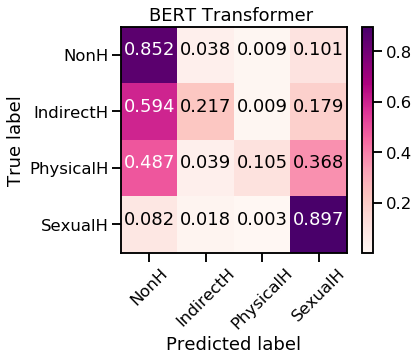

Test_ acc: 0.8007536504945831
Test_ f1 none: [0.882 0.231 0.158 0.715]
Test_ f1 macro: 0.4966715773398395


Ejemplo de tweet con label  NonH  y tweet_id  920
Encoder Layer 1


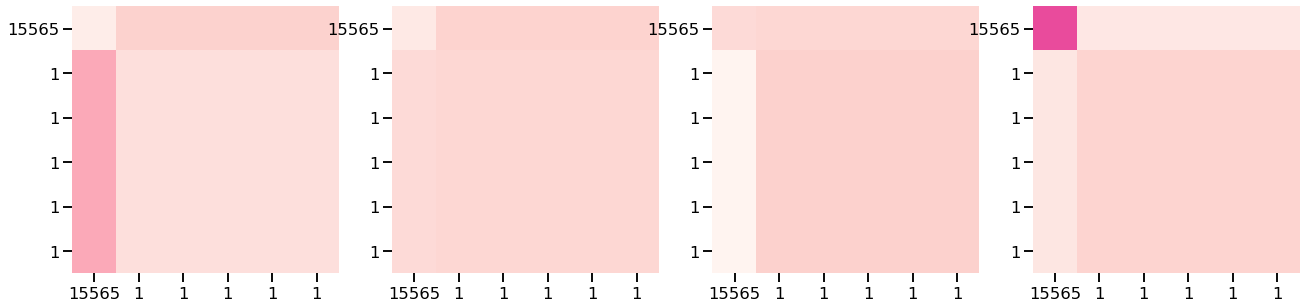

Encoder Layer 2


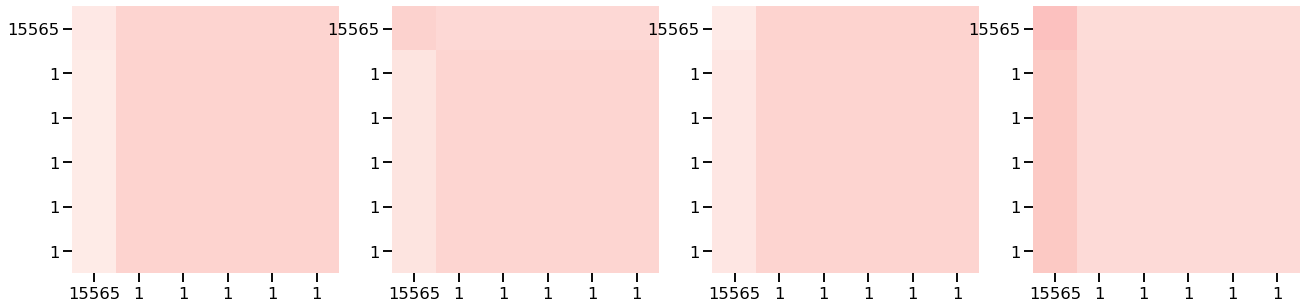



Ejemplo de tweet con label  IndirectH  y tweet_id  1917
Encoder Layer 1


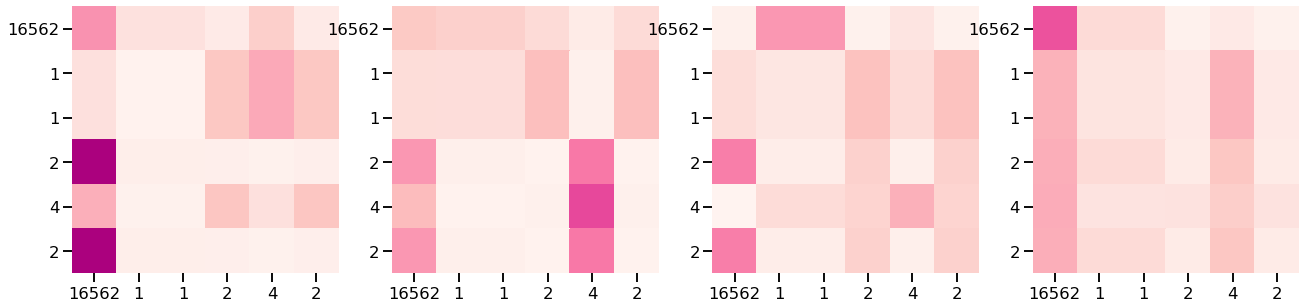

Encoder Layer 2


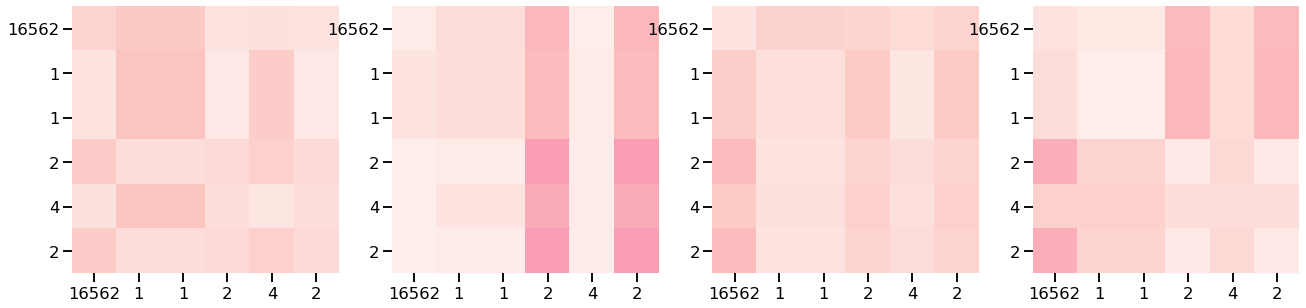



Ejemplo de tweet con label  PhysicalH  y tweet_id  200
Encoder Layer 1


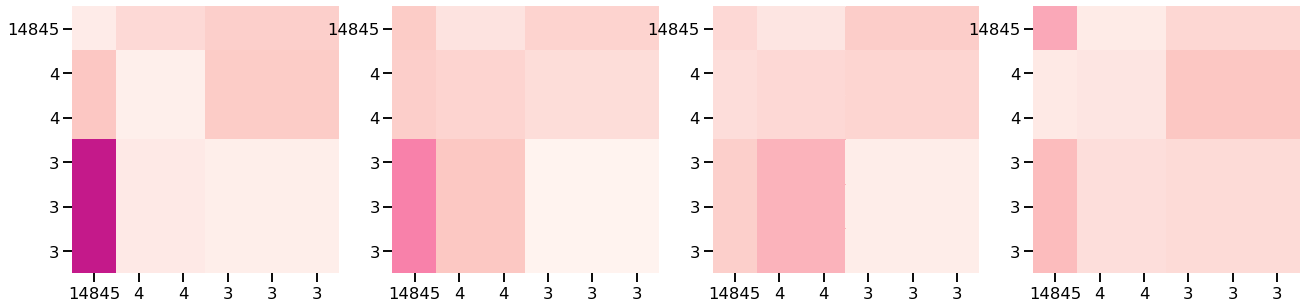

Encoder Layer 2


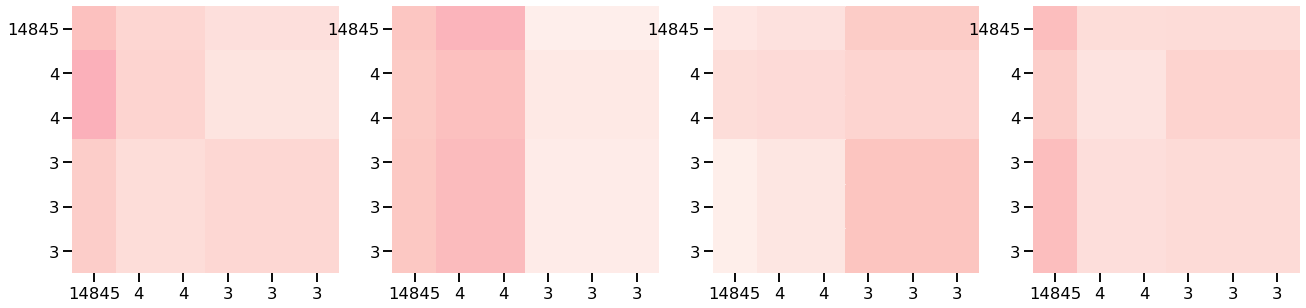



Ejemplo de tweet con label  SexualH  y tweet_id  1027
Encoder Layer 1


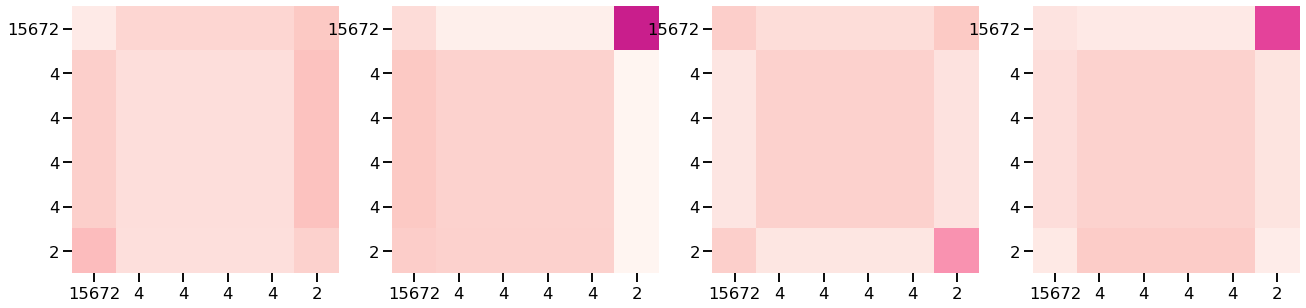

Encoder Layer 2


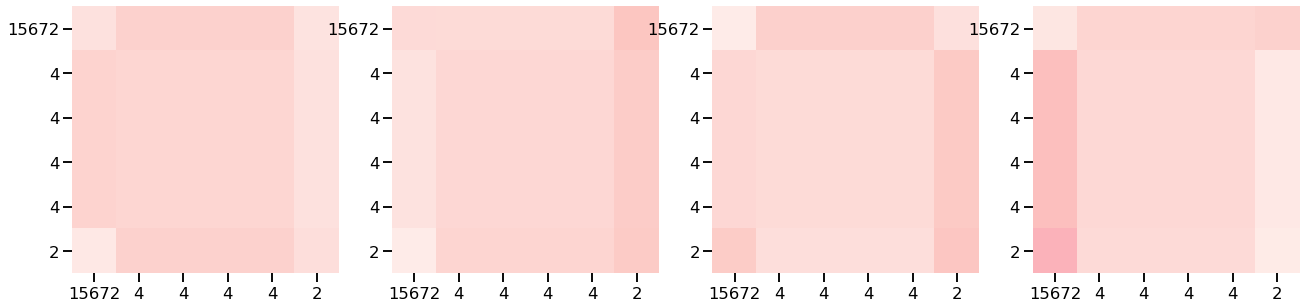

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 3
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.311 	F-macro_val: 0.245
Epoch 10 	acc_val: 0.878 	F-macro_val: 0.432
Epoch 20 	acc_val: 0.876 	F-macro_val: 0.430
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


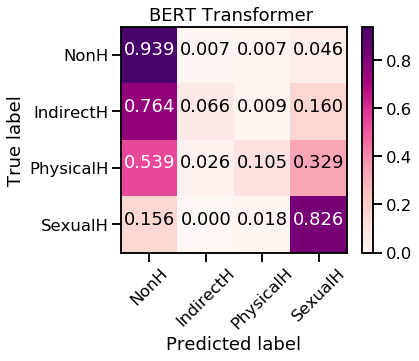

Test_ acc: 0.8478568064060292
Test_ f1 none: [0.917 0.111 0.155 0.763]
Test_ f1 macro: 0.486518742405482
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 4
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.157 	F-macro_val: 0.138
Epoch 10 	acc_val: 0.853 	F-macro_val: 0.425
Epoch 20 	acc_val: 0.861 	F-macro_val: 0.424
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


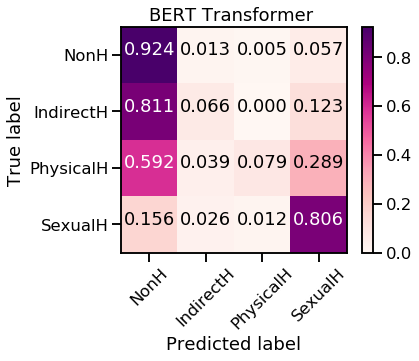

Test_ acc: 0.832312764955252
Test_ f1 none: [0.907 0.096 0.128 0.74 ]
Test_ f1 macro: 0.46741903459095335
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 5
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.594 	F-macro_val: 0.258
Epoch 10 	acc_val: 0.874 	F-macro_val: 0.424
Epoch 20 	acc_val: 0.872 	F-macro_val: 0.424
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


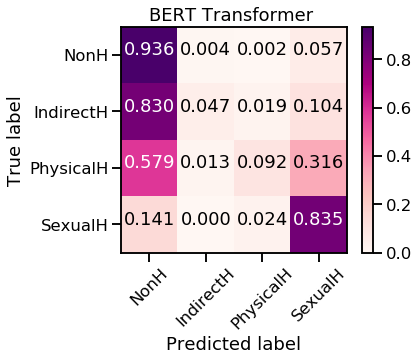

Test_ acc: 0.8450306170513424
Test_ f1 none: [0.914 0.084 0.144 0.756]
Test_ f1 macro: 0.4745954024079579
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 6
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.665 	F-macro_val: 0.262
Epoch 10 	acc_val: 0.868 	F-macro_val: 0.430
Epoch 20 	acc_val: 0.866 	F-macro_val: 0.426
Testing run # 6
SE TUVIERON QUE REPETIR 21 EJEMPLOS


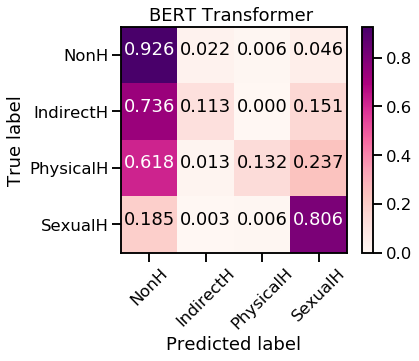

Test_ acc: 0.8379651436646255
Test_ f1 none: [0.906 0.155 0.204 0.76 ]
Test_ f1 macro: 0.5063637596091182


Ejemplo de tweet con label  NonH  y tweet_id  1188
Encoder Layer 1


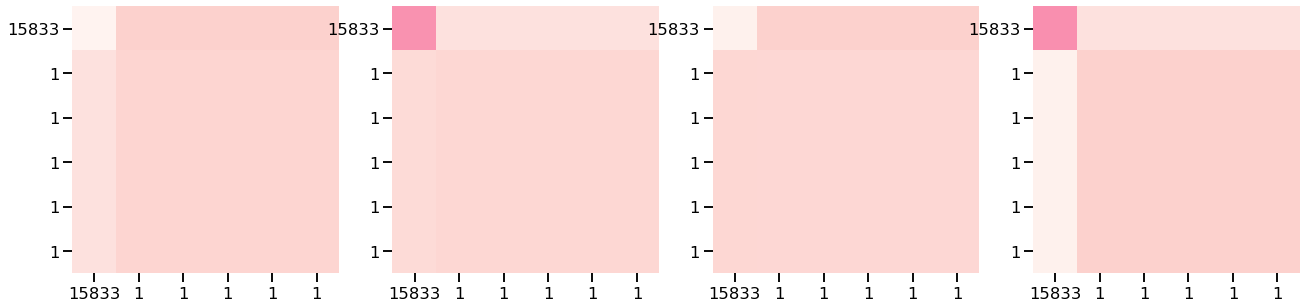

Encoder Layer 2


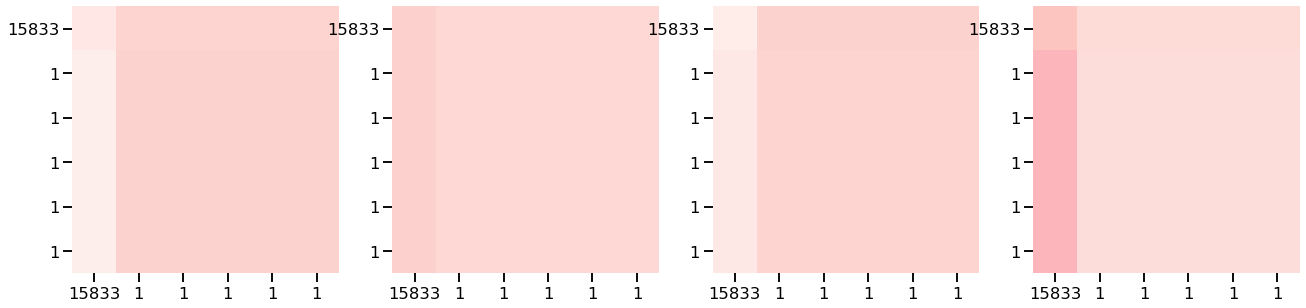



Ejemplo de tweet con label  IndirectH  y tweet_id  1489
Encoder Layer 1


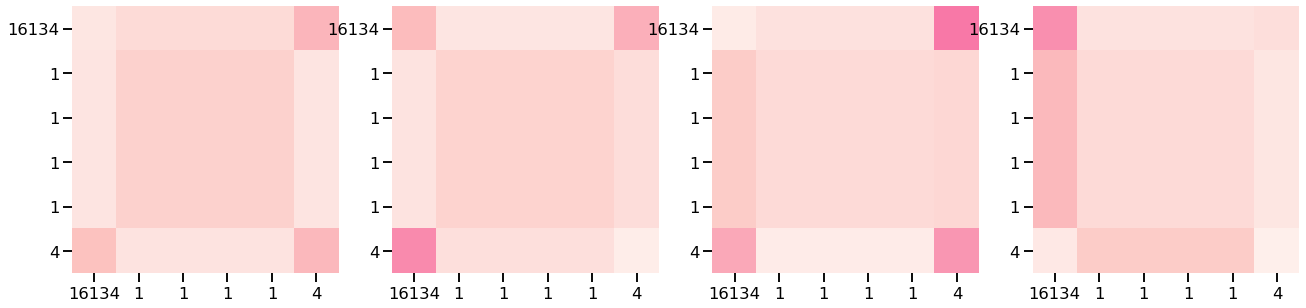

Encoder Layer 2


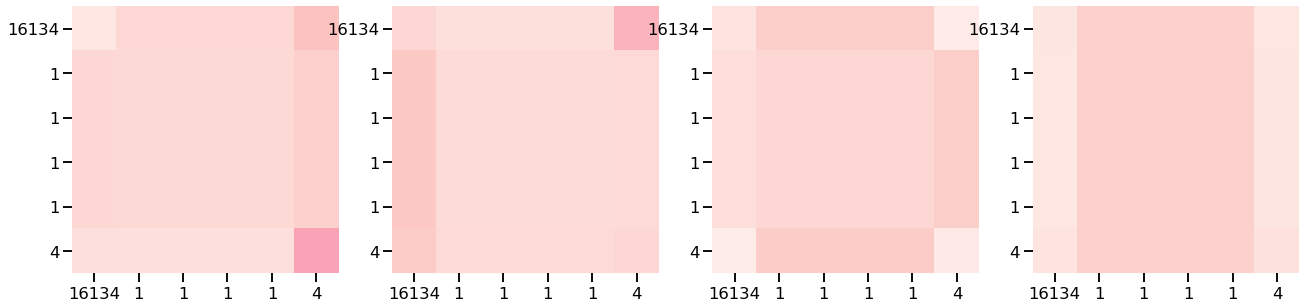



Ejemplo de tweet con label  PhysicalH  y tweet_id  1460
Encoder Layer 1


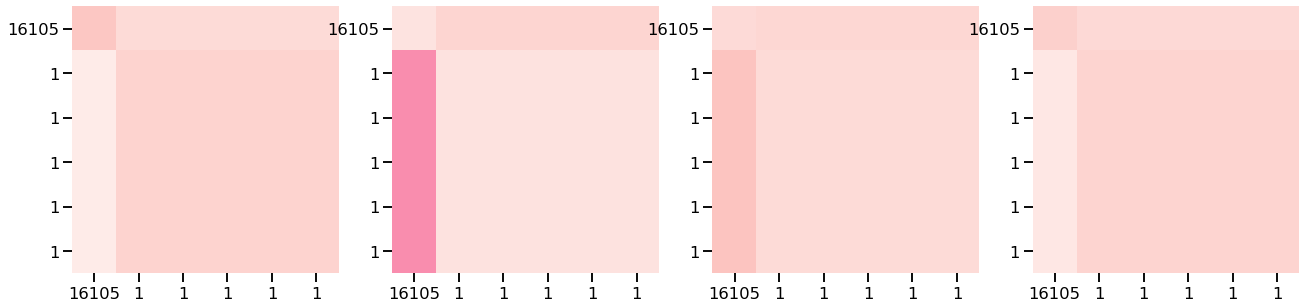

Encoder Layer 2


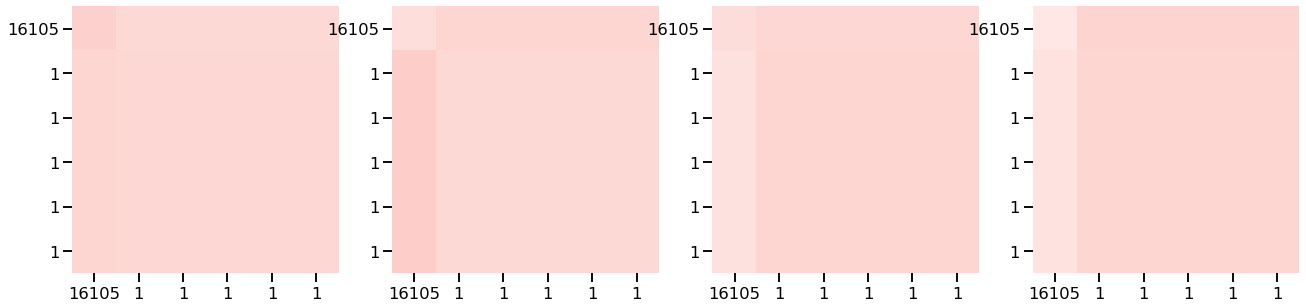



Ejemplo de tweet con label  SexualH  y tweet_id  529
Encoder Layer 1


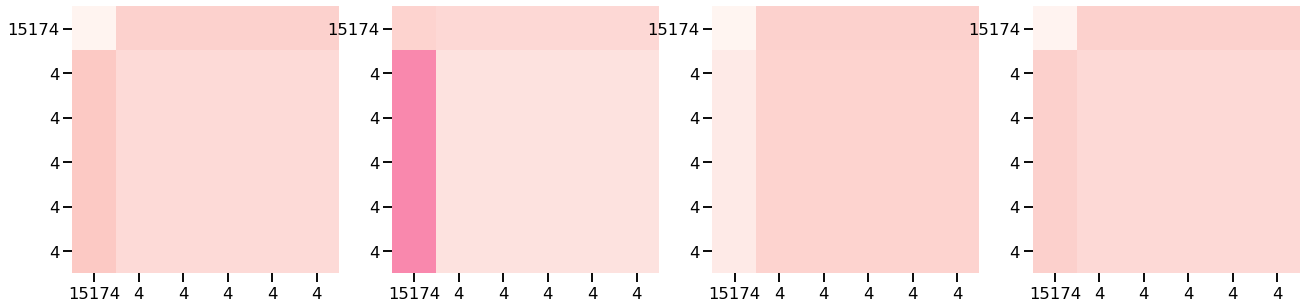

Encoder Layer 2


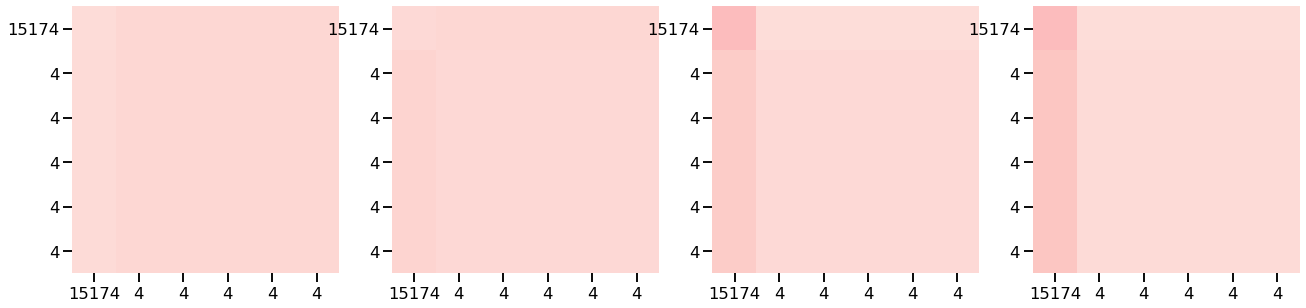

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 7
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.411 	F-macro_val: 0.168
Epoch 10 	acc_val: 0.859 	F-macro_val: 0.426
Epoch 20 	acc_val: 0.869 	F-macro_val: 0.432
Testing run # 7
SE TUVIERON QUE REPETIR 21 EJEMPLOS


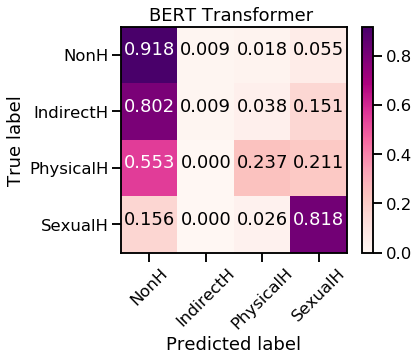

Test_ acc: 0.8318417333961375
Test_ f1 none: [0.904 0.016 0.265 0.753]
Test_ f1 macro: 0.4846217147128077
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 8
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.174 	F-macro_val: 0.087
Epoch 10 	acc_val: 0.874 	F-macro_val: 0.430
Epoch 20 	acc_val: 0.875 	F-macro_val: 0.428
Testing run # 8
SE TUVIERON QUE REPETIR 21 EJEMPLOS


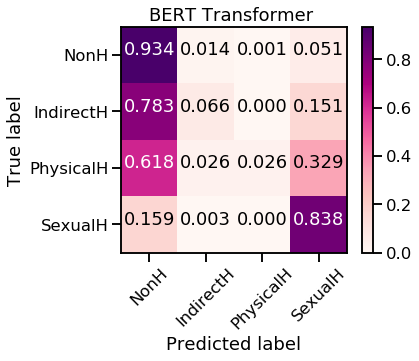

Test_ acc: 0.8431464908148846
Test_ f1 none: [0.912 0.101 0.051 0.762]
Test_ f1 macro: 0.4565078426904543
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 9
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.348 	F-macro_val: 0.232
Epoch 10 	acc_val: 0.871 	F-macro_val: 0.444
Epoch 20 	acc_val: 0.875 	F-macro_val: 0.450
Testing run # 9
SE TUVIERON QUE REPETIR 21 EJEMPLOS


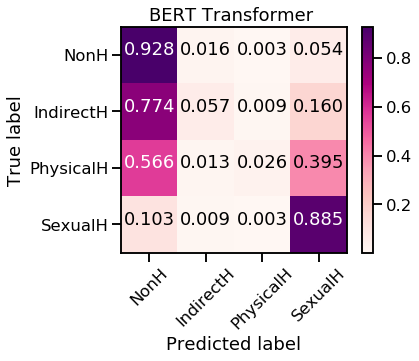

Test_ acc: 0.8450306170513424
Test_ f1 none: [0.915 0.085 0.047 0.778]
Test_ f1 macro: 0.4562288144633452
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 10
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.473 	F-macro_val: 0.219
Epoch 10 	acc_val: 0.862 	F-macro_val: 0.433
Epoch 20 	acc_val: 0.863 	F-macro_val: 0.428
Testing run # 10
SE TUVIERON QUE REPETIR 21 EJEMPLOS


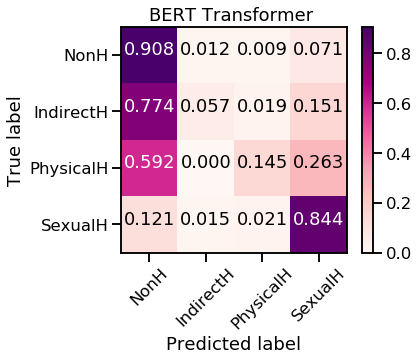

Test_ acc: 0.8276024493641074
Test_ f1 none: [0.902 0.088 0.198 0.739]
Test_ f1 macro: 0.48177412542348463


In [47]:
### solo 10!! 
best_85, all_accs_85, all_fno_85, all_ma_85, all_cm_85 =train_transformer(0.85, 26, path_a, path_m, "RdPu", xfrom=1, xto=10, augmented=True)

In [48]:
print ("best_85", best_85)
print ("all_accs_85", all_accs_85)
print ("all_fno_85", all_fno_85)
print ("all_ma_85", all_ma_85)

best_85 {'F_ma': 0.5063637596091182, 'Run': 6}
all_accs_85 [0.8455016486104568, 0.8007536504945831, 0.8478568064060292, 0.832312764955252, 0.8450306170513424, 0.8379651436646255, 0.8318417333961375, 0.8431464908148846, 0.8450306170513424, 0.8276024493641074]
all_fno_85 [array([0.915, 0.05 , 0.068, 0.764]), array([0.882, 0.231, 0.158, 0.715]), array([0.917, 0.111, 0.155, 0.763]), array([0.907, 0.096, 0.128, 0.74 ]), array([0.914, 0.084, 0.144, 0.756]), array([0.906, 0.155, 0.204, 0.76 ]), array([0.904, 0.016, 0.265, 0.753]), array([0.912, 0.101, 0.051, 0.762]), array([0.915, 0.085, 0.047, 0.778]), array([0.902, 0.088, 0.198, 0.739])]
all_ma_85 [0.4493253463408824, 0.4966715773398395, 0.486518742405482, 0.46741903459095335, 0.4745954024079579, 0.5063637596091182, 0.4846217147128077, 0.4565078426904543, 0.4562288144633452, 0.48177412542348463]


Acc: 0.836 -- deviation: 0.013
F-score: 0.476 -- deviation: 0.018
(0.85) NIPS: 0.9073464247771458 0.10186341872361522 0.14186043850925384 0.7529402619837151


Confusion counts
[[1.472e+04 2.250e+02 1.040e+02 9.560e+02]
 [8.110e+02 7.700e+01 1.200e+01 1.600e+02]
 [4.380e+02 1.300e+01 7.500e+01 2.340e+02]
 [4.680e+02 2.600e+01 4.100e+01 2.865e+03]]


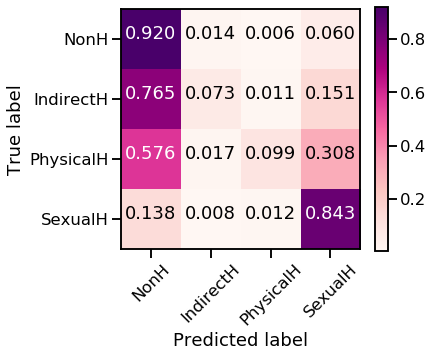

In [49]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs_85)), "-- deviation: %.3f" % np.std(np.asarray(all_accs_85)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma_85)), "-- deviation: %.3f" % np.std(np.asarray(all_ma_85)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno_85)[:,0])
den=np.mean(np.asarray(all_fno_85)[:,1])
que=np.mean(np.asarray(all_fno_85)[:,2])
com=np.mean(np.asarray(all_fno_85)[:,3])

print ("(0.85) NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm_85:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["NonH", "IndirectH", "PhysicalH", "SexualH"], "", cmap='RdPu')